In [18]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole
%reload_ext snakeviz

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from collections import namedtuple
from os.path import join, abspath, dirname, pardir

# LFP sampling frequency
sampling_frequency = 1500

# Data directories and definitions
NOTEBOOK_DIR = !pwd
ROOT_DIR = abspath(dirname(NOTEBOOK_DIR[0]))
RAW_DATA_DIR = join(ROOT_DIR, 'Raw-Data')

Animal = namedtuple('Animal', {'directory', 'short_name'})
animals = {
    'bon': Animal(directory=join(RAW_DATA_DIR, 'Bond'),
                  short_name='bon'),
}

epoch_key = ('bon', 3, 2)

In [12]:
from logging import getLogger
from os.path import join

import numpy as np
import pandas as pd
import joblib

from loren_frank_data_processing import (get_all_multiunit_indicators,
                                         get_all_spike_indicators,
                                         get_interpolated_position_dataframe,
                                         get_LFPs, make_neuron_dataframe,
                                         make_tetrode_dataframe)
from ripple_detection import (Kay_ripple_detector, filter_ripple_band,
                              get_multiunit_population_firing_rate,
                              multiunit_HSE_detector)
from spectral_connectivity import Connectivity, Multitaper
from scipy.ndimage.measurements import label
from matplotlib.colors import ListedColormap, LogNorm
import seaborn as sns

logger = getLogger(__name__)

_MARKS = ['channel_1_max', 'channel_2_max', 'channel_3_max', 'channel_4_max']


def get_ripple_labels(ripple_times, time):
    ripple_labels = pd.DataFrame(np.zeros_like(time, dtype=np.int), index=time,
                                 columns=['replay_number'])
    for replay_number, start_time, end_time in ripple_times.itertuples():
        ripple_labels.loc[start_time:end_time] = replay_number

    return ripple_labels


def estimate_ripple_band_power(lfps, sampling_frequency):
    m = Multitaper(lfps.values, sampling_frequency=sampling_frequency,
                   time_halfbandwidth_product=1,
                   time_window_duration=0.020,
                   time_window_step=0.020,
                   start_time=lfps.index[0].total_seconds())
    c = Connectivity.from_multitaper(m)
    closest_200Hz_freq_ind = np.argmin(np.abs(c.frequencies - 200))
    power = c.power()[..., closest_200Hz_freq_ind, :].squeeze() + np.spacing(1)
    n_samples = int(0.020 * sampling_frequency)
    index = lfps.index[np.arange(1, power.shape[0] * n_samples + 1, n_samples)]
    power = pd.DataFrame(power, index=index)
    return power.reindex(lfps.index)


def load_data(epoch_key, animals, sampling_frequency, data_types,
              brain_areas, speed_metric='linear_speed'):

    logger.info('Loading Data...')
    position_info = (
        get_interpolated_position_dataframe(epoch_key, animals)
        .dropna(subset=['linear_distance', 'linear_speed']))

    speed = position_info[speed_metric]
    time = position_info.index

    tetrode_info = make_tetrode_dataframe(animals).xs(
        epoch_key, drop_level=False)
    is_brain_areas = tetrode_info.area.isin(brain_areas)
    tetrode_keys = tetrode_info.loc[
        (tetrode_info.validripple == 1) & is_brain_areas].index
    lfps = get_LFPs(tetrode_keys, animals)
    lfps = lfps.reindex(time)

    if 'lfp_power' in data_types:
        power = estimate_ripple_band_power(lfps, sampling_frequency)
    else:
        power = None

    neuron_info = make_neuron_dataframe(animals).xs(
        epoch_key, drop_level=False)
    neuron_info = neuron_info.loc[
        (neuron_info.numspikes > 0) &
        neuron_info.area.isin(brain_areas)]
    spikes = (get_all_spike_indicators(neuron_info.index, animals)
              .reindex(time))

    logger.info('Finding multiunit high synchrony events...')
    tetrode_info = tetrode_info.loc[
        (tetrode_info.numcells > 0) & is_brain_areas]
    if 'multiunit' in data_types:
        multiunit = (get_all_multiunit_indicators(tetrode_info.index, animals)
                     .sel(features=_MARKS)
                     .reindex({'time': time}))
        multiunit_spikes = (np.any(~np.isnan(multiunit), axis=1)
                            .values).astype(np.float)
        multiunit_high_synchrony_times = multiunit_HSE_detector(
            time, multiunit_spikes, speed.values, sampling_frequency,
            minimum_duration=np.timedelta64(15, 'ms'), zscore_threshold=2.0,
            close_event_threshold=np.timedelta64(0, 'ms'))
        multiunit_high_synchrony_times.index = (
            multiunit_high_synchrony_times.index.rename('replay_number'))
        multiunit_high_synchrony_labels = get_ripple_labels(
            multiunit_high_synchrony_times, time)
        multiunit_firing_rate = pd.DataFrame(
            get_multiunit_population_firing_rate(
                multiunit_spikes, sampling_frequency), index=time,
            columns=['firing_rate'])
    else:
        multiunit = None
        multiunit_high_synchrony_times = None
        multiunit_high_synchrony_labels = 0
        multiunit_firing_rate = None

    logger.info('Finding ripple times...')
    ripple_times = Kay_ripple_detector(
        time, lfps.values, speed.values, sampling_frequency,
        zscore_threshold=2.0, close_ripple_threshold=np.timedelta64(0, 'ms'),
        minimum_duration=np.timedelta64(15, 'ms'))
    ripple_times.index = ripple_times.index.rename('replay_number')
    ripple_labels = get_ripple_labels(ripple_times, time)

    ripple_band_lfps = pd.DataFrame(
        np.stack([filter_ripple_band(lfps.values[:, ind])
                  for ind in np.arange(lfps.shape[1])], axis=1),
        index=lfps.index)

    ripple_times = ripple_times.assign(
        duration=lambda df: (df.end_time - df.start_time).dt.total_seconds())

    return {
        'position_info': position_info,
        'ripple_times': ripple_times,
        'is_ripple': ripple_labels > 0,
        'ripple_labels': ripple_labels,
        'power': power,
        'spikes': spikes,
        'multiunit': multiunit,
        'lfps': lfps,
        'tetrode_info': tetrode_info,
        'ripple_band_lfps': ripple_band_lfps,
        'multiunit_high_synchrony_times': multiunit_high_synchrony_times,
        'is_multiunit_high_synchrony': multiunit_high_synchrony_labels > 0,
        'multiunit_firing_rate': multiunit_firing_rate,
    }



def start_time(s):
    return s.index[0]


def end_time(s):
    return s.index[-1]


def max_probability(df):
    return df.max()


def duration(df):
    return (df.index[-1] - df.index[0]).total_seconds()

def get_replay_times(results, probability_threshold=0.8,
                     minimum_duration=0.000):

    replay_labels = label(
        results.replay_probability > probability_threshold)[0]
    labels = pd.DataFrame(
        {'replay_number': replay_labels,
         'replay_probability': results.replay_probability.values},
        index=results.time.to_index())

    grouper = labels.loc[labels.replay_number > 0].groupby('replay_number')
    replay_times = (grouper
                    .agg([start_time, end_time, duration, max_probability]))
    replay_times.columns = replay_times.columns.get_level_values(1)

    replay_times = replay_times.loc[replay_times.duration > minimum_duration]
    labels[~labels.isin(replay_times.index.values)] = 0

    return replay_times, labels


def plot_replay_spiking_ordered_by_place_fields(
        spikes, place_field_firing_rates, place_bin_centers,
        ax=None, cmap=None, sampling_frequency=1, time=None):
    '''Plot spikes by the positiion of their maximum place field firing rate.

    Parameters
    ----------
    spikes : ndarray, shape (n_time, n_neurons)
    place_field_firing_rates : ndarray, shape (n_neurons, n_place_bins)
    place_bin_centers : ndarray, shape (n_place_bins,)
    ax : None or matplotlib axis, optional
    cmap : None, str, or array, optional
    sampling_frequency : float, optional
    time : ndarray, shape (n_time,), optional

    Returns
    -------
    ax : matplotlib axis
    im : scatter plot handle

    '''
    ax = ax or plt.gca()
    AVG_PLACE_FIELD_SIZE = 25
    n_colors = int(np.ceil(np.ptp(place_bin_centers) / AVG_PLACE_FIELD_SIZE))
    cmap = cmap or ListedColormap(sns.color_palette('hls', n_colors))

    n_time, n_neurons = spikes.shape
    if time is None:
        time = np.arange(n_time) / sampling_frequency

    cmap = plt.get_cmap(cmap)
    neuron_to_place_bin = np.argmax(place_field_firing_rates, axis=1)
    ordered_place_field_to_neuron = np.argsort(neuron_to_place_bin)
    neuron_to_ordered_place_field = np.argsort(ordered_place_field_to_neuron)

    time_ind, neuron_ind = np.nonzero(spikes)
    im = ax.scatter(time[time_ind], neuron_to_ordered_place_field[neuron_ind],
                    c=place_bin_centers[neuron_to_place_bin[neuron_ind]],
                    cmap=cmap, vmin=np.floor(place_bin_centers.min()),
                    vmax=np.ceil(place_bin_centers.max()))
    plt.colorbar(im, ax=ax, label='position')

    ax.set_xlim(time[[0, -1]])
    ax.set_xlabel('Time')
    ax.set_ylabel('Neurons')
    ax.set_yticks(np.arange(n_neurons))
    ax.set_yticklabels(ordered_place_field_to_neuron + 1)
    ax.set_ylim((-0.25, n_neurons - 1 + 0.25))
    sns.despine()

    return ax, im


In [13]:
data_types = {'lfp_power', 'spikes', 'multiunit'}
brain_areas = ['CA1', 'CA2', 'CA3']

data = load_data(epoch_key, animals, sampling_frequency, data_types,
                 brain_areas, speed_metric='linear_speed')

INFO:__main__:Loading Data...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3731.026366666, n_tapers=1)
INFO:__main__:Finding multiunit high synchrony events...
INFO:__main__:Finding ripple times...


In [14]:
from loren_frank_data_processing.position import make_track_graph

track_graph, center_well_id = make_track_graph(epoch_key, animals)

In [15]:
from replay_identification.core import get_track_grid

edge_order = [0, 2, 4, 1, 3]
edge_spacing = [15, 0, 15, 0]
place_bin_size = 3.0

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting replay movement state transition...


INFO:replay_identification.decoders:Fitting replay state transition...


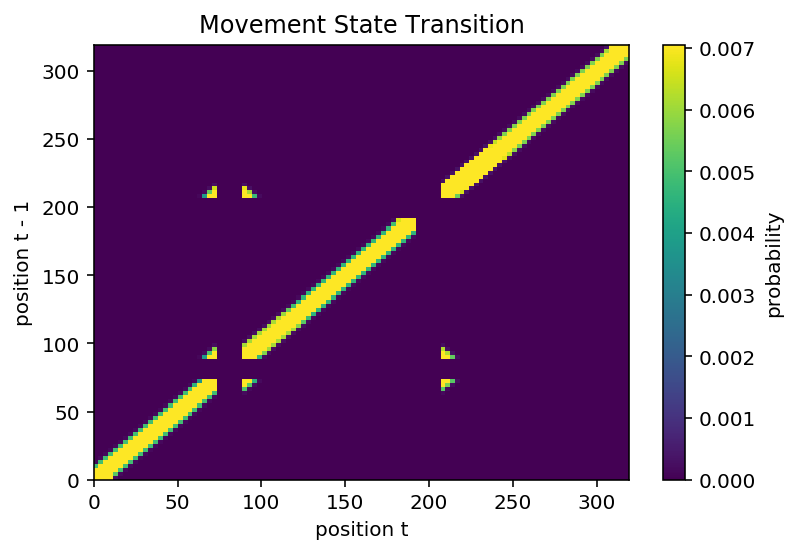

In [20]:
from replay_identification import ReplayDetector

detector = ReplayDetector(
    place_bin_size=3.0, movement_var=9.0,
    movement_state_transition_type='random_walk',
    discrete_state_transition_type='constant')

speed_metric = 'linear_speed'
position_metric = 'linear_position'

detector.fit(
    is_ripple=data['is_ripple'],
    speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=None,
    spikes=data['spikes'],
    multiunit=None,
    track_graph=track_graph,
    center_well_id=center_well_id,
    edge_order=edge_order,
    edge_spacing=edge_spacing)

detector.plot_movement_state_transition()

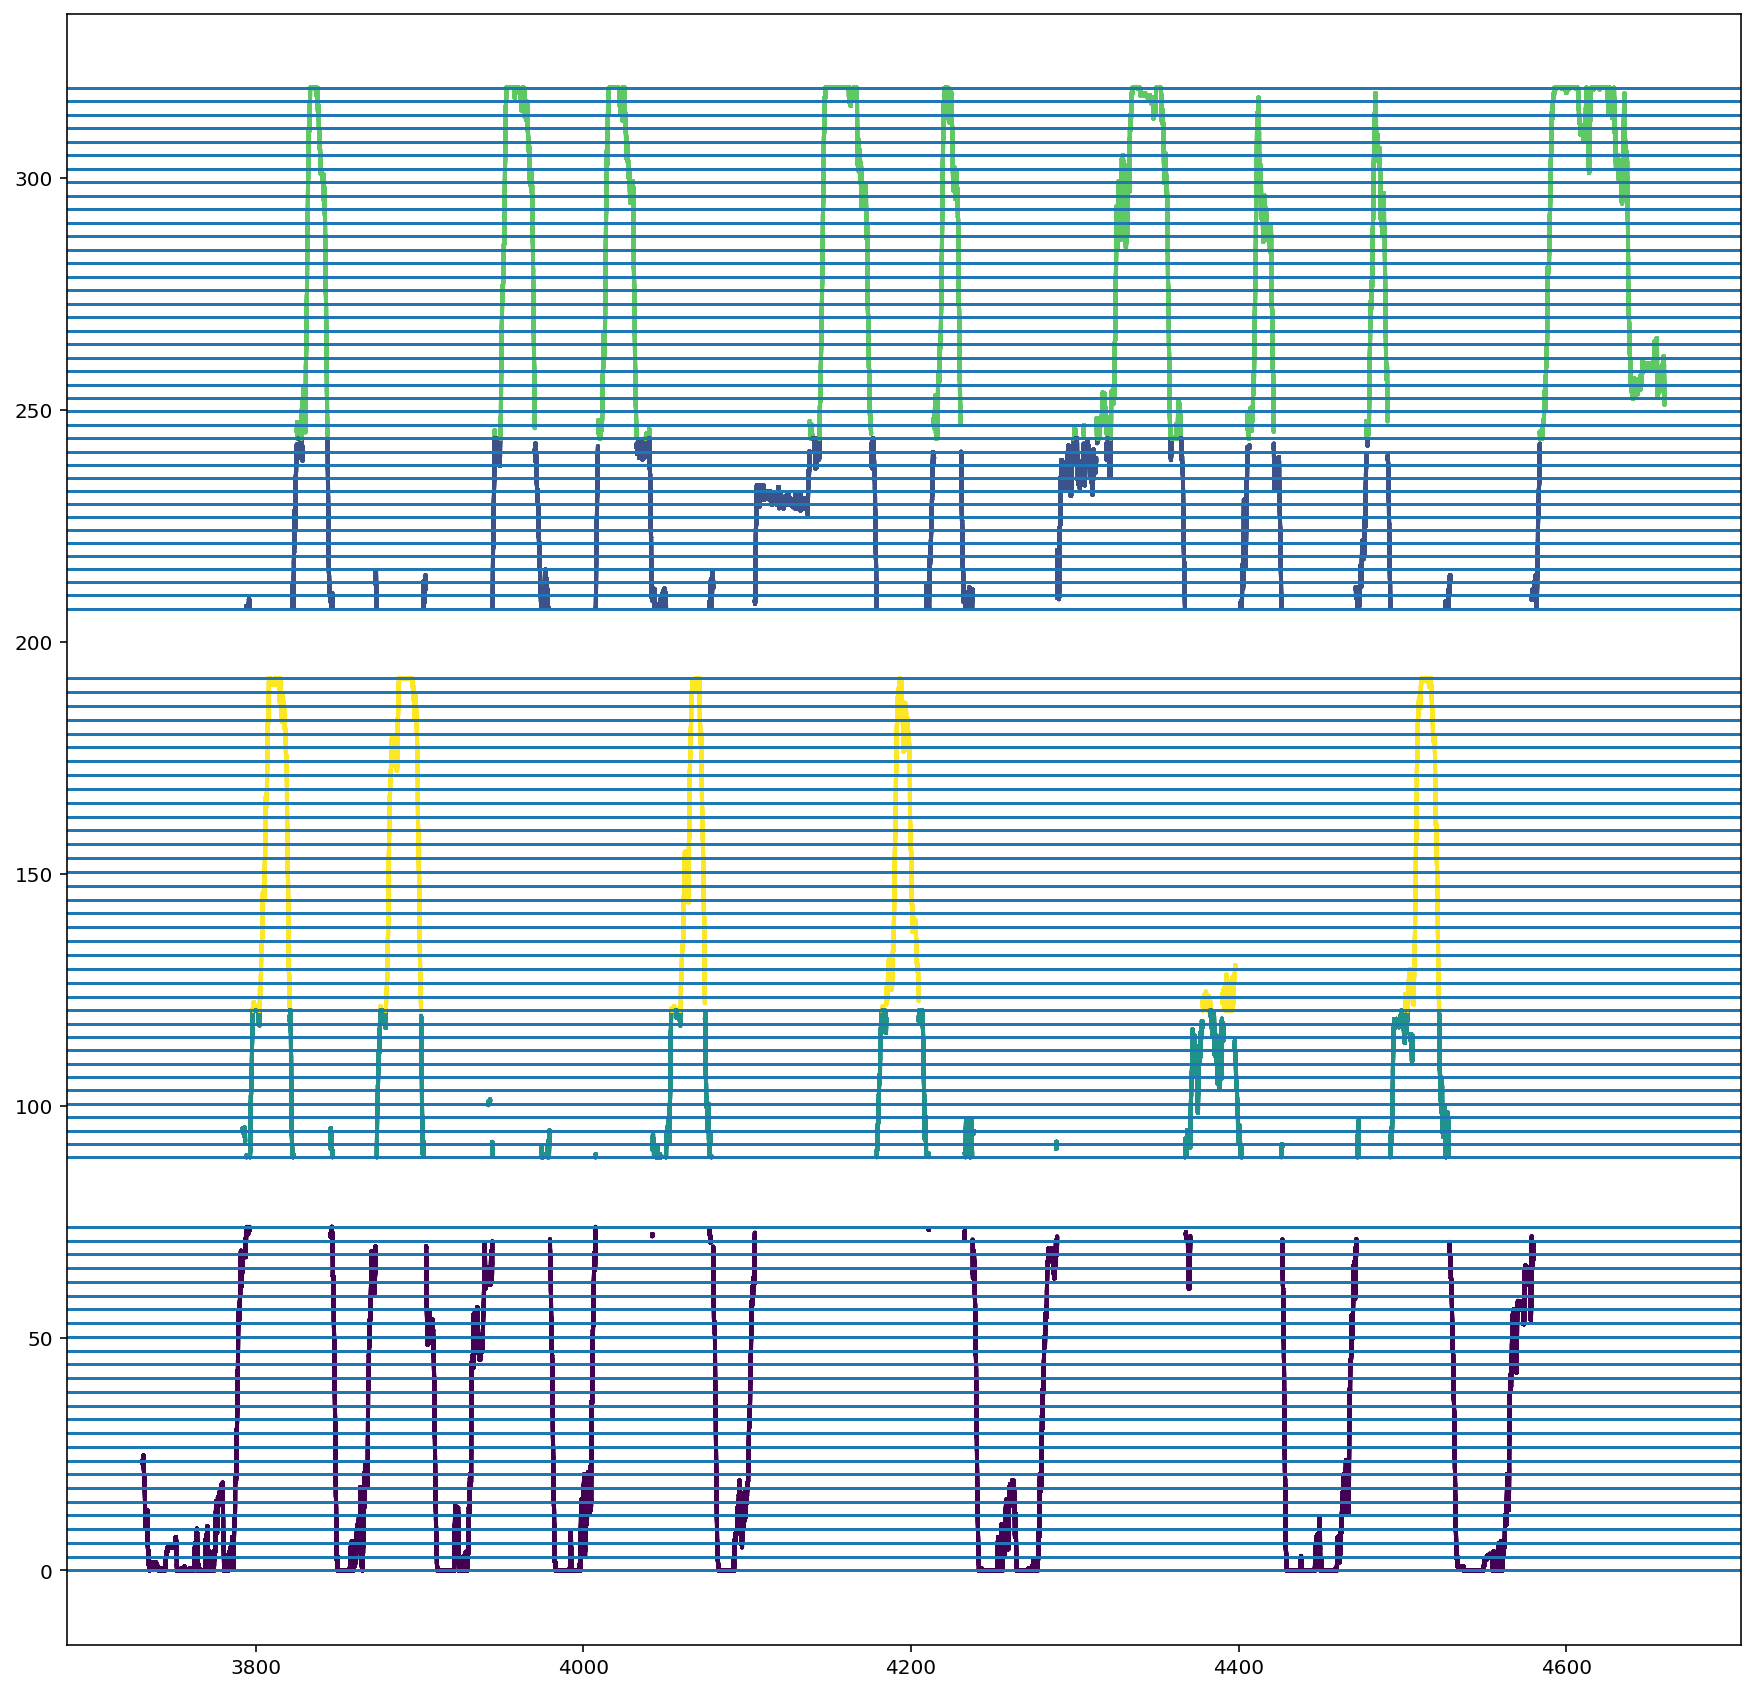

In [21]:
plt.figure(figsize=(15, 15))

plt.scatter(
    data['position_info'].index / np.timedelta64(1, 's'),
    data['position_info'].linear_position,
    c=data['position_info'].track_segment_id.astype(int), s=1)

for e in detector.place_bin_edges_.squeeze():
    plt.axhline(e)

In [22]:
time_slice = slice(0, 100000)

results = detector.predict(
    speed=data['position_info'][speed_metric].iloc[time_slice],
    position=data['position_info'][position_metric].iloc[time_slice],
    spikes=data['spikes'].iloc[time_slice],
    use_likelihoods=['spikes'],
)

results

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Finding causal replay probability and position...
INFO:replay_identification.decoders:Finding acausal replay probability and position...


<xarray.Dataset>
Dimensions:             (position: 101, state: 2, time: 100000)
Coordinates:
  * time                (time) int64 0 1 2 3 4 ... 99995 99996 99997 99998 99999
  * position            (position) float64 1.481 4.442 7.404 ... 315.1 318.0
  * state               (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 8.732e-06
    likelihood          (time, state, position) float64 0.9753 0.9753 ... 0.9994
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 8.732e-06
    replay_probability  (time) float64 0.0 0.01222 ... 0.0009109 0.0009231

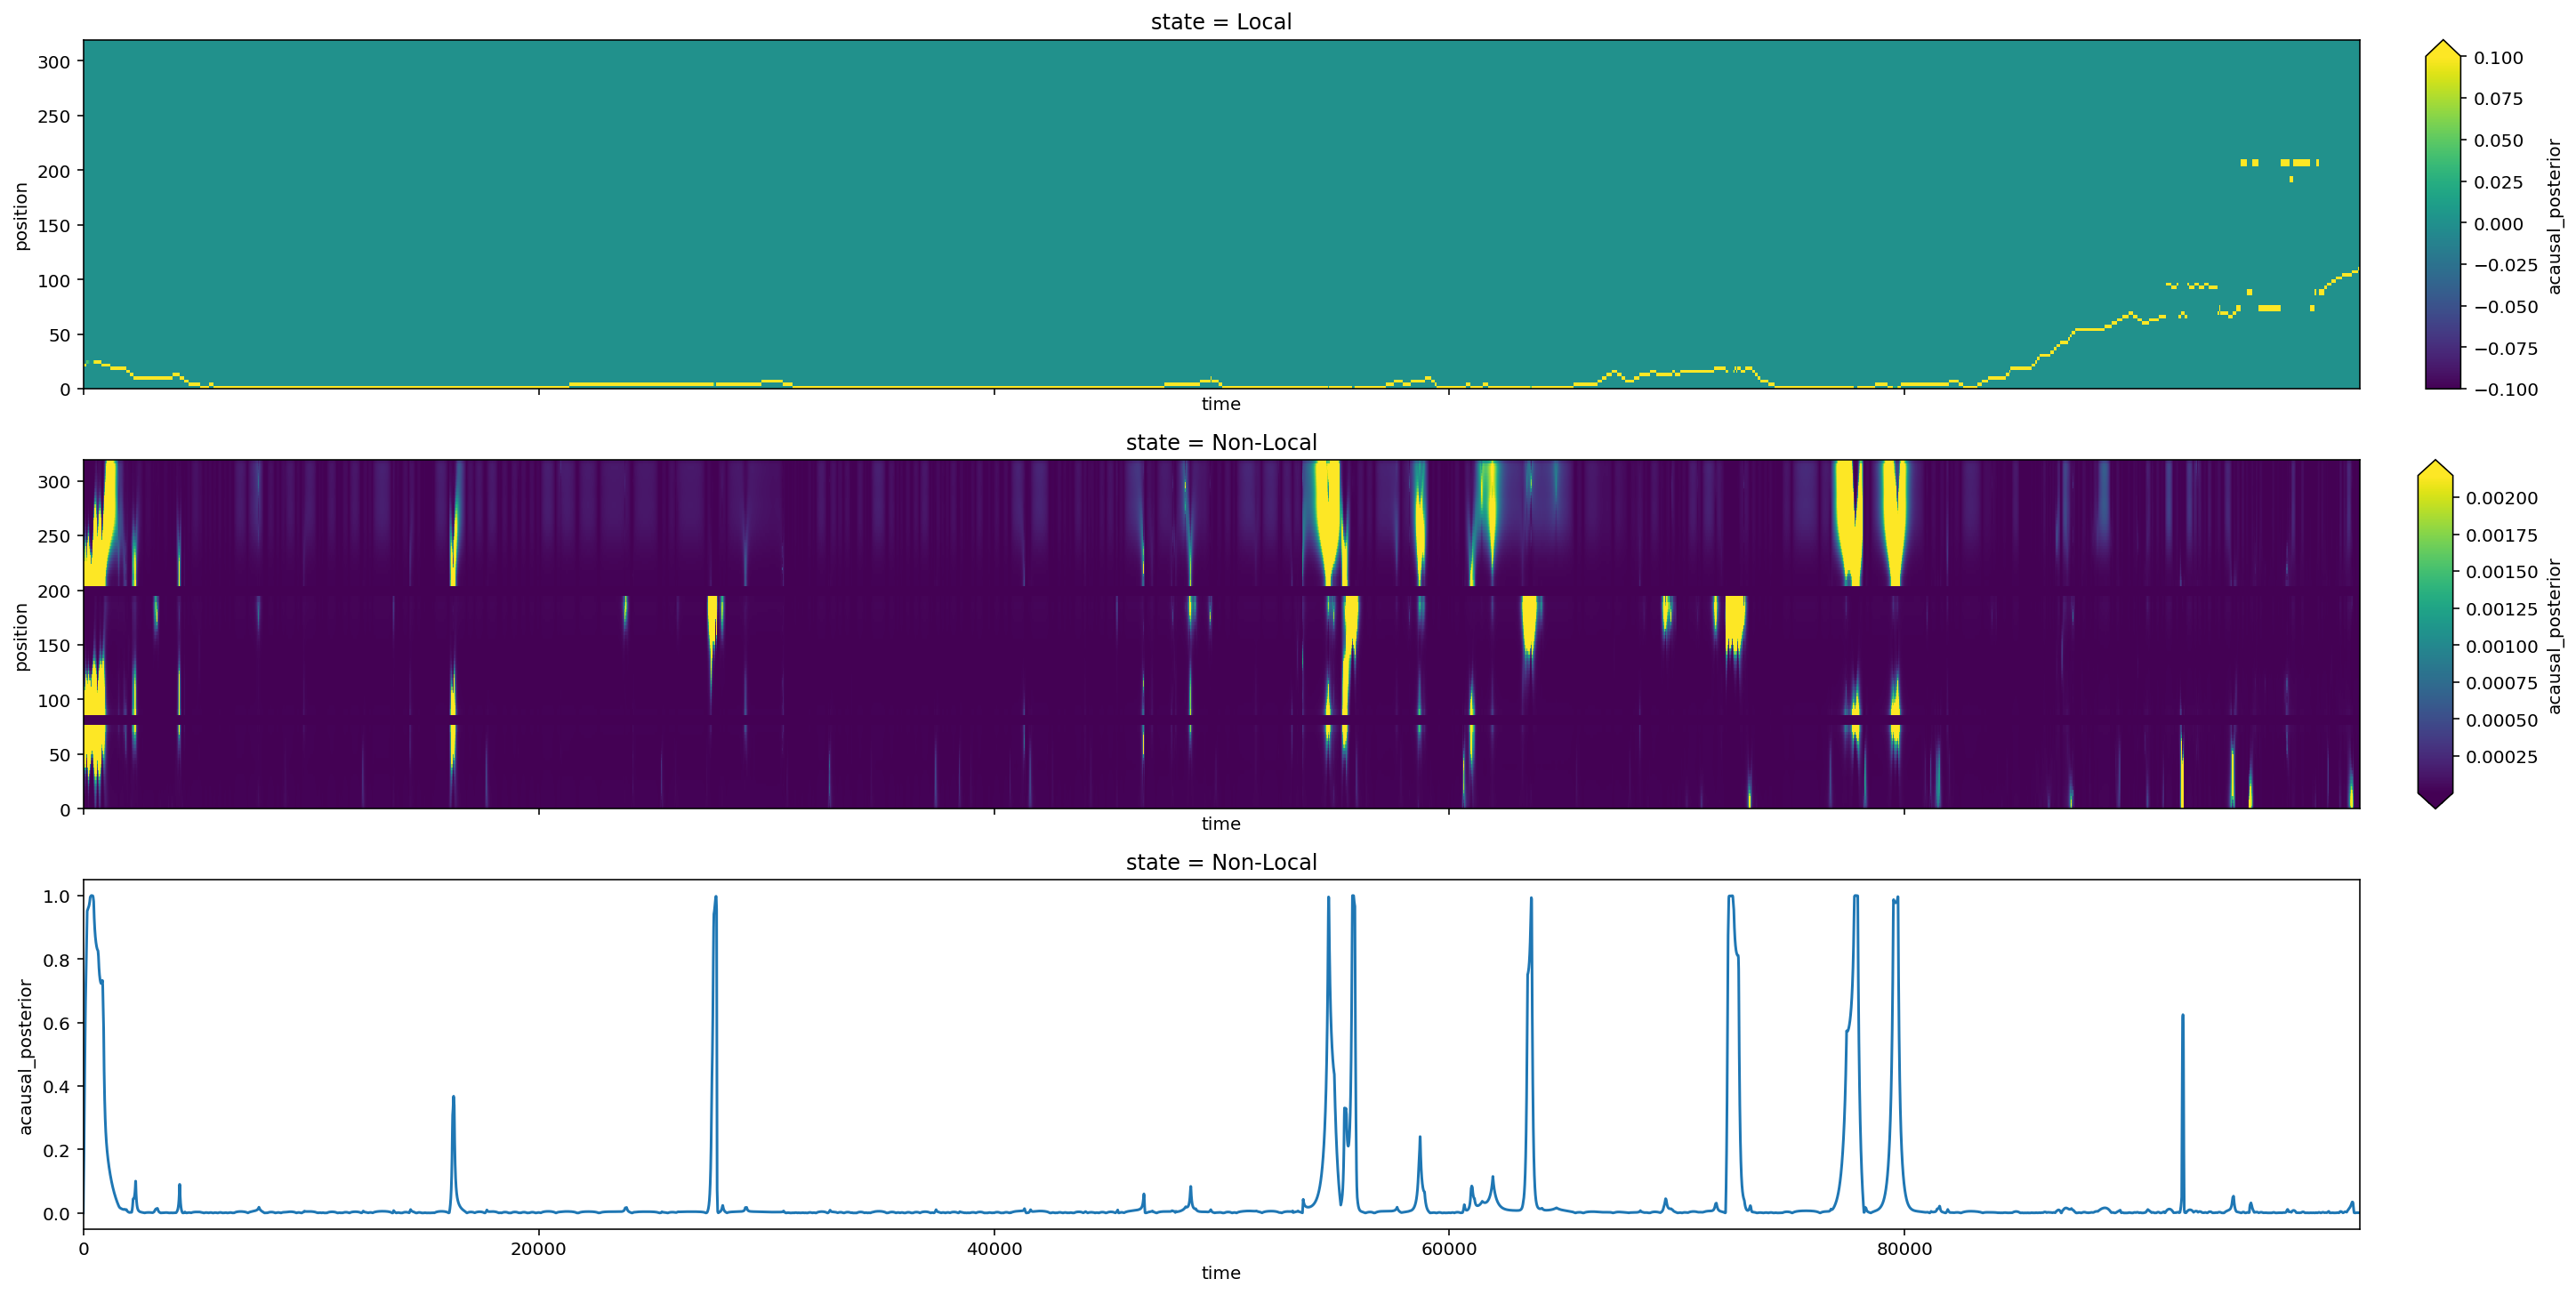

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), constrained_layout=True, sharex=True)

results.acausal_posterior.sel(state='Local').plot(x='time', y='position', robust=True, ax=axes[0])
results.acausal_posterior.sel(state='Non-Local').plot(x='time', y='position', robust=True, ax=axes[1])
results.acausal_posterior.sum('position').sel(state='Non-Local').plot(ax=axes[2])

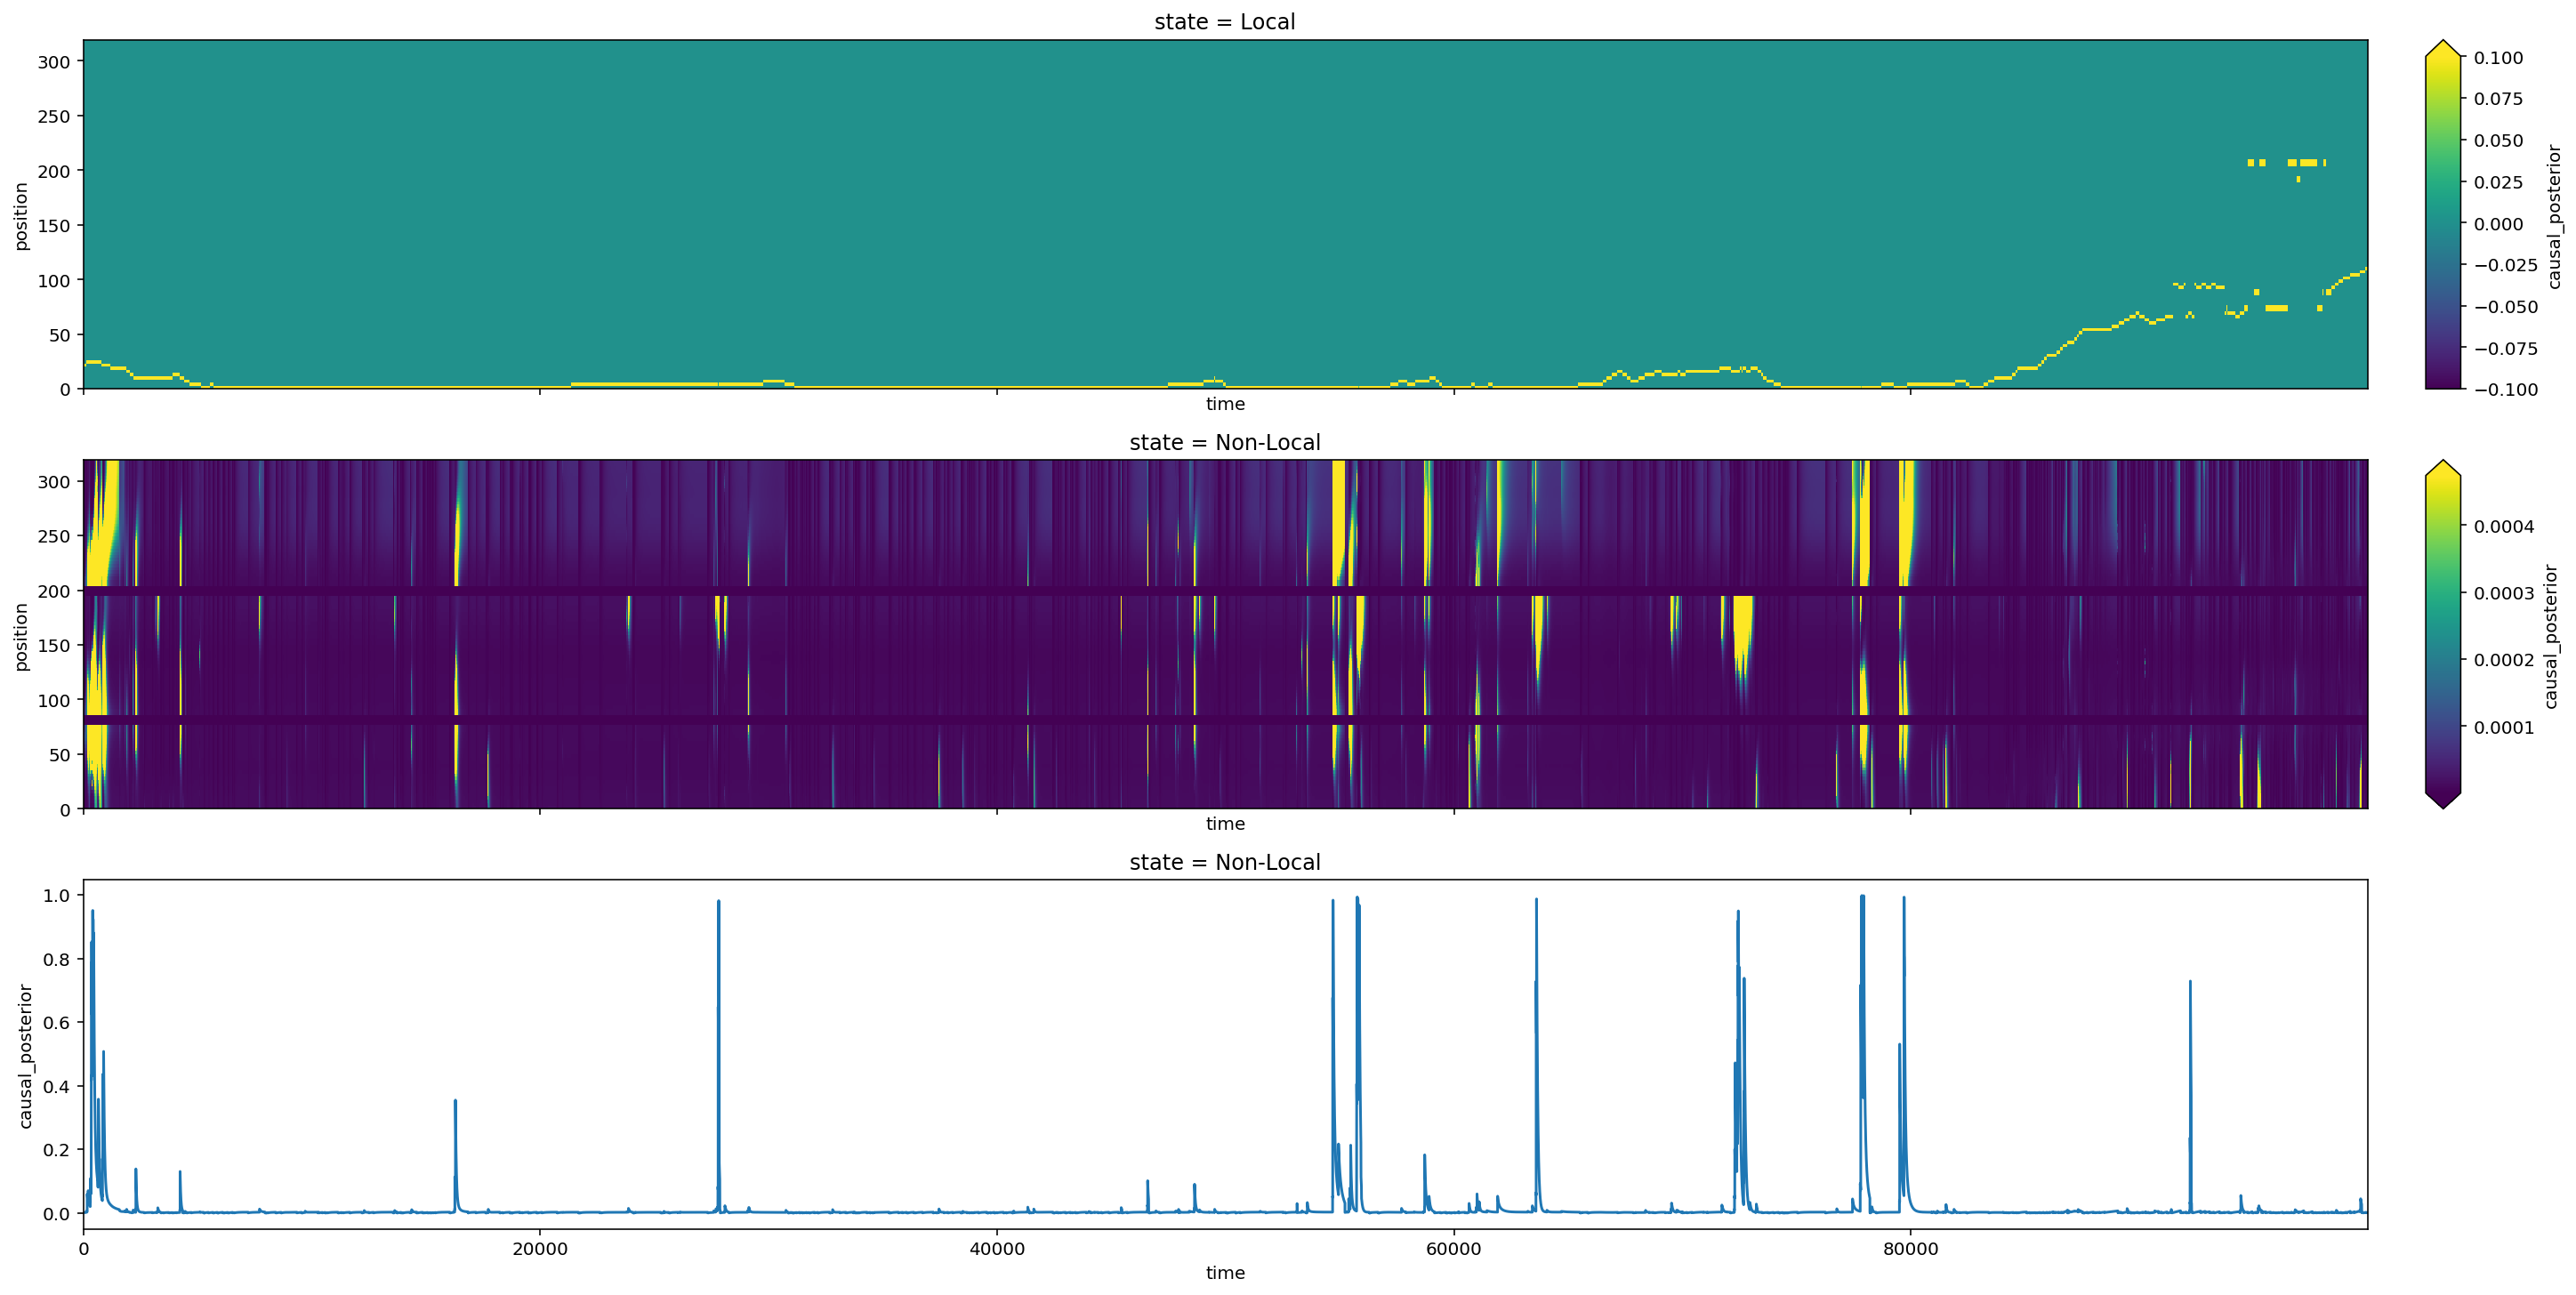

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), constrained_layout=True, sharex=True)

results.causal_posterior.sel(state='Local').plot(x='time', y='position', robust=True, ax=axes[0])
results.causal_posterior.sel(state='Non-Local').plot(x='time', y='position', robust=True, ax=axes[1])
results.causal_posterior.sum('position').sel(state='Non-Local').plot(ax=axes[2])

In [94]:
np.nonzero(~detector.is_track_interior_)

(array([25, 61]),)

In [14]:
is_track_interior = detector.is_track_interior_
position = data['position_info'].linear_position.values
bin_edges = detector.place_bin_edges_

bin_ind = np.digitize(position.squeeze(), bin_edges.squeeze()) - 1
not_track_bin = np.nonzero(~is_track_interior)[0]
not_track_bin = np.append(not_track_bin, bin_edges.size)
for bin in not_track_bin:
    bin_ind[bin_ind == bin] = bin - 1

In [15]:
np.any(np.isin(bin_ind, not_track_bin))

False

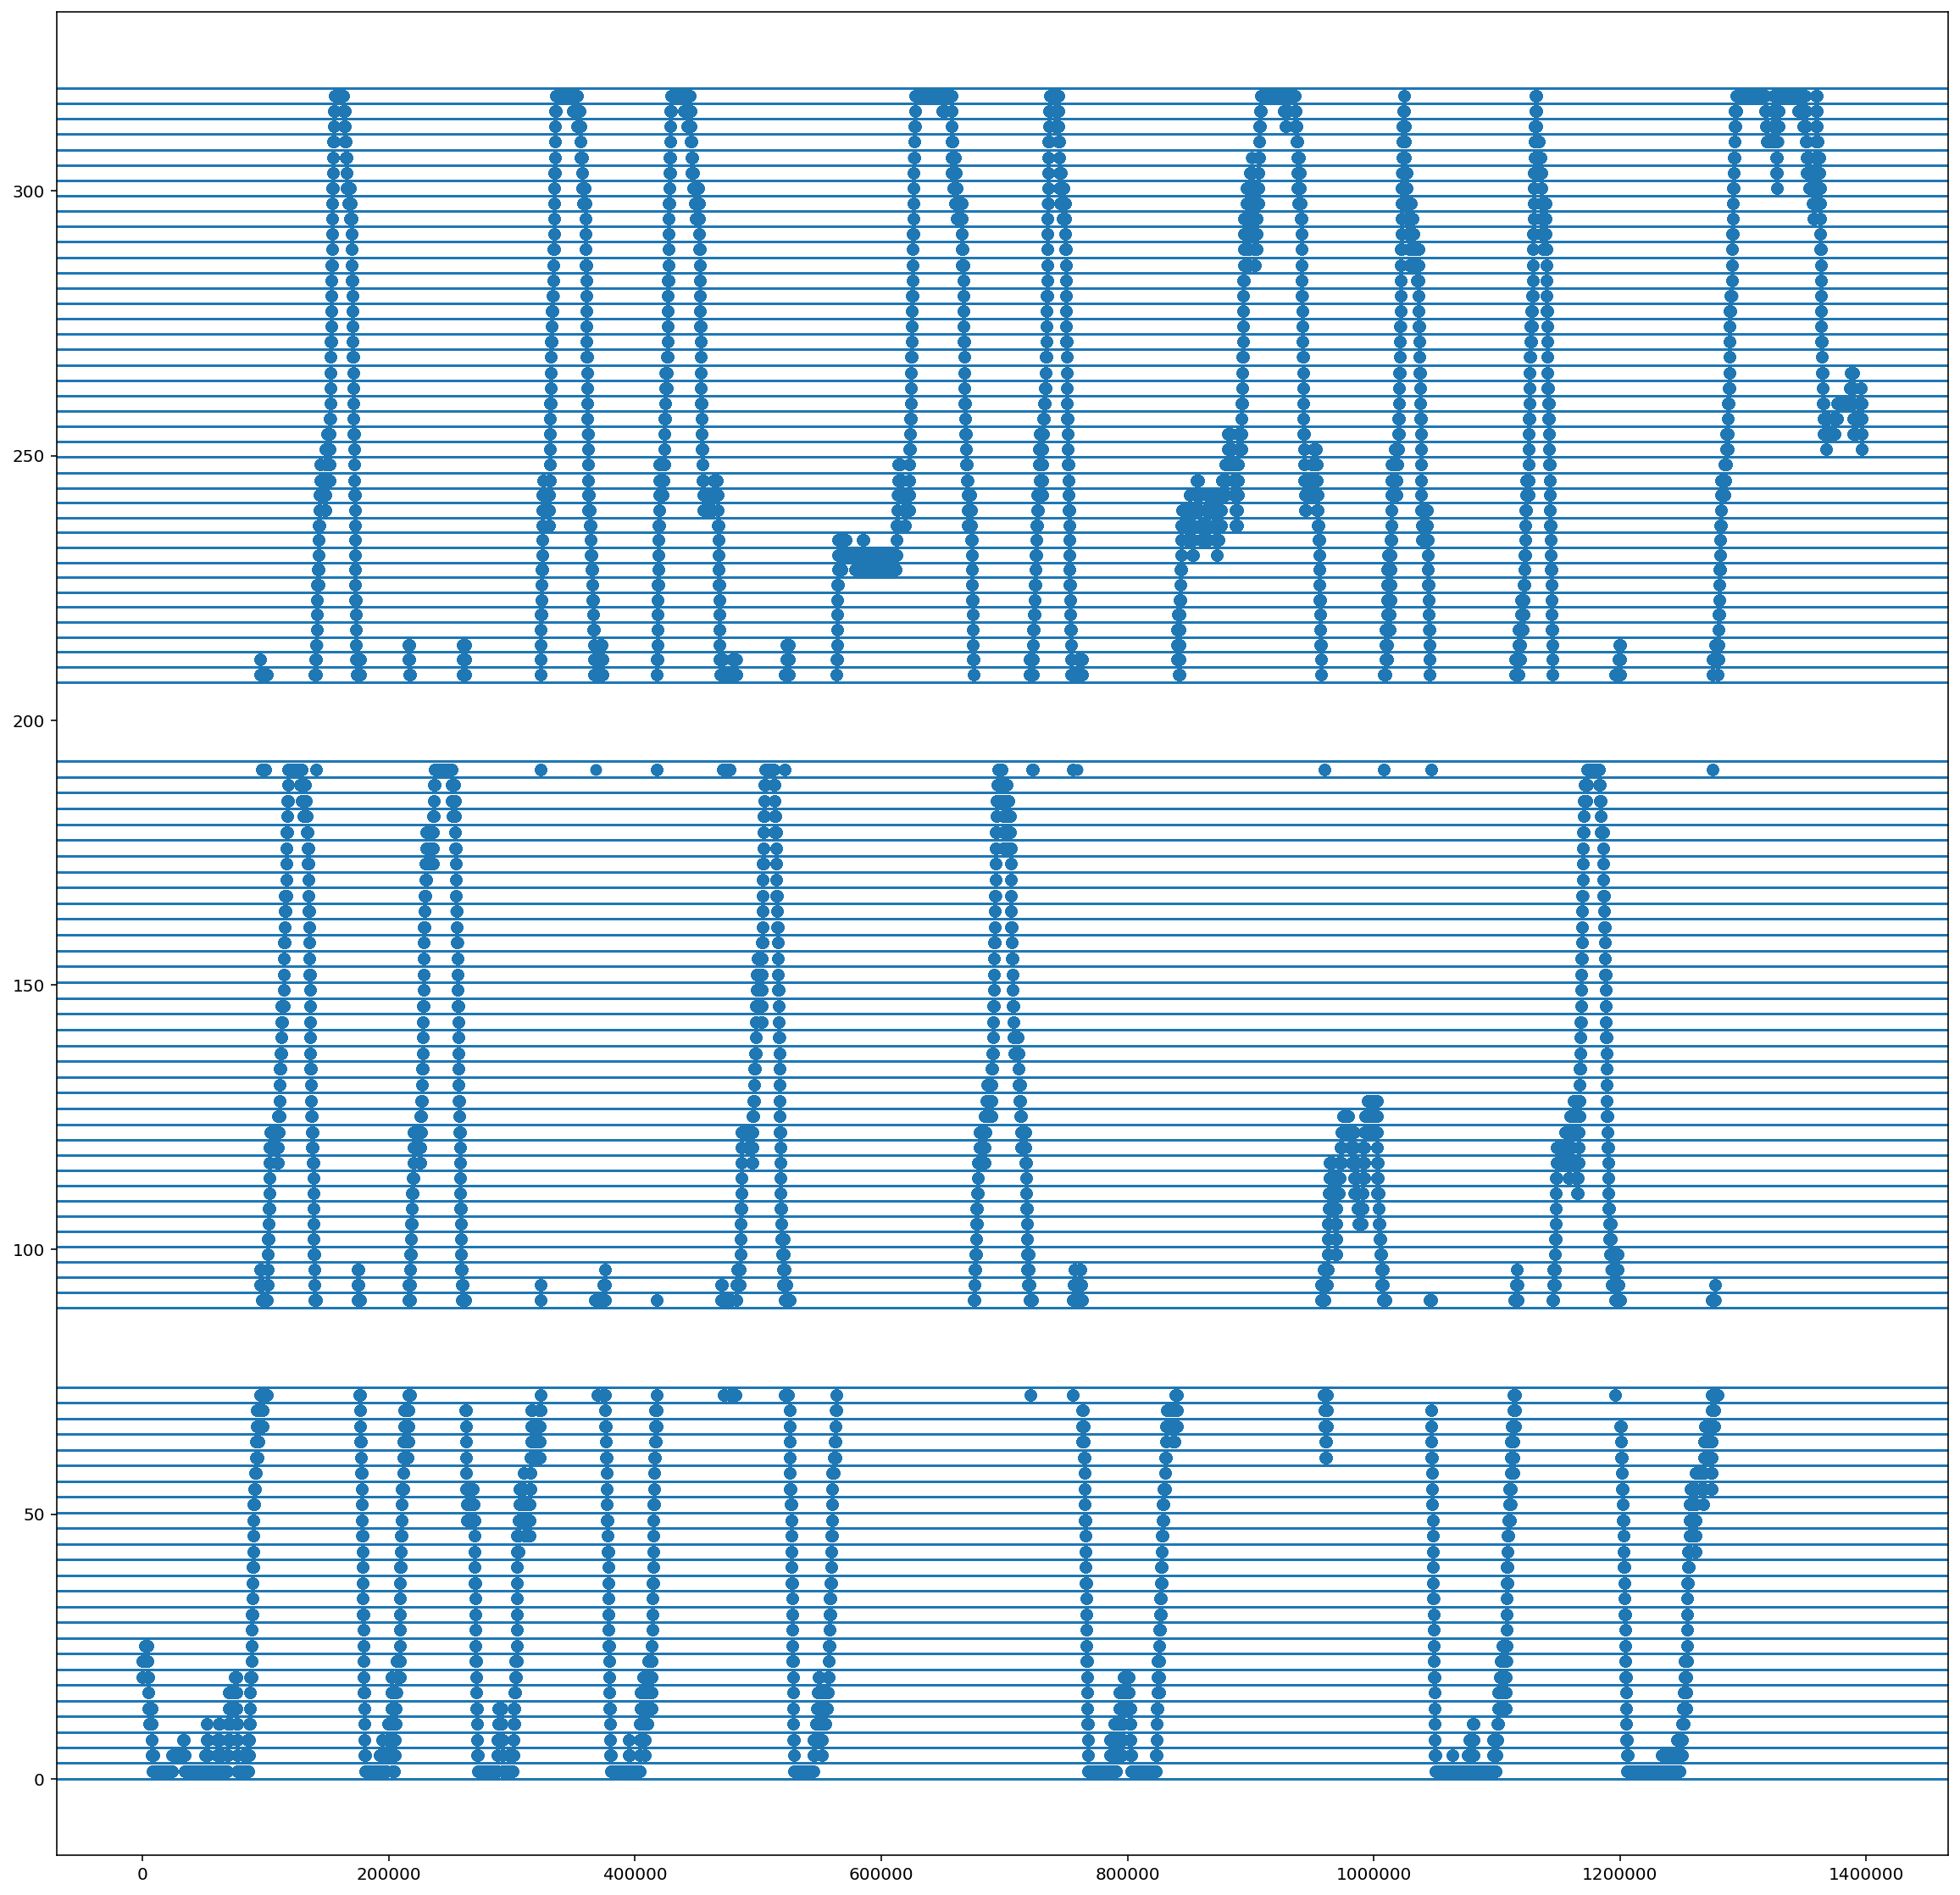

In [16]:
plt.figure(figsize=(20, 20))
plt.scatter(np.arange(position.shape[0]), detector.place_bin_centers_[bin_ind])

for e in detector.place_bin_edges_.squeeze():
    plt.axhline(e)

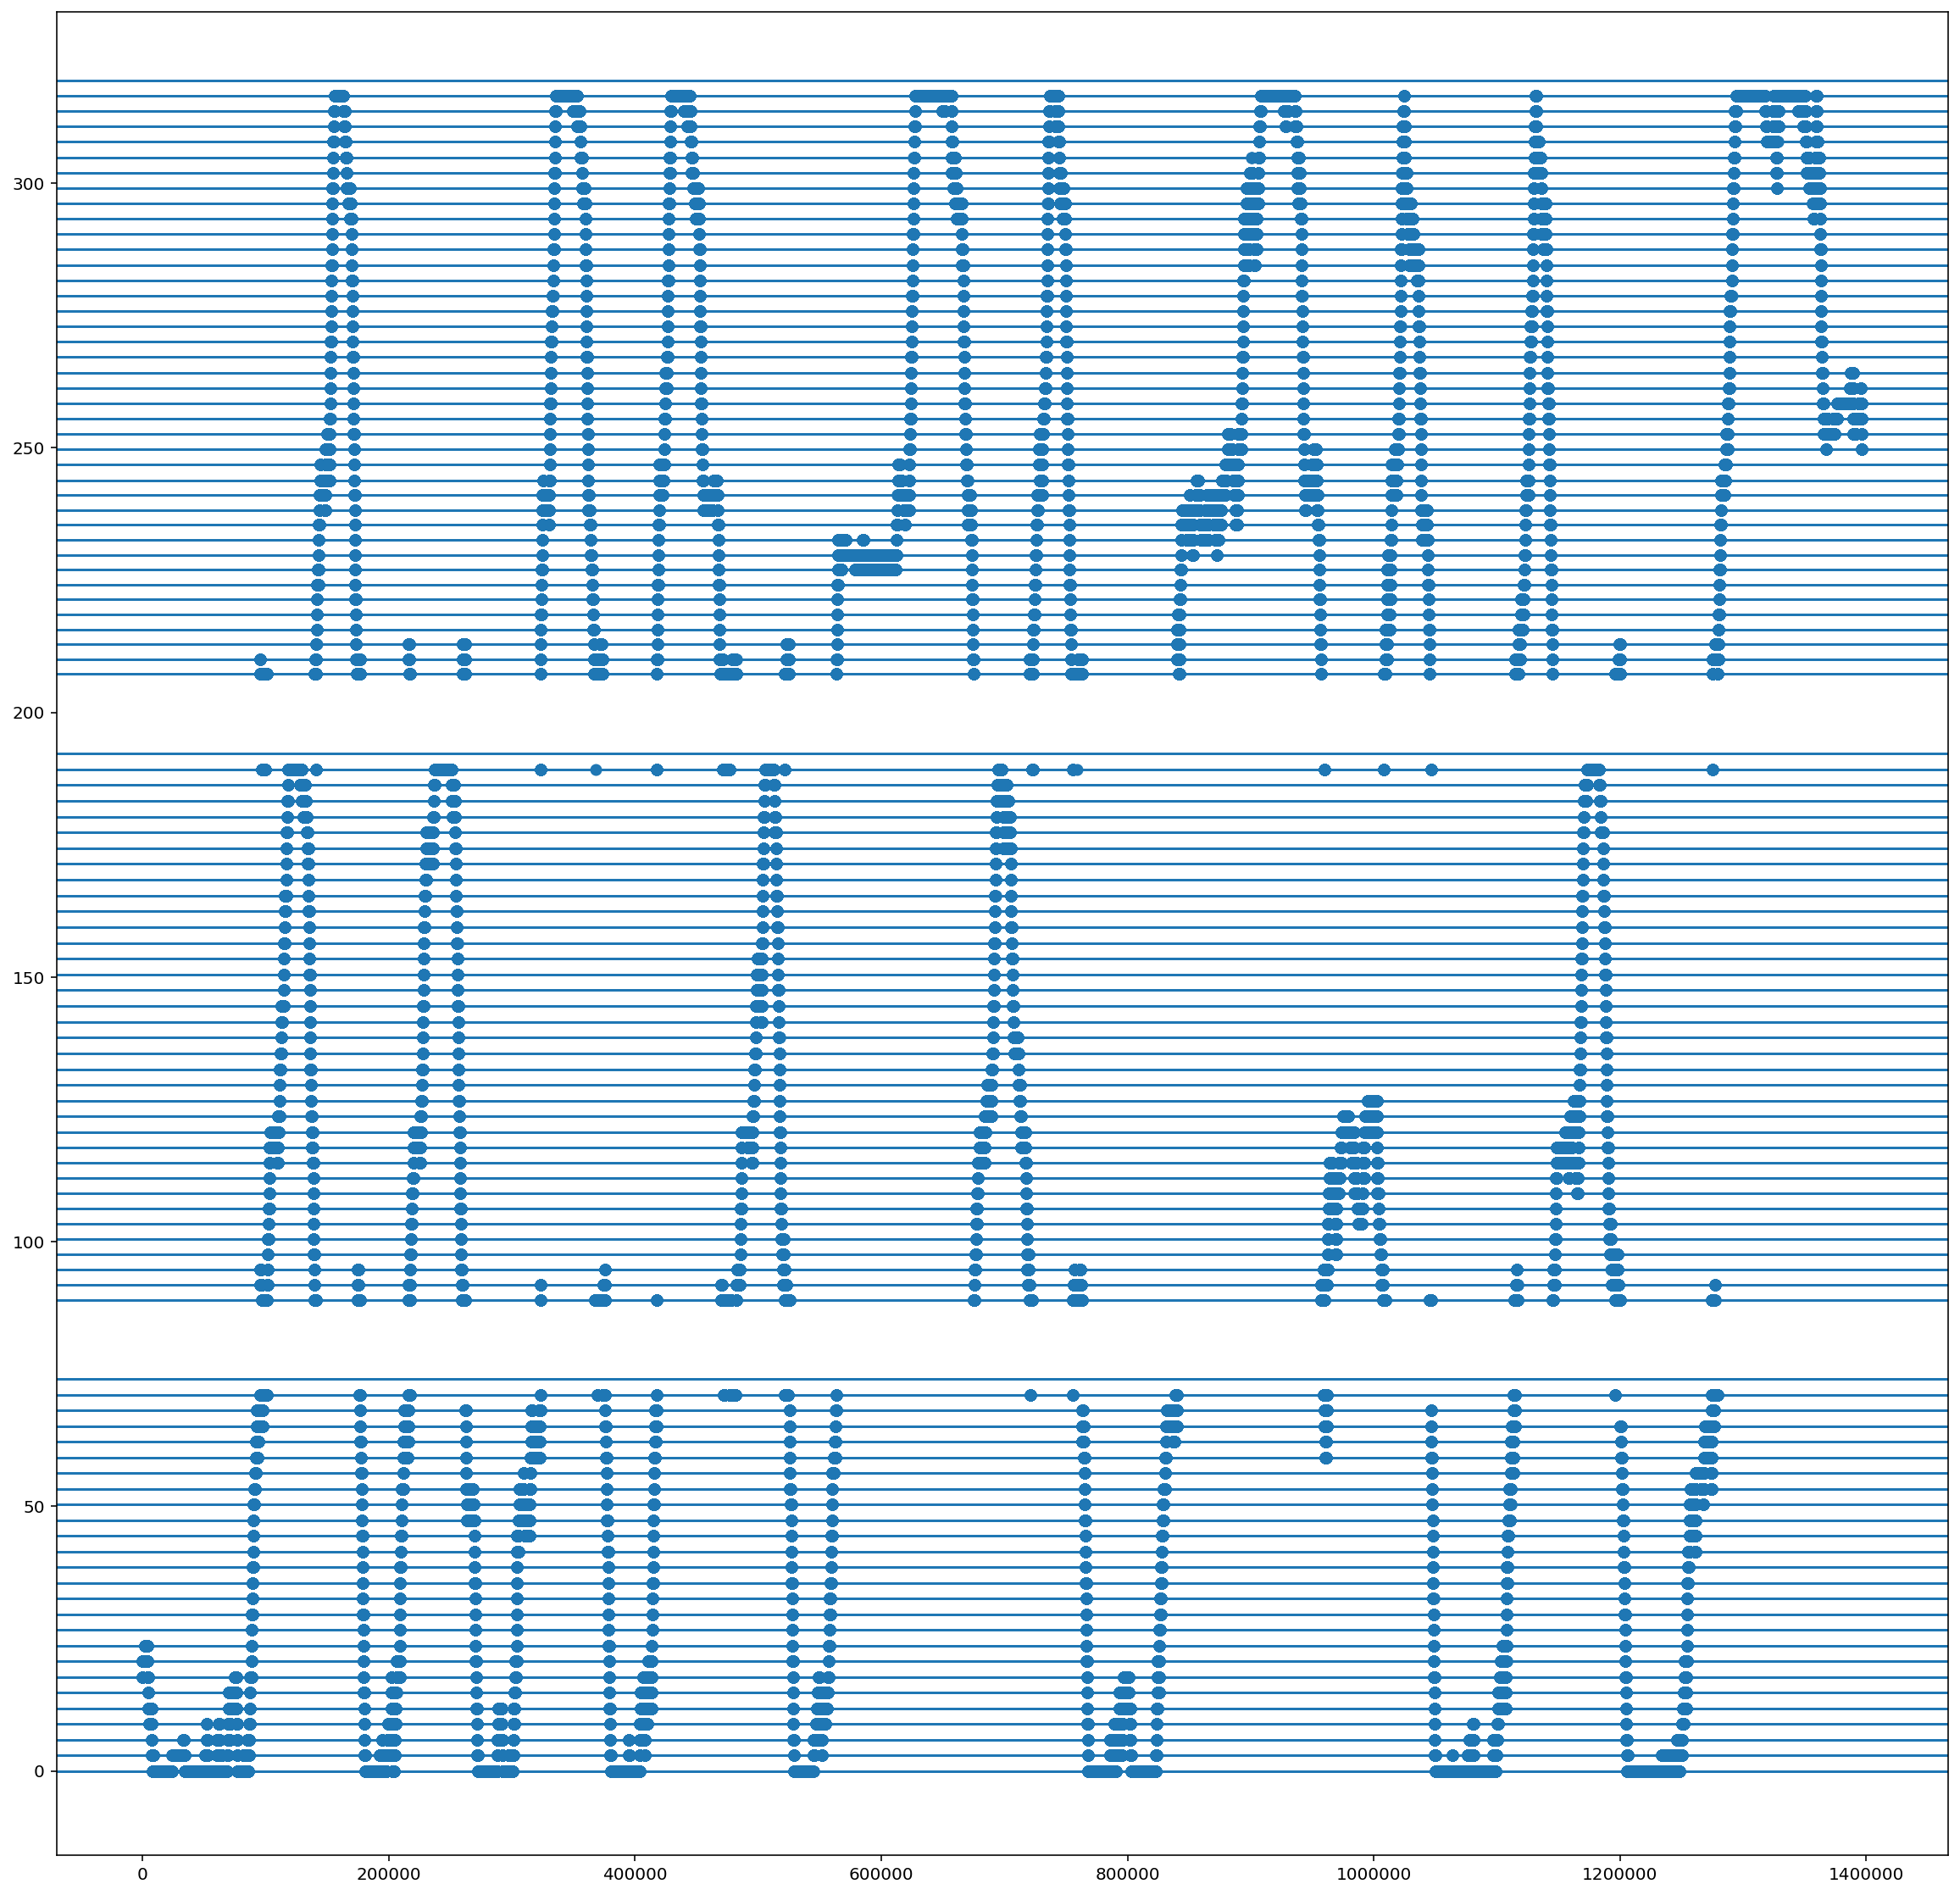

In [17]:
plt.figure(figsize=(20, 20))
plt.scatter(np.arange(position.shape[0]), detector.place_bin_edges_[bin_ind])

for e in detector.place_bin_edges_.squeeze():
    plt.axhline(e)

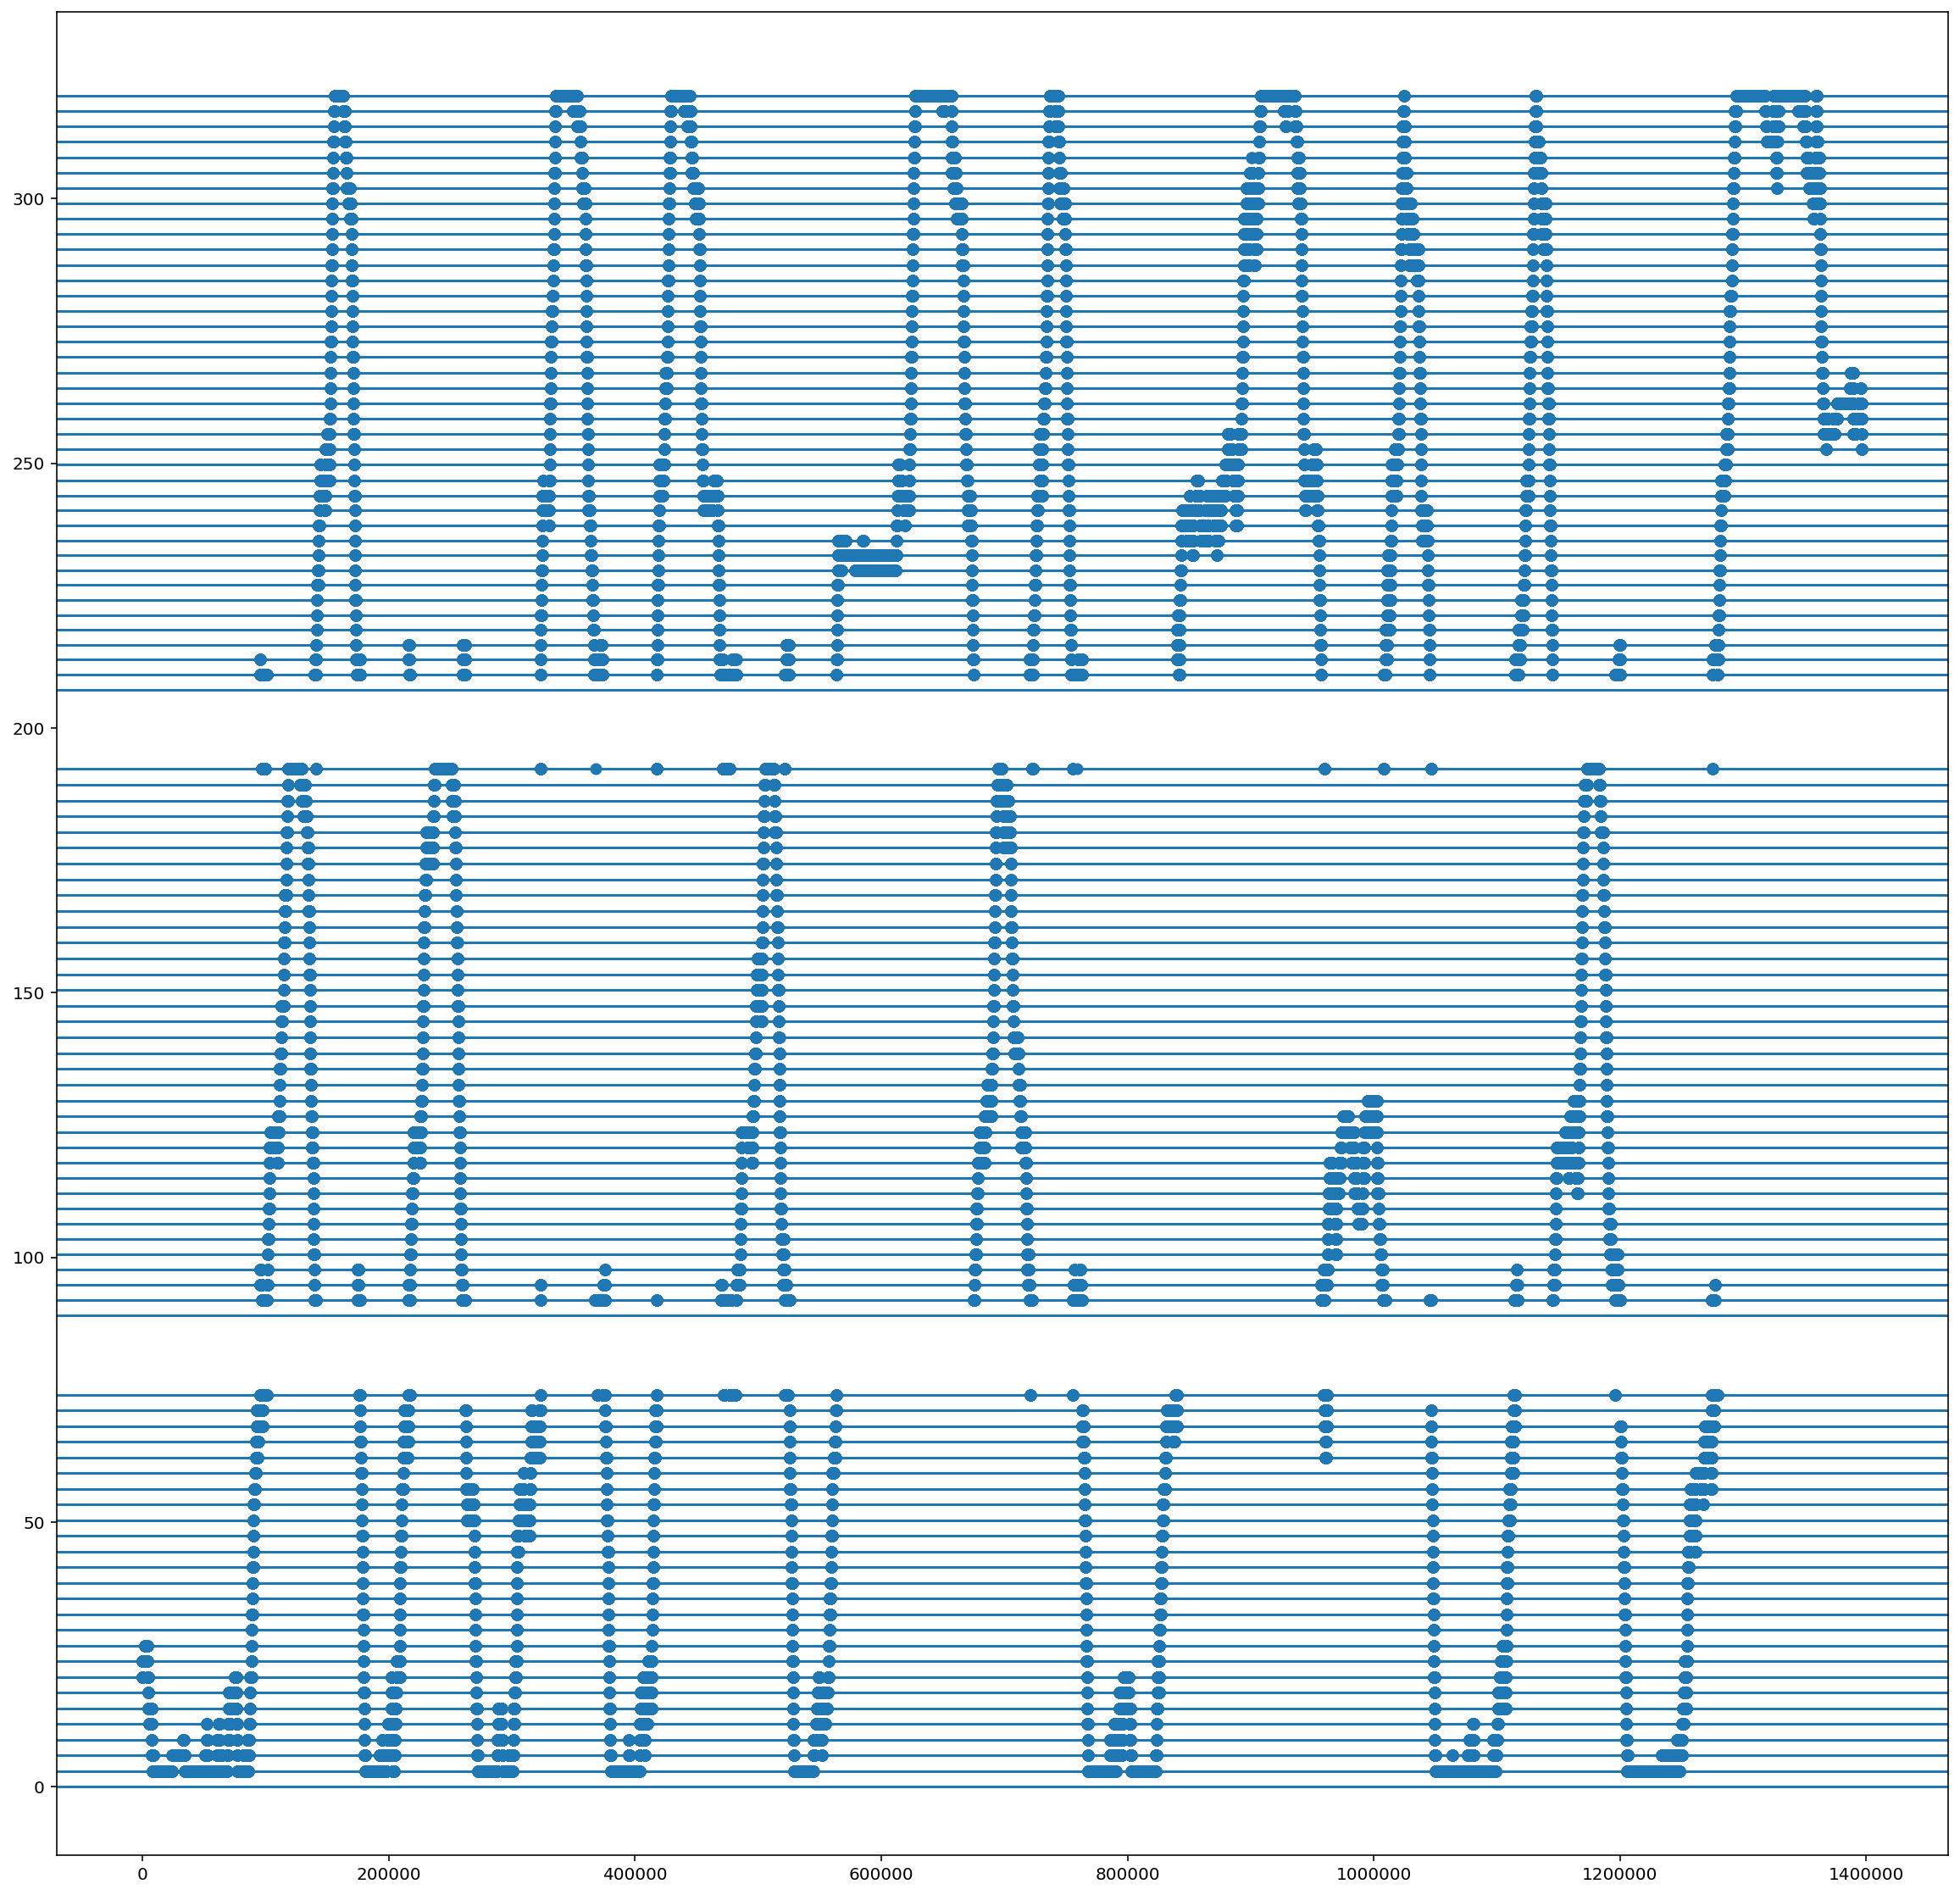

In [18]:
plt.figure(figsize=(20, 20))
plt.scatter(np.arange(position.shape[0]), detector.place_bin_edges_[bin_ind+1])

for e in detector.place_bin_edges_.squeeze():
    plt.axhline(e)

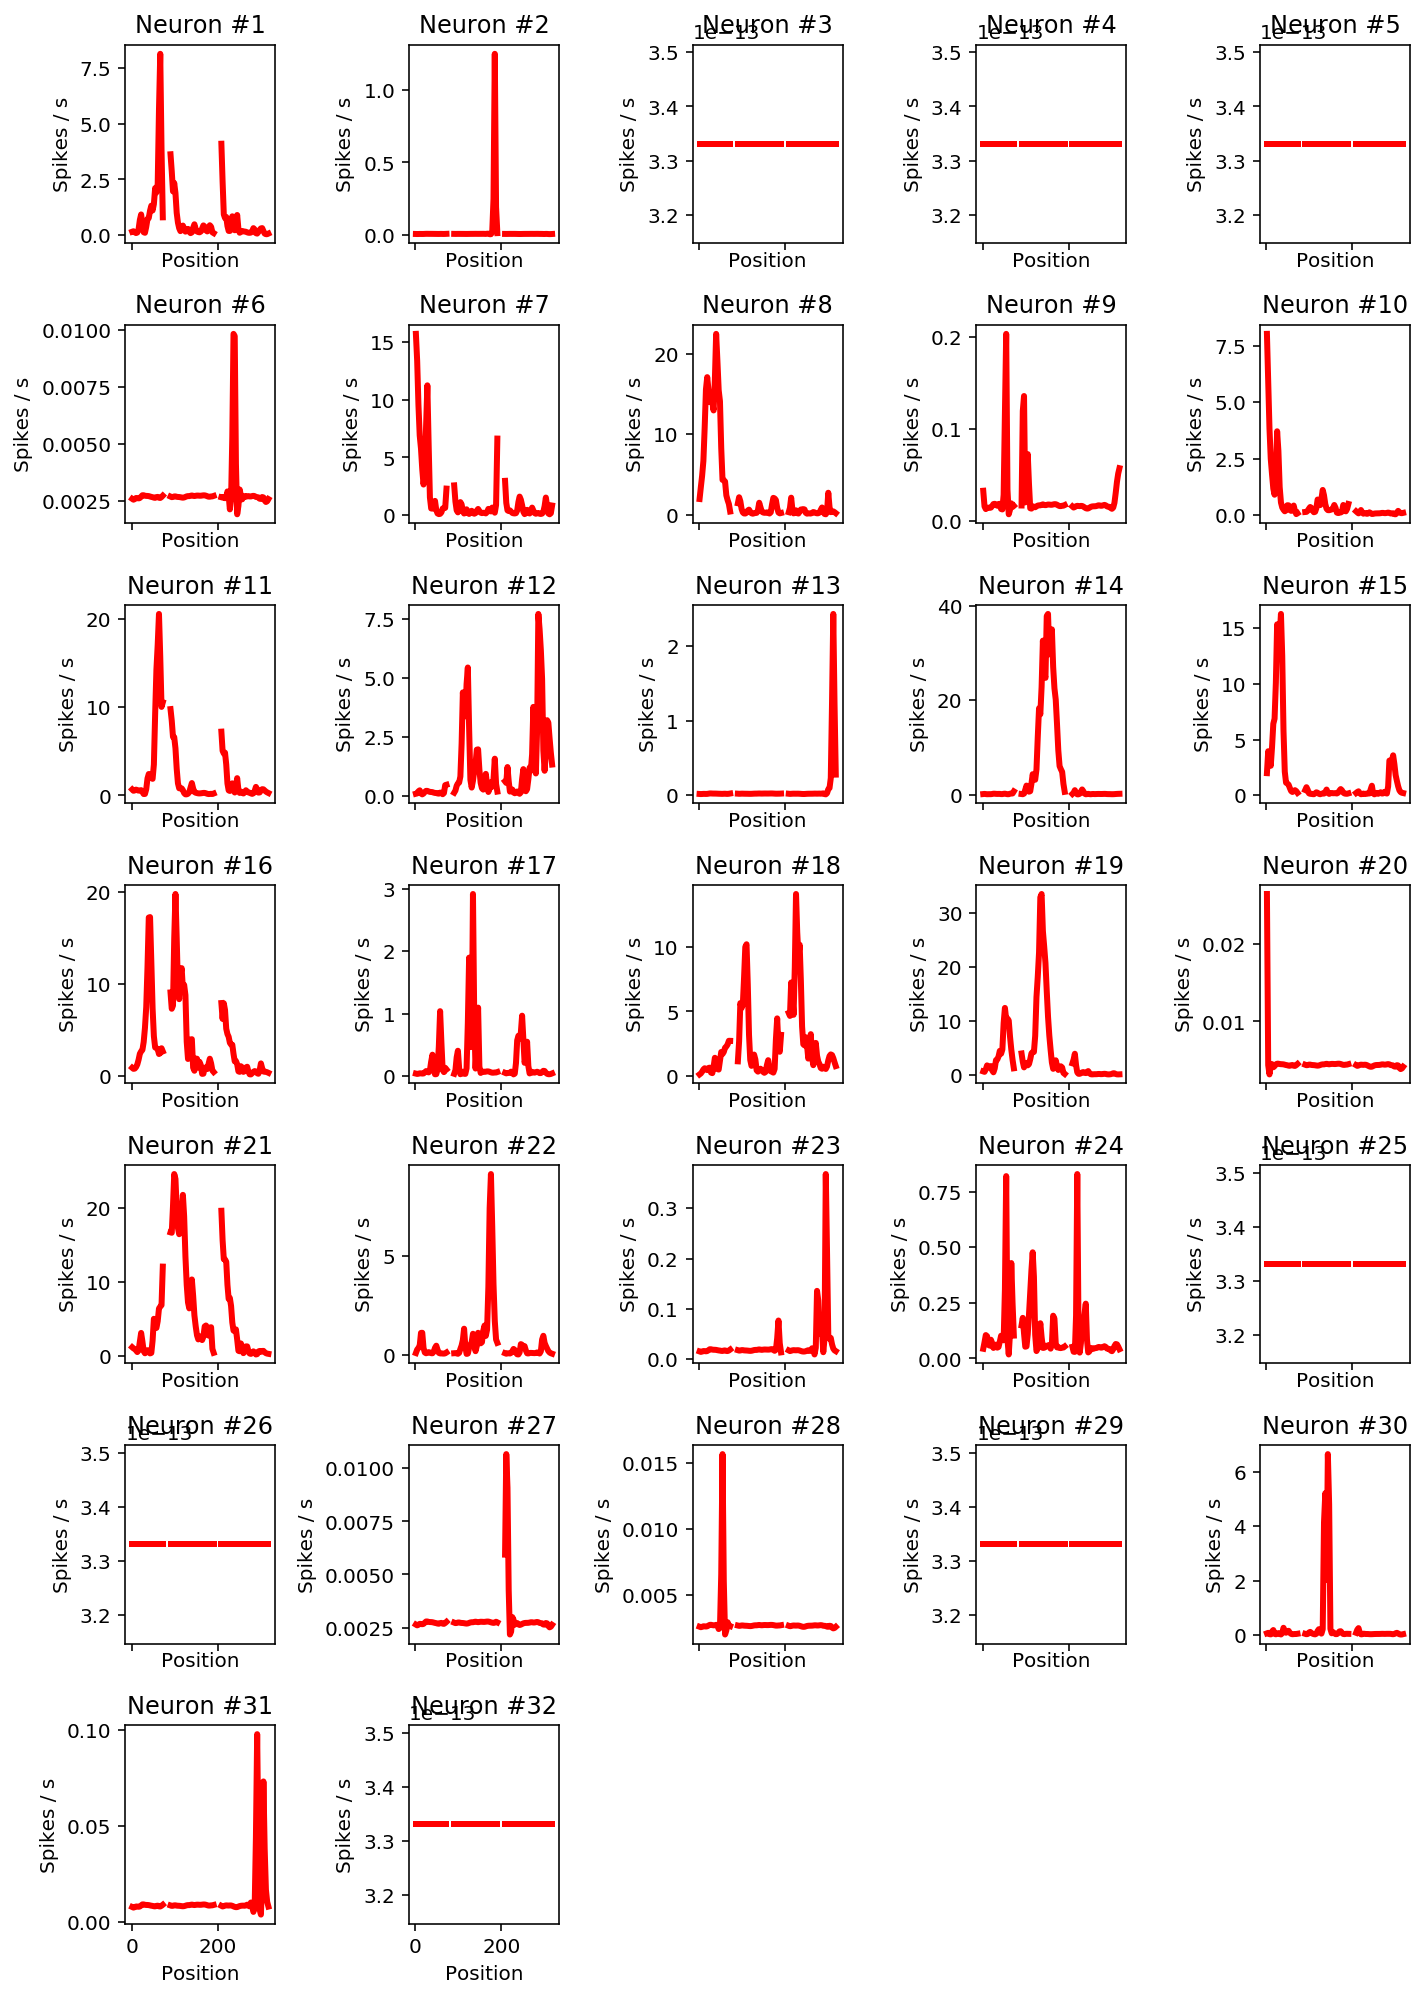

In [13]:
detector.plot_fitted_place_fields(sampling_frequency=sampling_frequency)

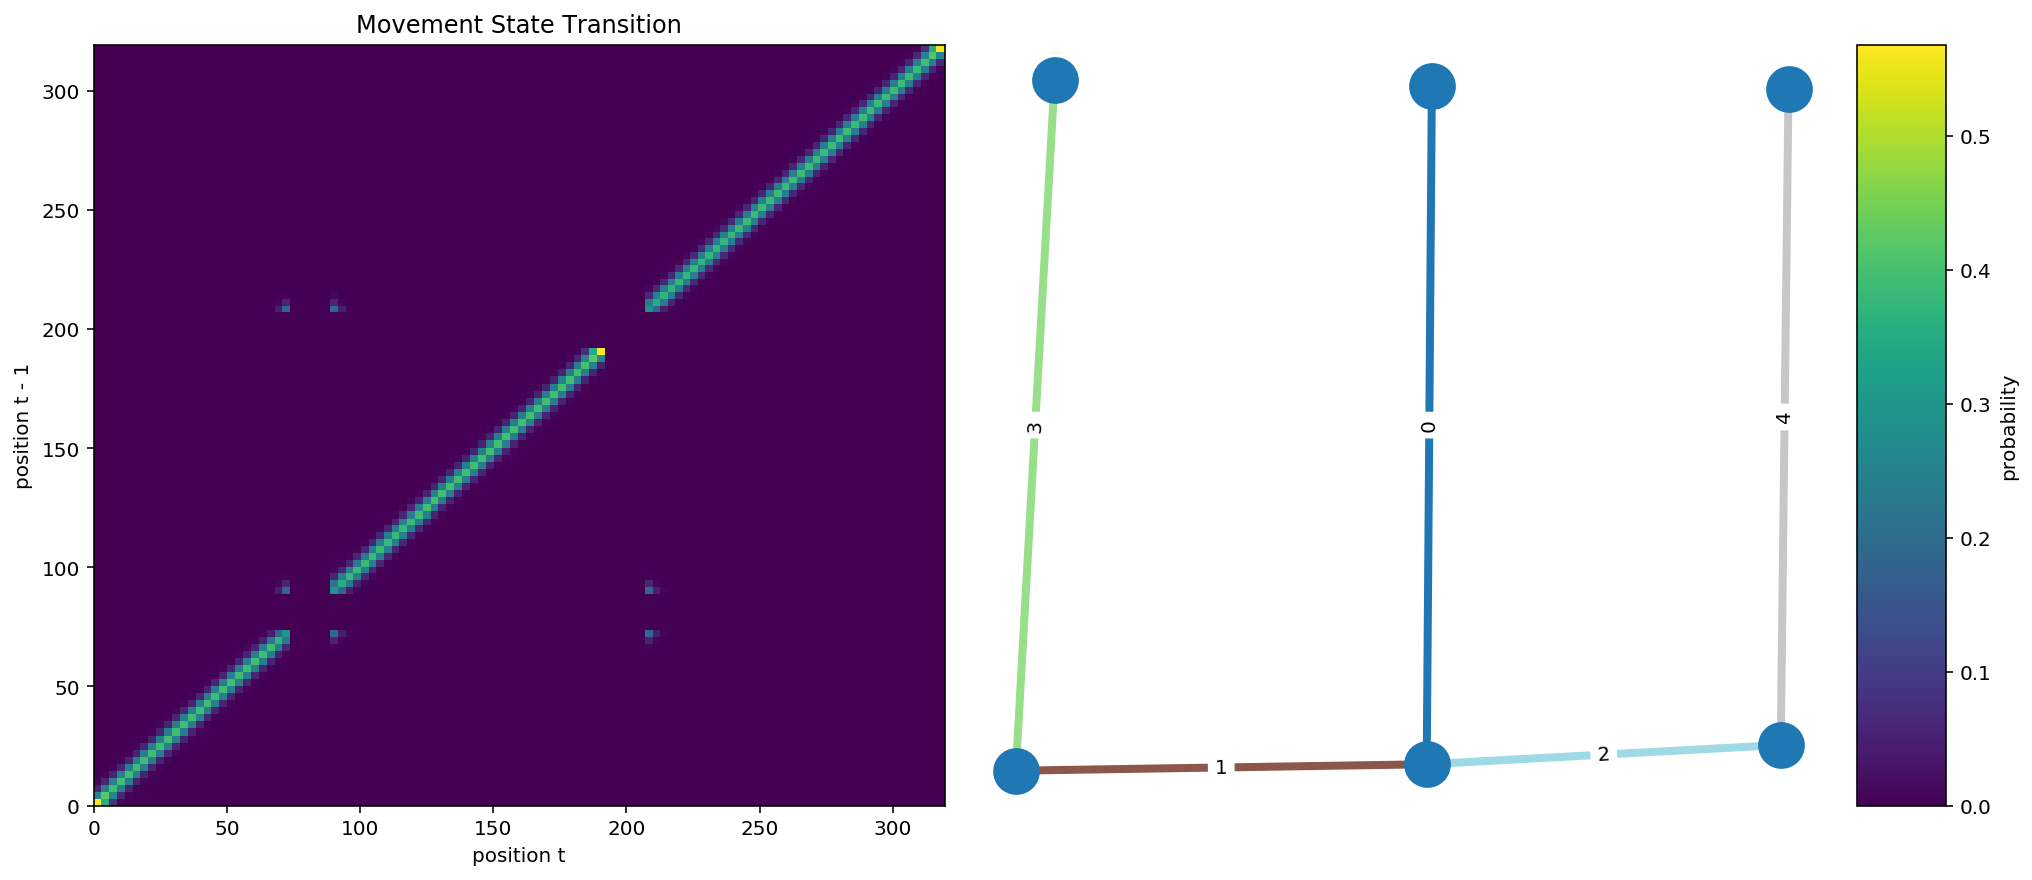

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
detector.plot_movement_state_transition(ax=axes[0], vmax_percent=100)

node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=axes[1],
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)
nx.draw_networkx_edge_labels(
    track_graph, node_position, ax=axes[1], edge_labels=edge_labels
)
plt.axis("off");

In [391]:
node_linear_position.shape

(5, 2)

In [45]:
# linear_position to 2D
from scipy.interpolate import interp1d
import networkx as nx

def linear_position_to_2D_projection(linear_position, node_linear_position, edge_dist, node_2D_position):
    try:
        is_node = np.isclose(linear_position, node_linear_position)
        edge_ind = np.where((
            (linear_position >= node_linear_position[:, 0]) | is_node[:, 0]) &
            ((linear_position <= node_linear_position[:, 1]) | is_node[:, 1])
        )[0][0]
    except IndexError:
        return np.full((1, 2), np.nan)
    pct_dist = (linear_position - node_linear_position[edge_ind][0]) / edge_dist[edge_ind]
    segment_diff = np.diff(node_2D_position, axis=1).squeeze()

    return node_2D_position[edge_ind, 0] + segment_diff[edge_ind] * pct_dist, edge_ind

x = node_linear_position[1, 1]
(x1, y1), edge_ind = linear_position_to_2D_projection(x, node_linear_position, edge_dist, node_2D_position)

fig, ax = plt.subplots()
node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=ax,
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)
nx.draw_networkx_edge_labels(
    track_graph, node_position, ax=ax, edge_labels=edge_labels
)
plt.axis("off");
plt.scatter(x1, y1, color='black', s=100, zorder=100)

NameError: name 'node_linear_position' is not defined

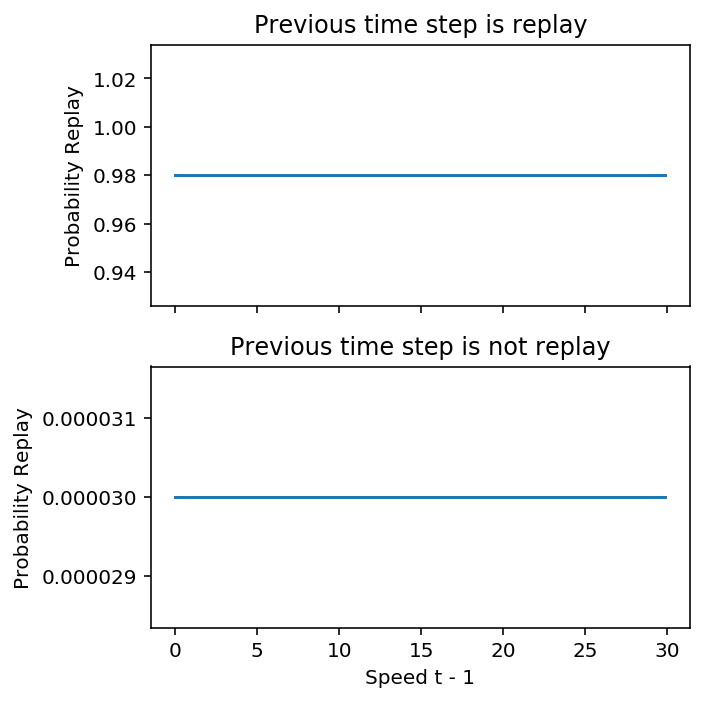

In [28]:
detector.plot_replay_state_transition()

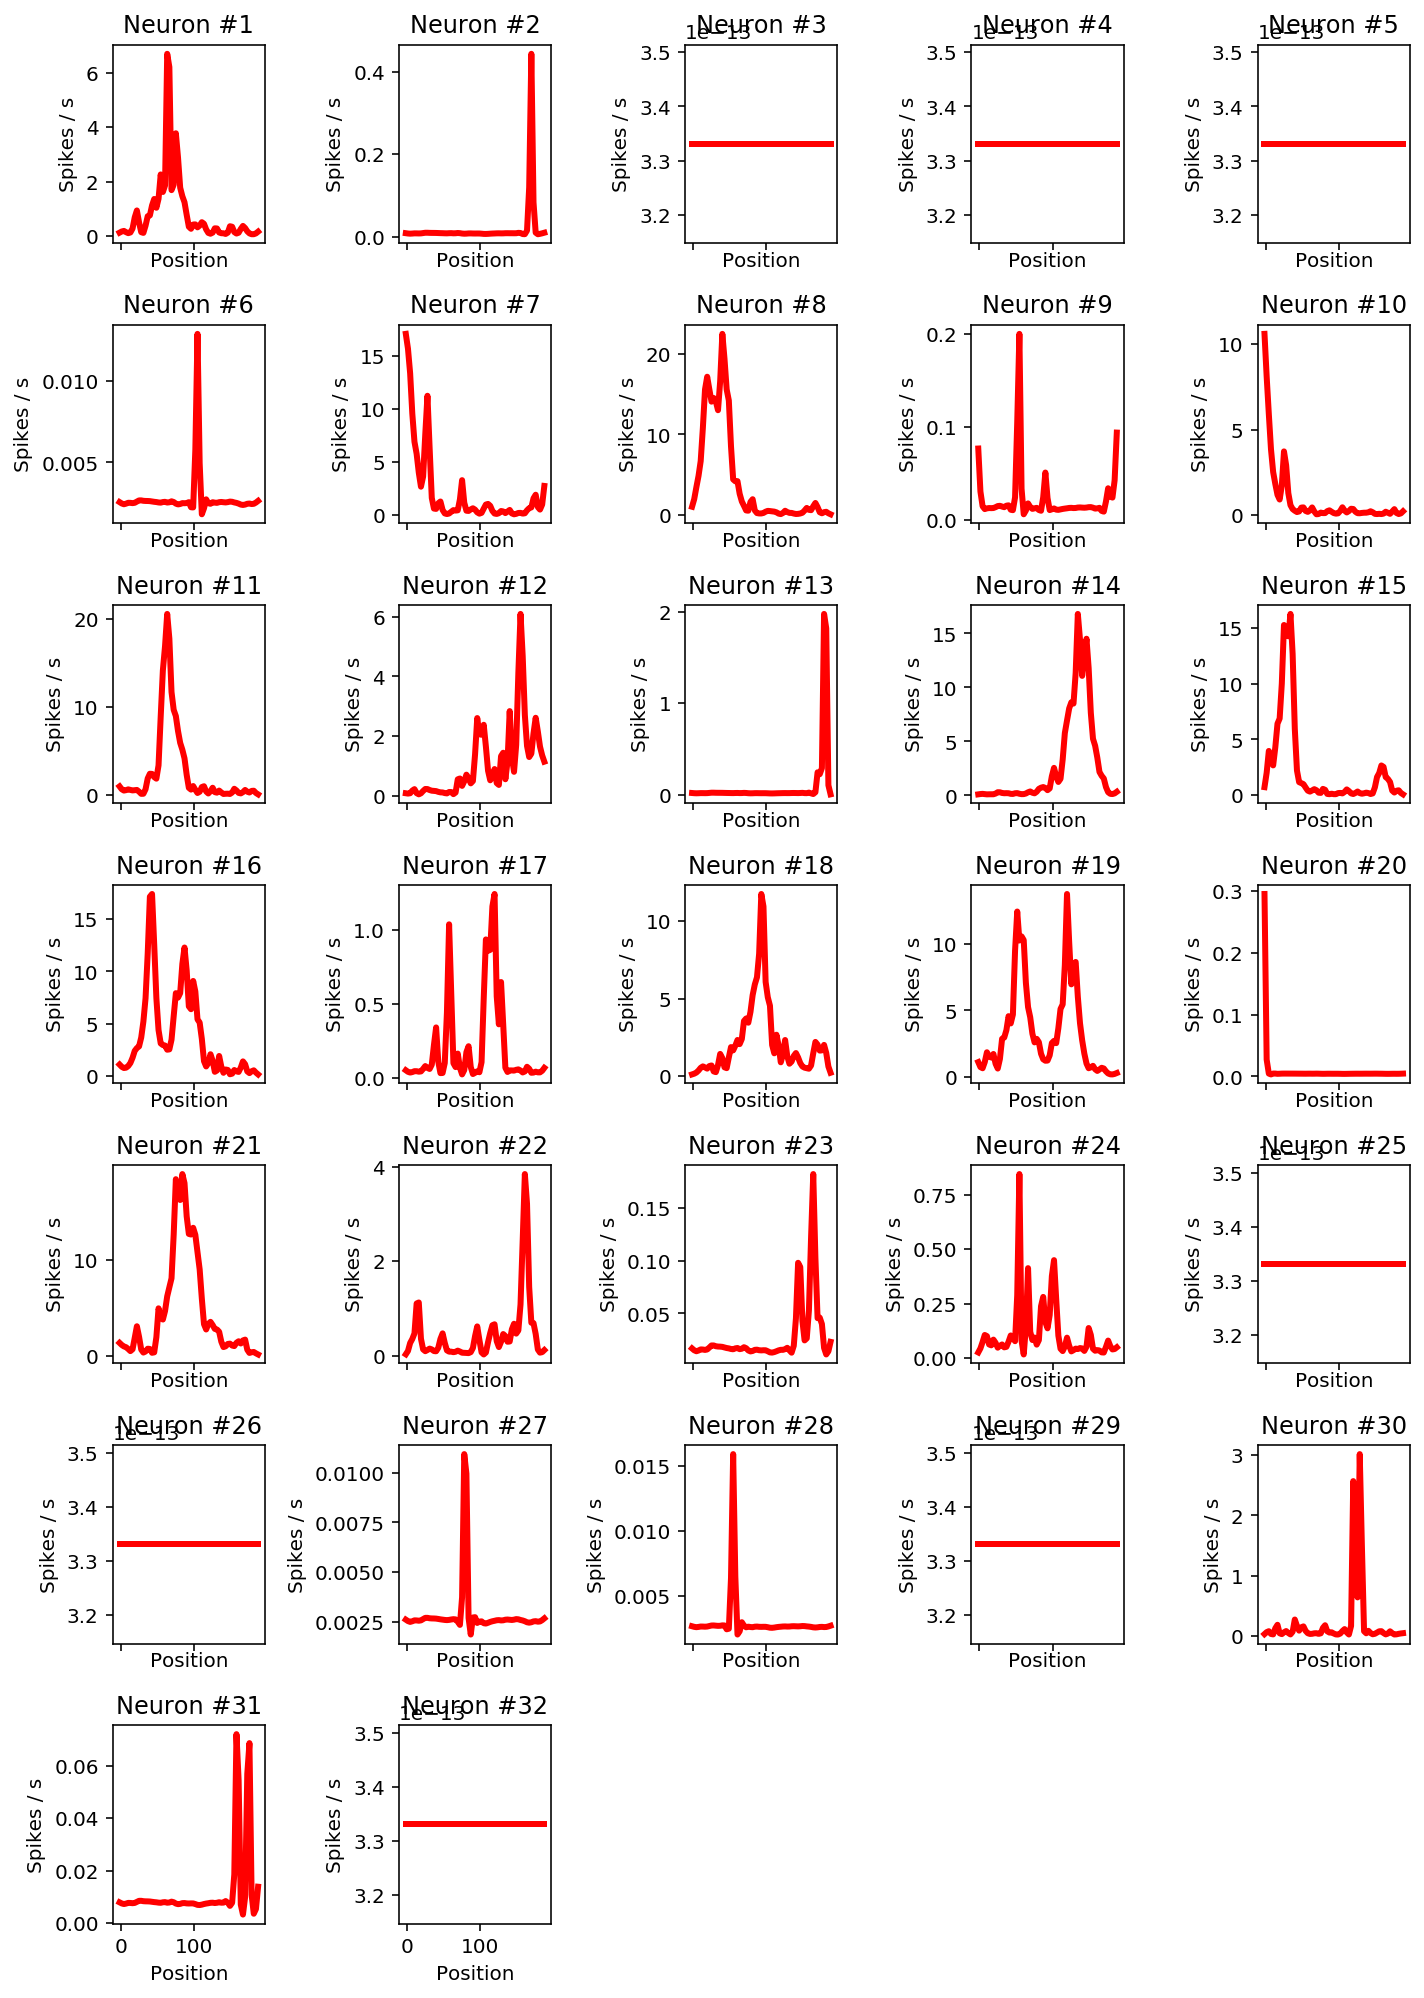

In [29]:
detector.plot_fitted_place_fields(sampling_frequency=sampling_frequency)

In [218]:
# from replay_identification.movement_state_transition  import empirical_movement

# detector.movement_state_transition_ = empirical_movement(
#     data['position_info'][position_metric].values, detector.edges_, ~data['is_ripple'].values.squeeze(),
#     2000)

INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


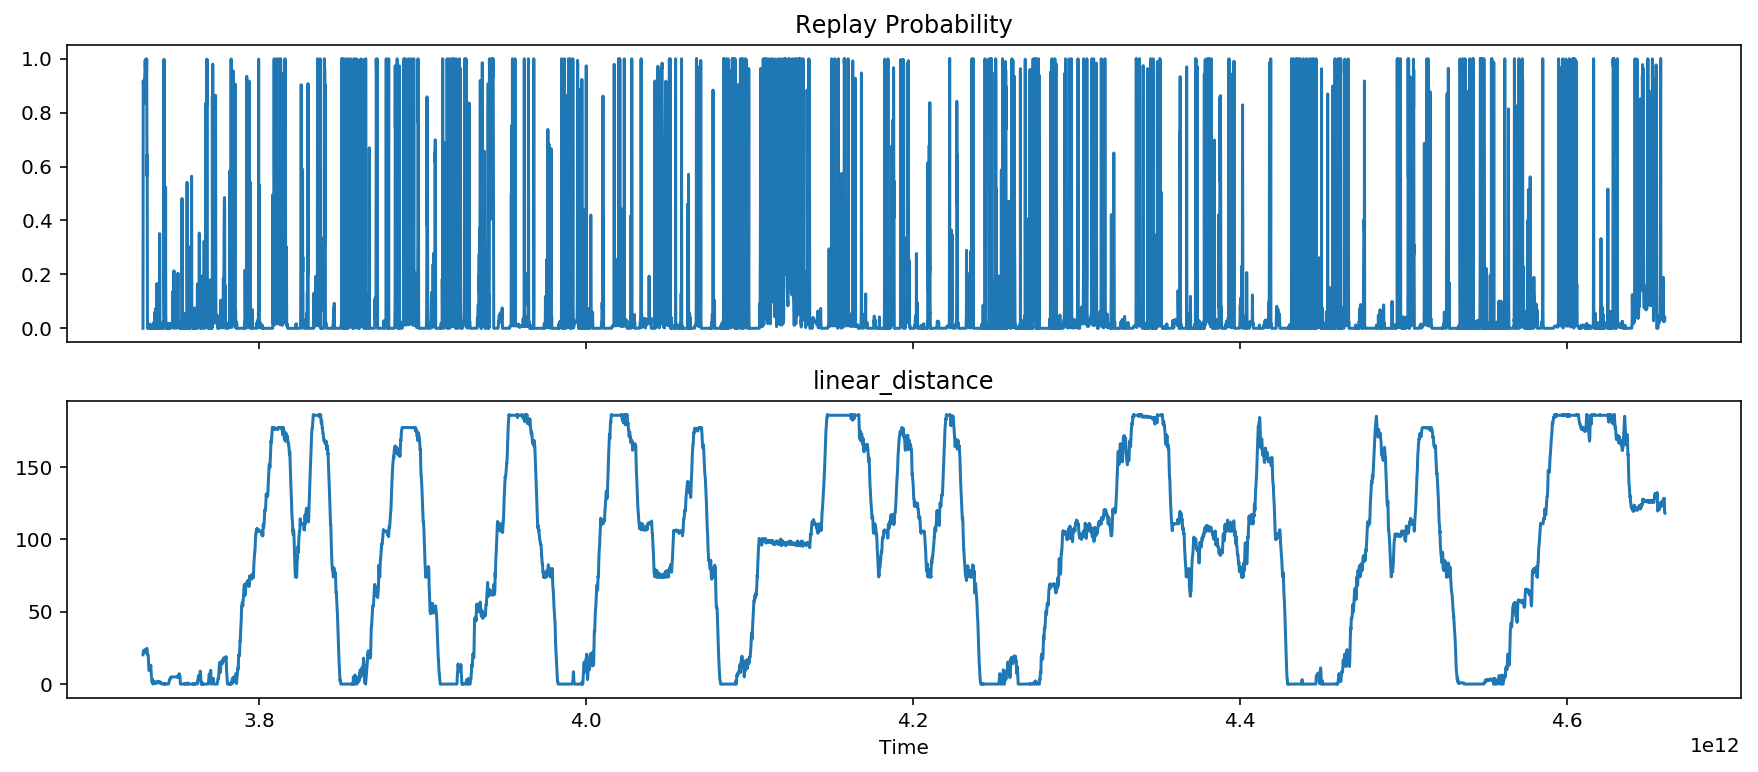

In [242]:
results_spikes = detector.predict(
    speed=data['position_info'][speed_metric],
    position=data['position_info'][position_metric],
    lfp_power=data['power'],
    spikes=data['spikes'], multiunit=data['multiunit'],
    time=data['position_info'].index,
    use_likelihoods=['spikes'],
    use_smoother=True)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results_spikes.time, results_spikes.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(results_spikes.time, data['position_info'][position_metric])
axes[1].set_title(position_metric)
axes[-1].set_xlabel('Time');

In [199]:
replay_times, labels = get_replay_times(results_spikes)

In [243]:
from ipywidgets import interact
import matplotlib.colors as colors

@interact(replay_number=(data['ripple_times'].index[0], data['ripple_times'].index[-1]))
def plot_replay(replay_number=34):
    time_slice = slice(data['ripple_times'].loc[replay_number].start_time - pd.Timedelta(0.250, 's'),
                       data['ripple_times'].loc[replay_number].end_time + pd.Timedelta(0.250, 's'))

    results = (results_spikes
     .sel(time=time_slice)
     .assign_coords(time=lambda ds: ds.time / np.timedelta64(1, 's')))

    fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True, figsize=(12, 8))
    results.replay_probability.plot(x='time', ax=axes[0], linewidth=3)

    axes[0].axhline(0.8, color='red', linestyle='--')

    (results
     .isel(state=1)
     .posterior.plot(x='time', y='position', ax=axes[1], robust=True))

    axes[1].plot(results.time, data['position_info'][position_metric].loc[time_slice].values,
                 color='white', linestyle='--')
    
    ((results.sel(state='Replay') / results.sel(state='No Replay'))
     .likelihood.plot(x='time', y='position', ax=axes[2],
                      center=1,
                      norm=colors.LogNorm(vmin=1/5, vmax=5.0)))

    place_fields = (detector
                    ._spiking_likelihood
                    .keywords['place_conditional_intensity'].T
                    * sampling_frequency)
    spikes = data['spikes'].loc[time_slice]
    plot_replay_spiking_ordered_by_place_fields(
        spikes.values, place_fields, detector.place_bin_centers_.squeeze(), ax=axes[3],
        time=results.time)

interactive(children=(IntSlider(value=34, description='replay_number', max=359, min=1), Output()), _dom_classe…

In [19]:
is_spike = np.any(~np.isnan(data['multiunit'].isel(tetrodes=10).values), axis=1)
is_spike

array([False, False, False, ..., False, False, False])

In [21]:
linear_position = data['position_info'].linear_position.values
linear_pos_at_spike = linear_position[is_spike]

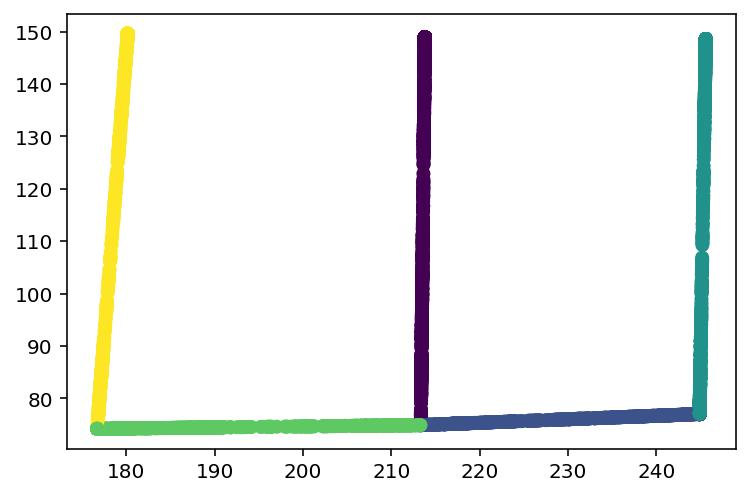

In [22]:
from replay_identification.core import linear_position_to_2D_projection, get_graph_1D_2D_relationships

node_linear_position, edges, node_2D_position, edge_dist = get_graph_1D_2D_relationships(
    track_graph, edge_order, edge_spacing, center_well_id)

spike_2D_position = [linear_position_to_2D_projection(p, node_linear_position, edge_dist, node_2D_position)
                     for p in linear_position[is_spike]]
spike_2D_position, edge_id = zip(*spike_2D_position)
edge_id = np.array(edge_id)
spike_2D_position = np.array(spike_2D_position)

plt.scatter(spike_2D_position[:, 0], spike_2D_position[:, 1], c=edge_id)

In [7]:
import dask.bag as db
import dask
from loren_frank_data_processing.track_segment_classification import (
    get_track_segments_from_graph, project_points_to_segment, route_distance)
from loren_frank_data_processing.position import make_track_graph

position = data['position_info'].loc[:, ['x_position', 'y_position']].values
track_graph, center_well_id = make_track_graph(epoch_key, animals)
track_segments = get_track_segments_from_graph(track_graph)
projected_track_position = project_points_to_segment(
    track_segments, position)

In [ ]:
# search sorted into place bins
# move the ones that fall in the non-track
# add to graph
# single source dijikstra

In [115]:
from replay_identification.core import get_observed_position_bin

bin_ind = get_observed_position_bin(linear_pos_at_spike, detector.place_bin_edges_, detector.is_track_interior_)
bin_ind

array([ 6,  7,  7, ..., 79, 79, 77])

In [116]:
detector.place_bin_centers_[bin_ind]

array([[ 19.2494957 ],
       [ 22.21095657],
       [ 22.21095657],
       ...,
       [256.96879284],
       [256.96879284],
       [251.1597368 ]])

In [60]:

detector.place_bin_edges_[bin_ind[0]], linear_pos_at_spike[0], detector.place_bin_edges_[bin_ind[0]+1]

(array([17.76876526]), 20.660934360047307, array([20.73022614]))

In [53]:
np.nonzero(~np.array([(detector.place_bin_edges_[b] <= l) & (detector.place_bin_edges_[b+1] >= l)
           for l, b in zip(linear_pos_at_spike, bin_ind)]))

(array([ 714,  715,  716,  873, 1701, 2910, 2911, 3515, 3516, 3517, 3526,
        3941]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [57]:
i = 714
detector.place_bin_edges_[bin_ind[i]], linear_pos_at_spike[i], detector.place_bin_edges_[bin_ind[i]+1]

(array([71.07506104]), 74.17749393234976, array([74.03652192]))

In [56]:
detector.place_bin_edges_[bin_ind[i]]

array([71.07506104])

In [68]:
np.searchsorted?

Signature: np.searchsorted(a, v, side='left', sorter=None)
Docstring:
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : array_like
    Values to insert into `a`.
side : {'left', 'right'}, optional
    If 'left', the index of the first suitable location found is given.
    If 'right', return the last such index.  If there is no suitable
    index, return either 0 or N (where N is the 

In [120]:
is_track_interior = detector.is_track_interior_
bin_edges = detector.place_bin_edges_.squeeze()


bin_ind = np.searchsorted(bin_edges, linear_pos_at_spike, side='left')
not_track_bin = np.nonzero(~is_track_interior)[0] + 1
not_track_bin = np.append(not_track_bin, 0)
for bin in not_track_bin:
    bin_ind[bin_ind == bin] = bin + 1

In [123]:
np.nonzero(~is_track_interior)

(array([25, 61]),)

In [126]:
detector.place_bin_centers_[bin_ind-1]

array([[ 19.2494957 ],
       [ 22.21095657],
       [ 22.21095657],
       ...,
       [256.96879284],
       [256.96879284],
       [251.1597368 ]])

In [114]:
bin_edges.shape

(102,)

In [110]:
np.append?

Signature: np.append(arr, values, axis=None)
Docstring:
Append values to the end of an array.

Parameters
----------
arr : array_like
    Values are appended to a copy of this array.
values : array_like
    These values are appended to a copy of `arr`.  It must be of the
    correct shape (the same shape as `arr`, excluding `axis`).  If
    `axis` is not specified, `values` can be any shape and will be
    flattened before use.
axis : int, optional
    The axis along which `values` are appended.  If `axis` is not
    given, both `arr` and `values` are flattened before use.

Returns
-------
append : ndarray
    A copy of `arr` with `values` appended to `axis`.  Note that
    `append` does not occur in-place: a new array is allocated and
    filled.  If `axis` is None, `out` is a flattened array.

See Also
--------
insert : Insert elements into an array.
delete : Delete elements from an array.

Examples
--------
>>> np.append([1, 2, 3], [[4, 5, 6], [7, 8, 9]])
array([1, 2, 3, ..., 7, 8, 

In [80]:
np.nonzero(~np.array([(detector.place_bin_edges_[b] <= l) & (detector.place_bin_edges_[b+1] >= l)
                      for l, b in zip(linear_pos_at_spike, bin_ind)]))

IndexError: index 102 is out of bounds for axis 0 with size 102

In [67]:
detector.place_bin_edges_.size

102

In [74]:
bin_edges.size

102

In [75]:
not_track_bin

array([ 25,  61, 102])

In [77]:
bin_ind[bin_ind == bin]

array([], dtype=int64)

In [130]:
is_track_interior = detector.is_track_interior_
bin_edges = detector.place_bin_edges_.squeeze()


bin_ind = np.searchsorted(bin_edges, linear_pos_at_spike, side='left')
not_track_bin = np.nonzero(~is_track_interior)[0] + 1
not_track_bin = np.append(not_track_bin, 0)
for bin in not_track_bin:
    bin_ind[bin_ind == bin] = bin + 1

In [154]:
i = 27

start, end = (detector.place_bin_edges_[i-1].item(), detector.place_bin_edges_[i].item())

print((start, linear_pos_at_spike[bin_ind == i].min(), linear_pos_at_spike[bin_ind == i].max(), end))
print(start <= linear_pos_at_spike[bin_ind == i].min() <= end)
print(start <= linear_pos_at_spike[bin_ind == i].max() <= end)

(89.03652191604655, 74.17749393234976, 91.88475827843881, 91.9126078055971)
False
True


In [89]:
detector.place_bin_edges_

array([[  0.        ],
       [  2.96146088],
       [  5.92292175],
       [  8.88438263],
       [ 11.84584351],
       [ 14.80730438],
       [ 17.76876526],
       [ 20.73022614],
       [ 23.69168701],
       [ 26.65314789],
       [ 29.61460877],
       [ 32.57606964],
       [ 35.53753052],
       [ 38.4989914 ],
       [ 41.46045227],
       [ 44.42191315],
       [ 47.38337403],
       [ 50.3448349 ],
       [ 53.30629578],
       [ 56.26775666],
       [ 59.22921753],
       [ 62.19067841],
       [ 65.15213929],
       [ 68.11360016],
       [ 71.07506104],
       [ 74.03652192],
       [ 89.03652192],
       [ 91.91260781],
       [ 94.7886937 ],
       [ 97.66477958],
       [100.54086547],
       [103.41695136],
       [106.29303725],
       [109.16912314],
       [112.04520903],
       [114.92129492],
       [117.79738081],
       [120.6734667 ],
       [123.65606191],
       [126.63865712],
       [129.62125233],
       [132.60384753],
       [135.58644274],
       [138

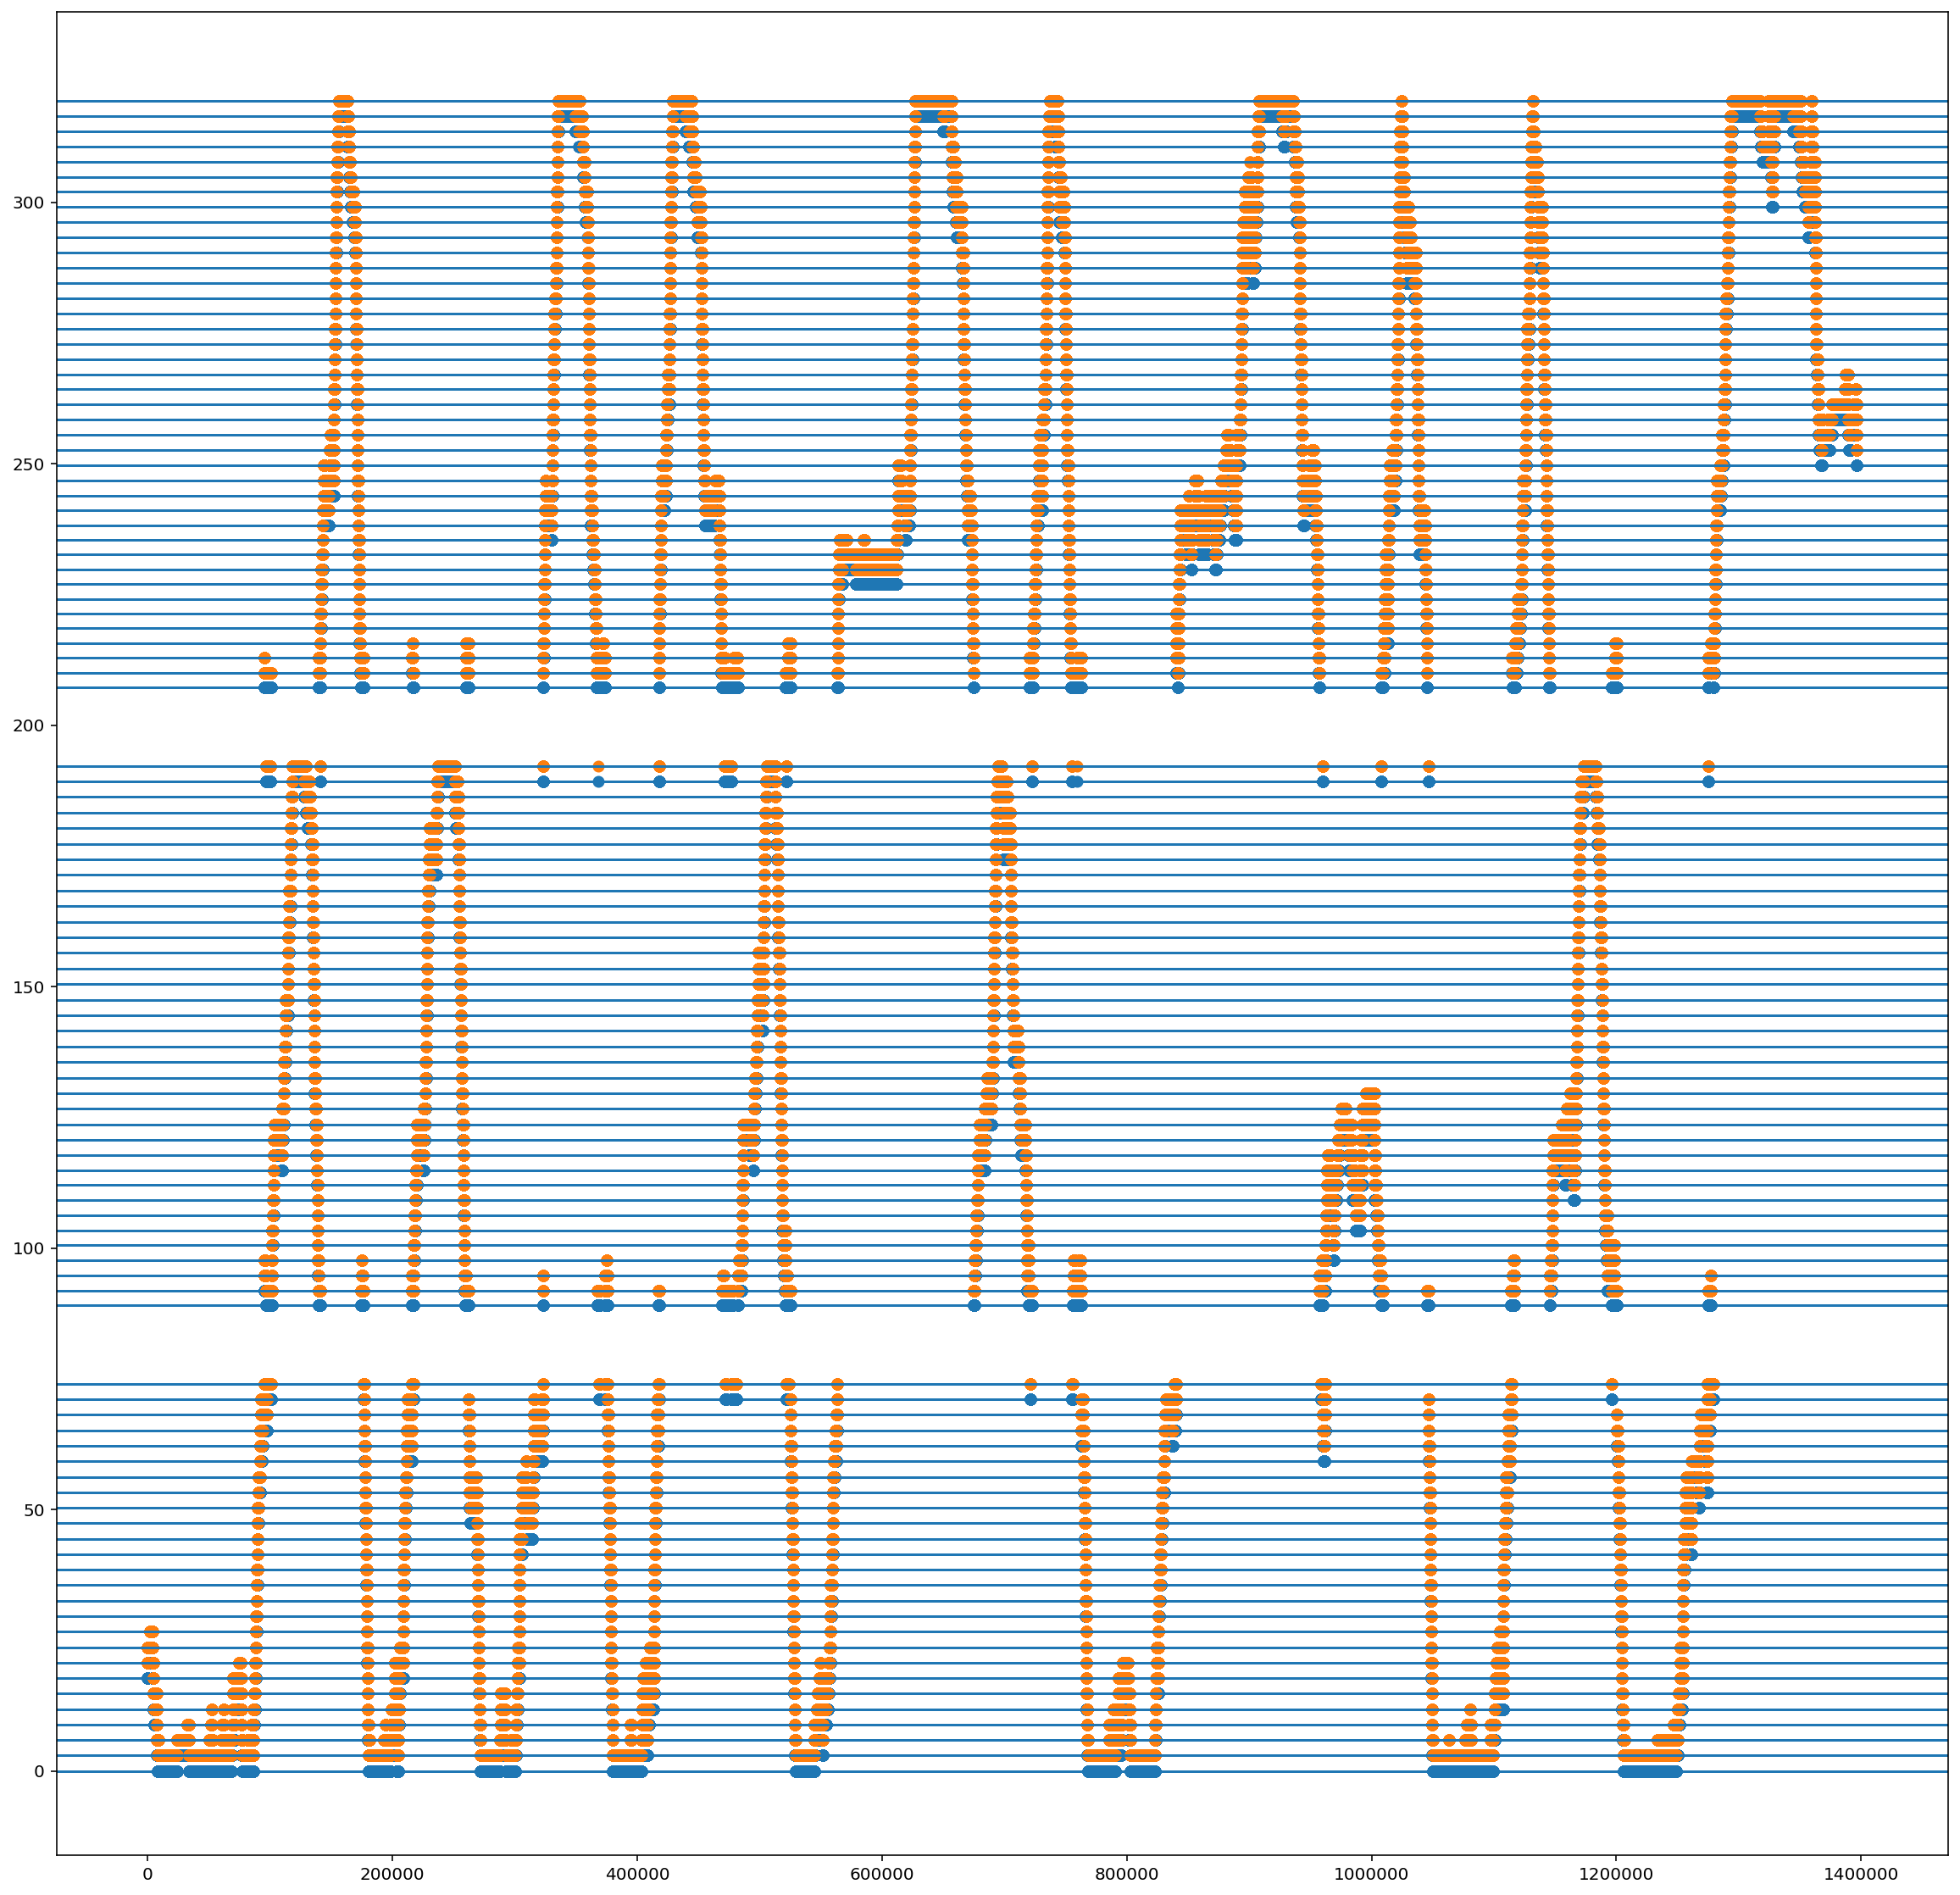

In [21]:
from replay_identification.core import get_observed_position_bin

bin_ind = get_observed_position_bin(position, bin_edges, is_track_interior)

plt.figure(figsize=(20, 20))
plt.scatter(np.arange(position.shape[0]), detector.place_bin_edges_[bin_ind])
plt.scatter(np.arange(position.shape[0]), detector.place_bin_edges_[bin_ind+1])

for e in detector.place_bin_edges_.squeeze():
    plt.axhline(e)

In [25]:
i = 1
bin_ind[i], bin_ind[i]+1

(6, 7)

In [34]:
detector.place_bin_center_ind_to_node_[bin_ind[i]]

(detector.place_bin_center_ind_to_node_[bin_ind[i]]-1, detector.place_bin_center_ind_to_node_[bin_ind[i]]+1)

(18, 20)

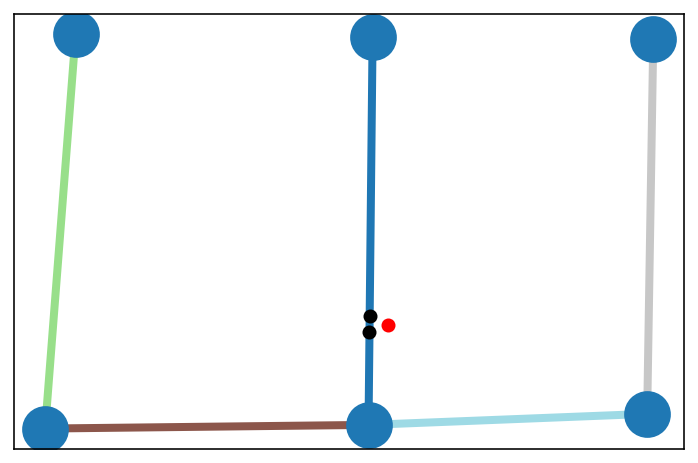

In [206]:
fig, ax = plt.subplots()
node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=ax,
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)

i = 1110000
plt.scatter(*data['position_info'].loc[:, ['x_position', 'y_position']].values[i], color='red', zorder=110)
pos = nx.get_node_attributes(detector.track_graph_, "pos")
plt.scatter(*pos[detector.place_bin_center_ind_to_node_[bin_ind[i]]-1], color='black', zorder=100)
plt.scatter(*pos[detector.place_bin_center_ind_to_node_[bin_ind[i]]+1], color='black', zorder=100)

In [107]:
pos[detector.place_bin_center_ind_to_node_[bin_ind[i]]-1]

array([245.5702765 , 145.61403509])

In [82]:
i = 100000

detector.place_bin_center_ind_to_node_[bin_ind[i]]-1, detector.place_bin_center_ind_to_node_[bin_ind[i]]+1

(206, 208)

In [ ]:
# breaks, need to figure out distance to bin centers

In [299]:
import networkx as nx

is_bin_edges = nx.get_node_attributes(detector.track_graph_, "is_bin_edge")

In [47]:
# linear_position to 2D
from scipy.interpolate import interp1d
import networkx as nx

def linear_position_to_2D_projection(linear_position, node_linear_position, edge_dist, node_2D_position):
    try:
        is_node = np.isclose(linear_position, node_linear_position)
        edge_ind = np.where((
            (linear_position >= node_linear_position[:, 0]) | is_node[:, 0]) &
            ((linear_position <= node_linear_position[:, 1]) | is_node[:, 1])
        )[0][0]
    except IndexError:
        return np.full((1, 2), np.nan)
    pct_dist = (linear_position - node_linear_position[edge_ind][0]) / edge_dist[edge_ind]
    segment_diff = np.diff(node_2D_position, axis=1).squeeze()

    return node_2D_position[edge_ind, 0] + segment_diff[edge_ind] * pct_dist, edge_ind



(x1, y1), edge_ind = linear_position_to_2D_projection(
    position[0], detector.node_linear_position, edge_dist, detector.node_2D_position)

fig, ax = plt.subplots()
node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=ax,
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)
nx.draw_networkx_edge_labels(
    track_graph, node_position, ax=ax, edge_labels=edge_labels
)
plt.axis("off");
plt.scatter(x1, y1, color='black', s=100, zorder=100)

AttributeError: 'ReplayDetector' object has no attribute 'node_linear_position'

In [434]:
from replay_identification.core import convert_linear_distance_to_linear_position

track_graph1 = detector.track_graph_

distance_between_nodes = dict(
    nx.single_source_dijkstra_path_length(track_graph1, source=center_well_id, weight="distance")
)

node_ids, linear_distance = list(
    zip(*distance_between_nodes.items())
)
linear_distance = np.array(linear_distance)

edge_ids = nx.get_node_attributes(track_graph1, "edge_id")
edge_id = np.array([edge_ids[node_id] for node_id in node_ids])

is_bin_edges = nx.get_node_attributes(track_graph1, "is_bin_edge")
is_bin_edge = np.array([is_bin_edges[node_id] for node_id in node_ids])

node_linear_position = convert_linear_distance_to_linear_position(
    linear_distance, edge_id, edge_order, spacing=edge_spacing
)

nodes_df = pd.DataFrame(
    dict(node_ids=node_ids, edge_id=edge_id, is_bin_edge=is_bin_edge,
         linear_position=node_linear_position)).sort_values(by=['linear_position', 'edge_id'], axis='rows')
nodes_df

node_ids  edge_id  is_bin_edge  linear_position
0           0        0         True         0.000000
1           6        0         True         0.000000
2           7        0        False         1.480730
3           8        0         True         2.961461
4           9        0        False         4.442191
..        ...      ...          ...              ...
204       156        3        False       315.059353
205       157        3         True       316.511617
206       158        3        False       317.963881
207       159        3         True       319.416145
208         3        3         True       319.416145

[209 rows x 4 columns]

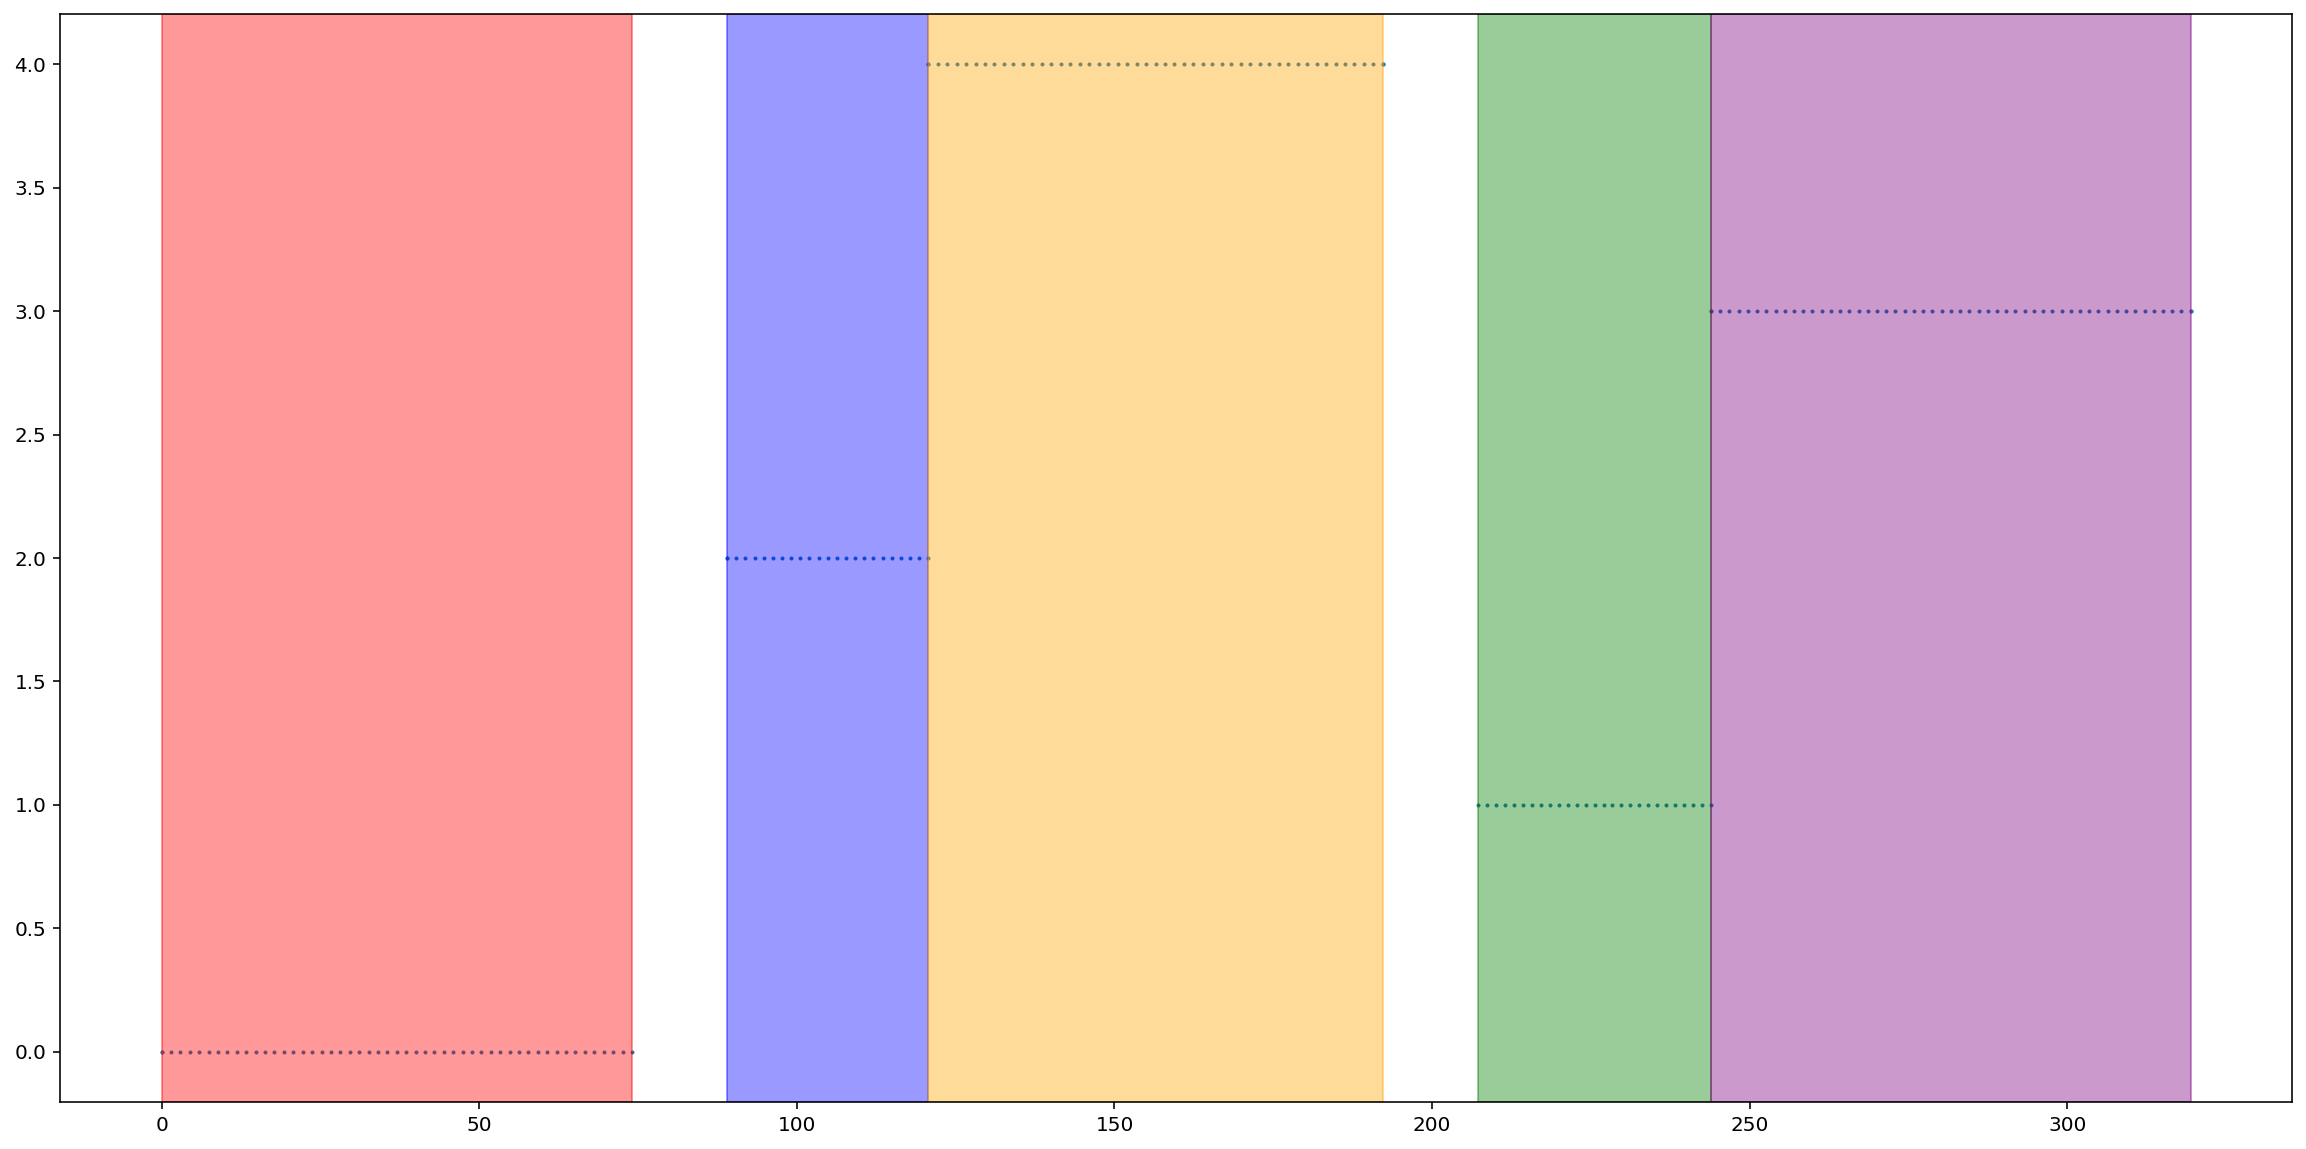

In [435]:
plt.figure(figsize=(20, 10))
plt.scatter(nodes_df.linear_position.values, nodes_df.edge_id.values, s=1)

color = ['red', 'green', 'blue', 'purple', 'orange']

for (_, df), c in zip(nodes_df.groupby('edge_id'), color):
    plt.axvspan(df.linear_position.min(), df.linear_position.max(), alpha=0.4, color=c)

In [423]:
nodes_df.edge_id.unique()

array([0, 2, 4, 1, 3])

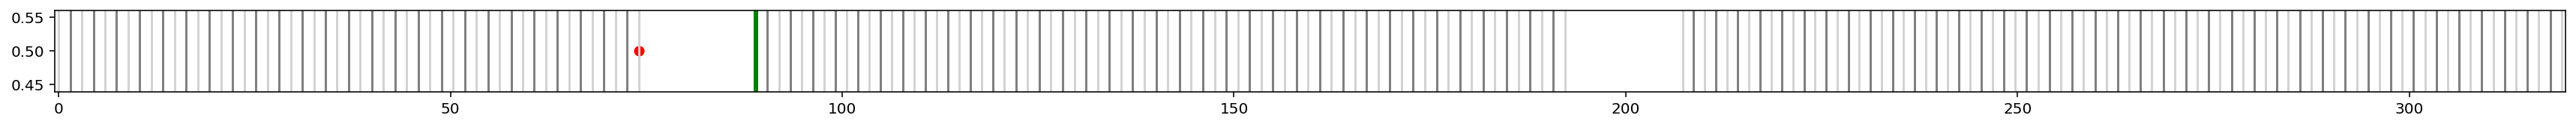

In [533]:

# i = 106000
# i = 100000
# i = 52
i = 97745
x = data['position_info'].iloc[i].linear_position

bin_ind = np.searchsorted(nodes_df.linear_position.values, x)

plt.figure(figsize=(30, 1))

for e in node_linear_position[is_bin_edge]:
    plt.axvline(e, color='lightgrey')
    
for e in node_linear_position[~is_bin_edge]:
    plt.axvline(e, color='grey')

    
is_same_edge = nodes_df.iloc[bin_ind - 1].edge_id == nodes_df.iloc[bin_ind].edge_id

left_node_ind = bin_ind - 1 if is_same_edge else bin_ind
right_node_ind = bin_ind

plt.axvline(nodes_df.iloc[left_node_ind].linear_position, color='green', linewidth=3)
plt.axvline(nodes_df.iloc[right_node_ind].linear_position, color='green', linewidth=3)

plt.scatter(x, 0.5, color='red')
plt.xlim((-0.5, nodes_df.linear_position.values.max()+0.5));

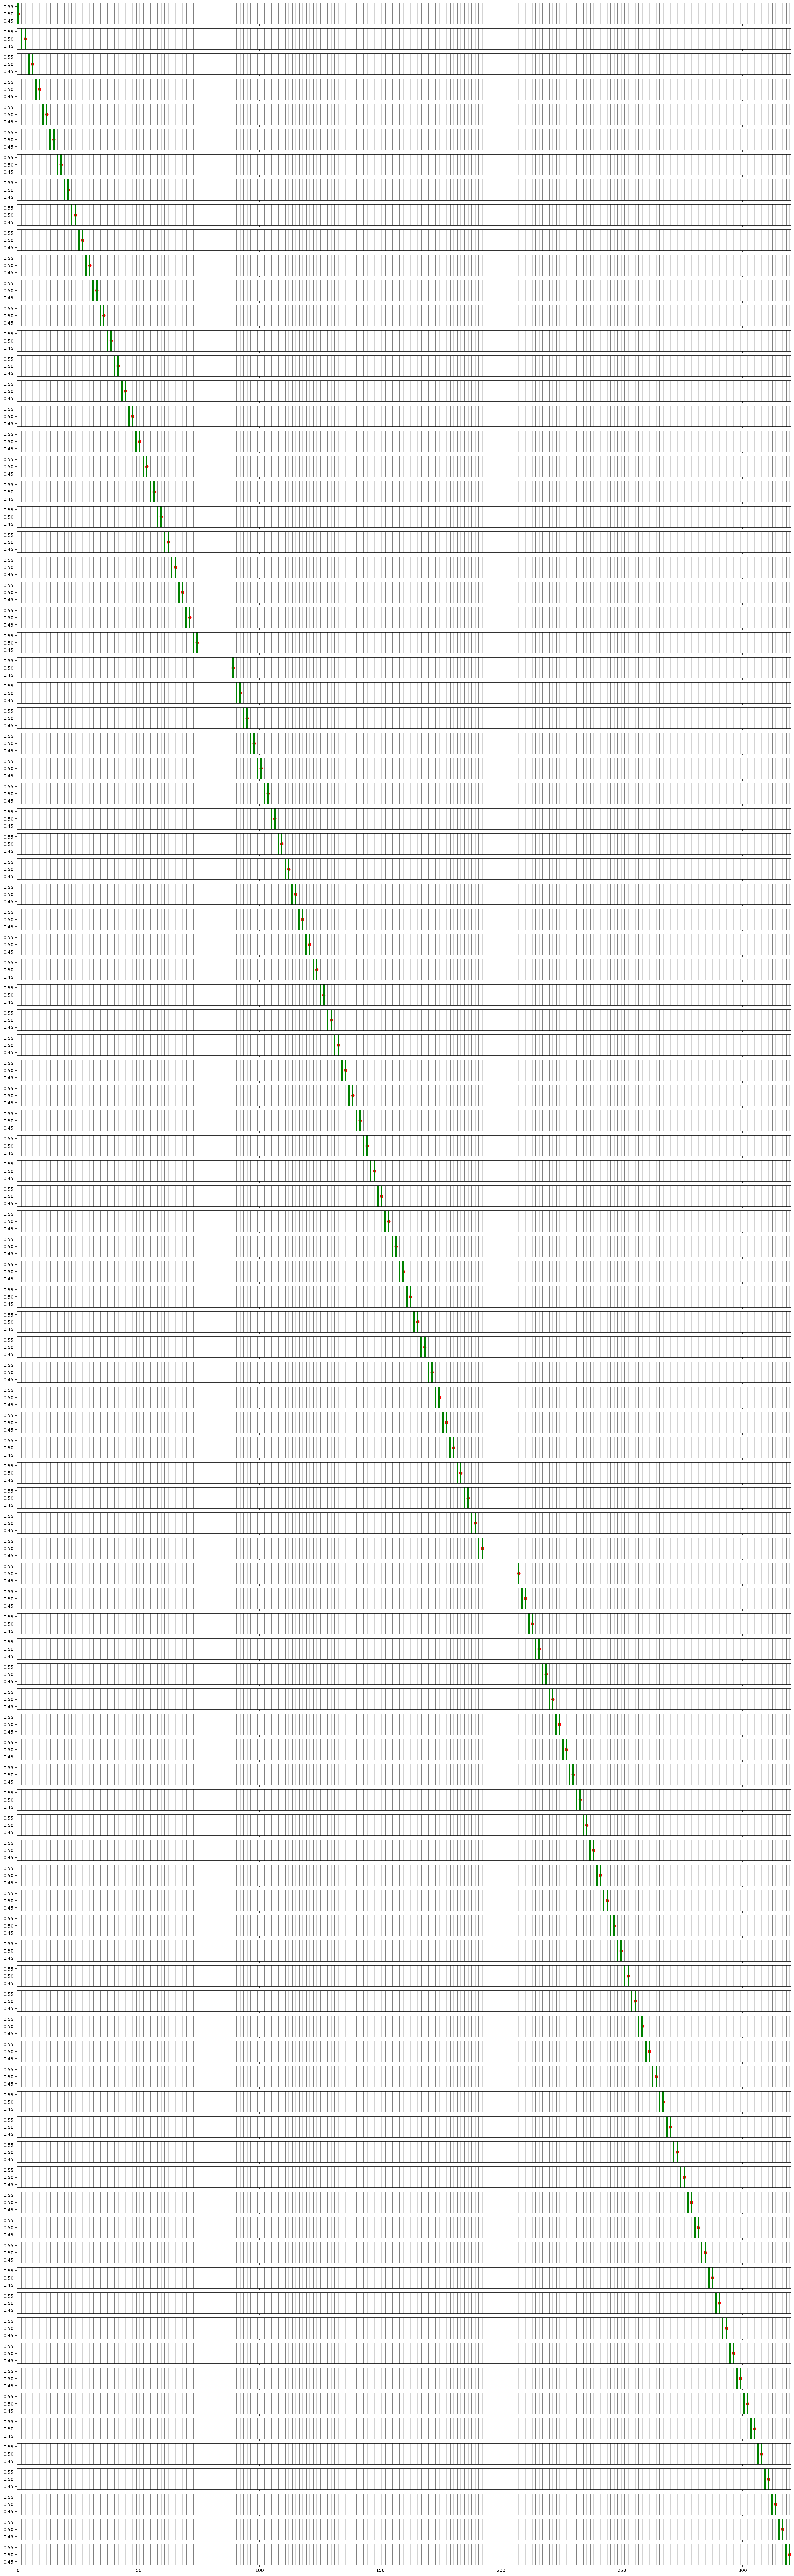

In [553]:
fig, axes = plt.subplots(detector.place_bin_edges_.size, 1, figsize=(30, detector.place_bin_edges_.size),
                         sharex=True, sharey=True)
for ax, x in zip(axes, detector.place_bin_edges_.squeeze()):

    bin_ind = np.searchsorted(nodes_df.linear_position.values, x)

    for e in node_linear_position[is_bin_edge]:
        ax.axvline(e, color='lightgrey')

    for e in node_linear_position[~is_bin_edge]:
        ax.axvline(e, color='grey')


    is_same_edge = nodes_df.iloc[bin_ind - 1].edge_id == nodes_df.iloc[bin_ind].edge_id

    try:
        if is_same_edge:
            left_node_ind = bin_ind - 1
            right_node_ind = bin_ind
        else:
            left_node_ind = right_node_ind = np.nonzero(np.isclose(x, nodes_df.linear_position.values))[0][0]
    except IndexError:
        continue

    ax.axvline(nodes_df.iloc[left_node_ind].linear_position, color='green', linewidth=3)
    ax.axvline(nodes_df.iloc[right_node_ind].linear_position, color='green', linewidth=3)

    ax.scatter(x, 0.5, color='red')

plt.xlim((-0.5, nodes_df.linear_position.values.max()+0.5));

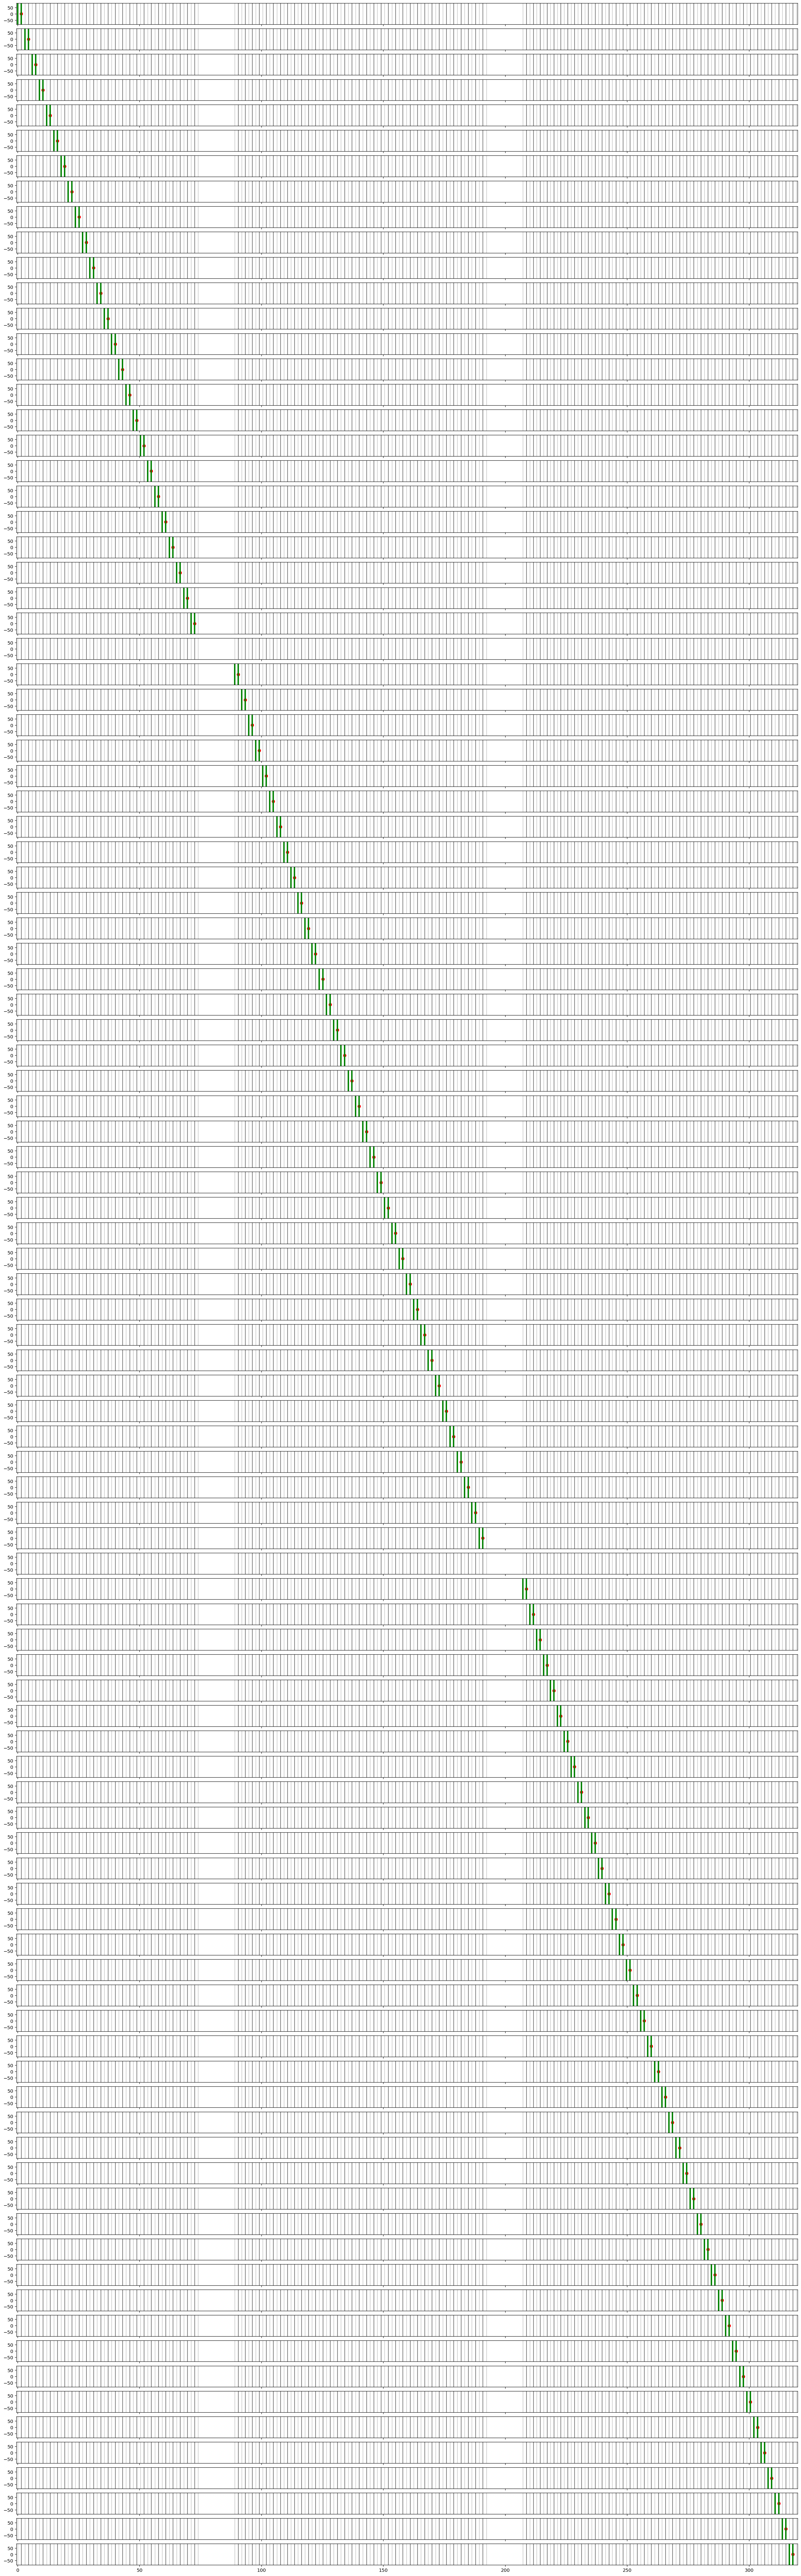

In [554]:
fig, axes = plt.subplots(detector.place_bin_centers_.size, 1, figsize=(30, detector.place_bin_centers_.size),
                         sharex=True, sharey=True)
for ax, x in zip(axes, detector.place_bin_centers_.squeeze()):

    bin_ind = np.searchsorted(nodes_df.linear_position.values, x)

    for e in node_linear_position[is_bin_edge]:
        ax.axvline(e, color='lightgrey')

    for e in node_linear_position[~is_bin_edge]:
        ax.axvline(e, color='grey')


    is_same_edge = nodes_df.iloc[bin_ind - 1].edge_id == nodes_df.iloc[bin_ind].edge_id
    try:
        if is_same_edge:
            left_node_ind = bin_ind - 1
            right_node_ind = bin_ind
        else:
            left_node_ind = right_node_ind = np.nonzero(np.isclose(x, nodes_df.linear_position.values))[0][0]
    except IndexError:
        continue

    ax.axvline(nodes_df.iloc[left_node_ind].linear_position, color='green', linewidth=3)
    ax.axvline(nodes_df.iloc[right_node_ind].linear_position, color='green', linewidth=3)

    ax.scatter(x, 0.5, color='red')

plt.xlim((-0.5, nodes_df.linear_position.values.max()+0.5));

In [453]:
np.isclose(nodes_df.iloc[bin_ind - 1].linear_position, x)

False

In [407]:
nodes_df.iloc[bin_ind - 1]

node_ids               106
edge_id                  2
is_bin_edge           True
linear_position    120.673
Name: 98, dtype: object

In [409]:
nodes_df.iloc[bin_ind]

node_ids               161
edge_id                  4
is_bin_edge          False
linear_position    122.165
Name: 102, dtype: object

In [414]:
x

120.7129887039693

In [430]:
nodes_df.linear_position.values[bin_ind-1], x, nodes_df.linear_position.values[bin_ind]

(120.67346670110263, 120.7129887039693, 122.16476430514574)

In [308]:
x < nodes_df.linear_position.values[bin_ind]

True

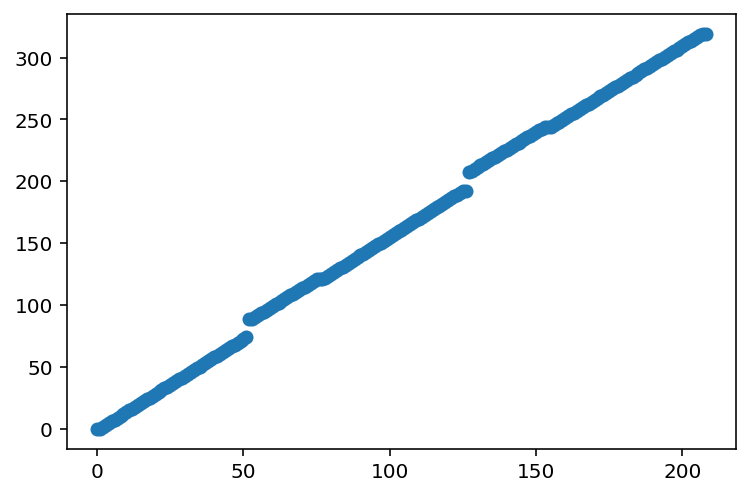

In [413]:
plt.scatter(np.arange(len(nodes_df)), nodes_df.linear_position)

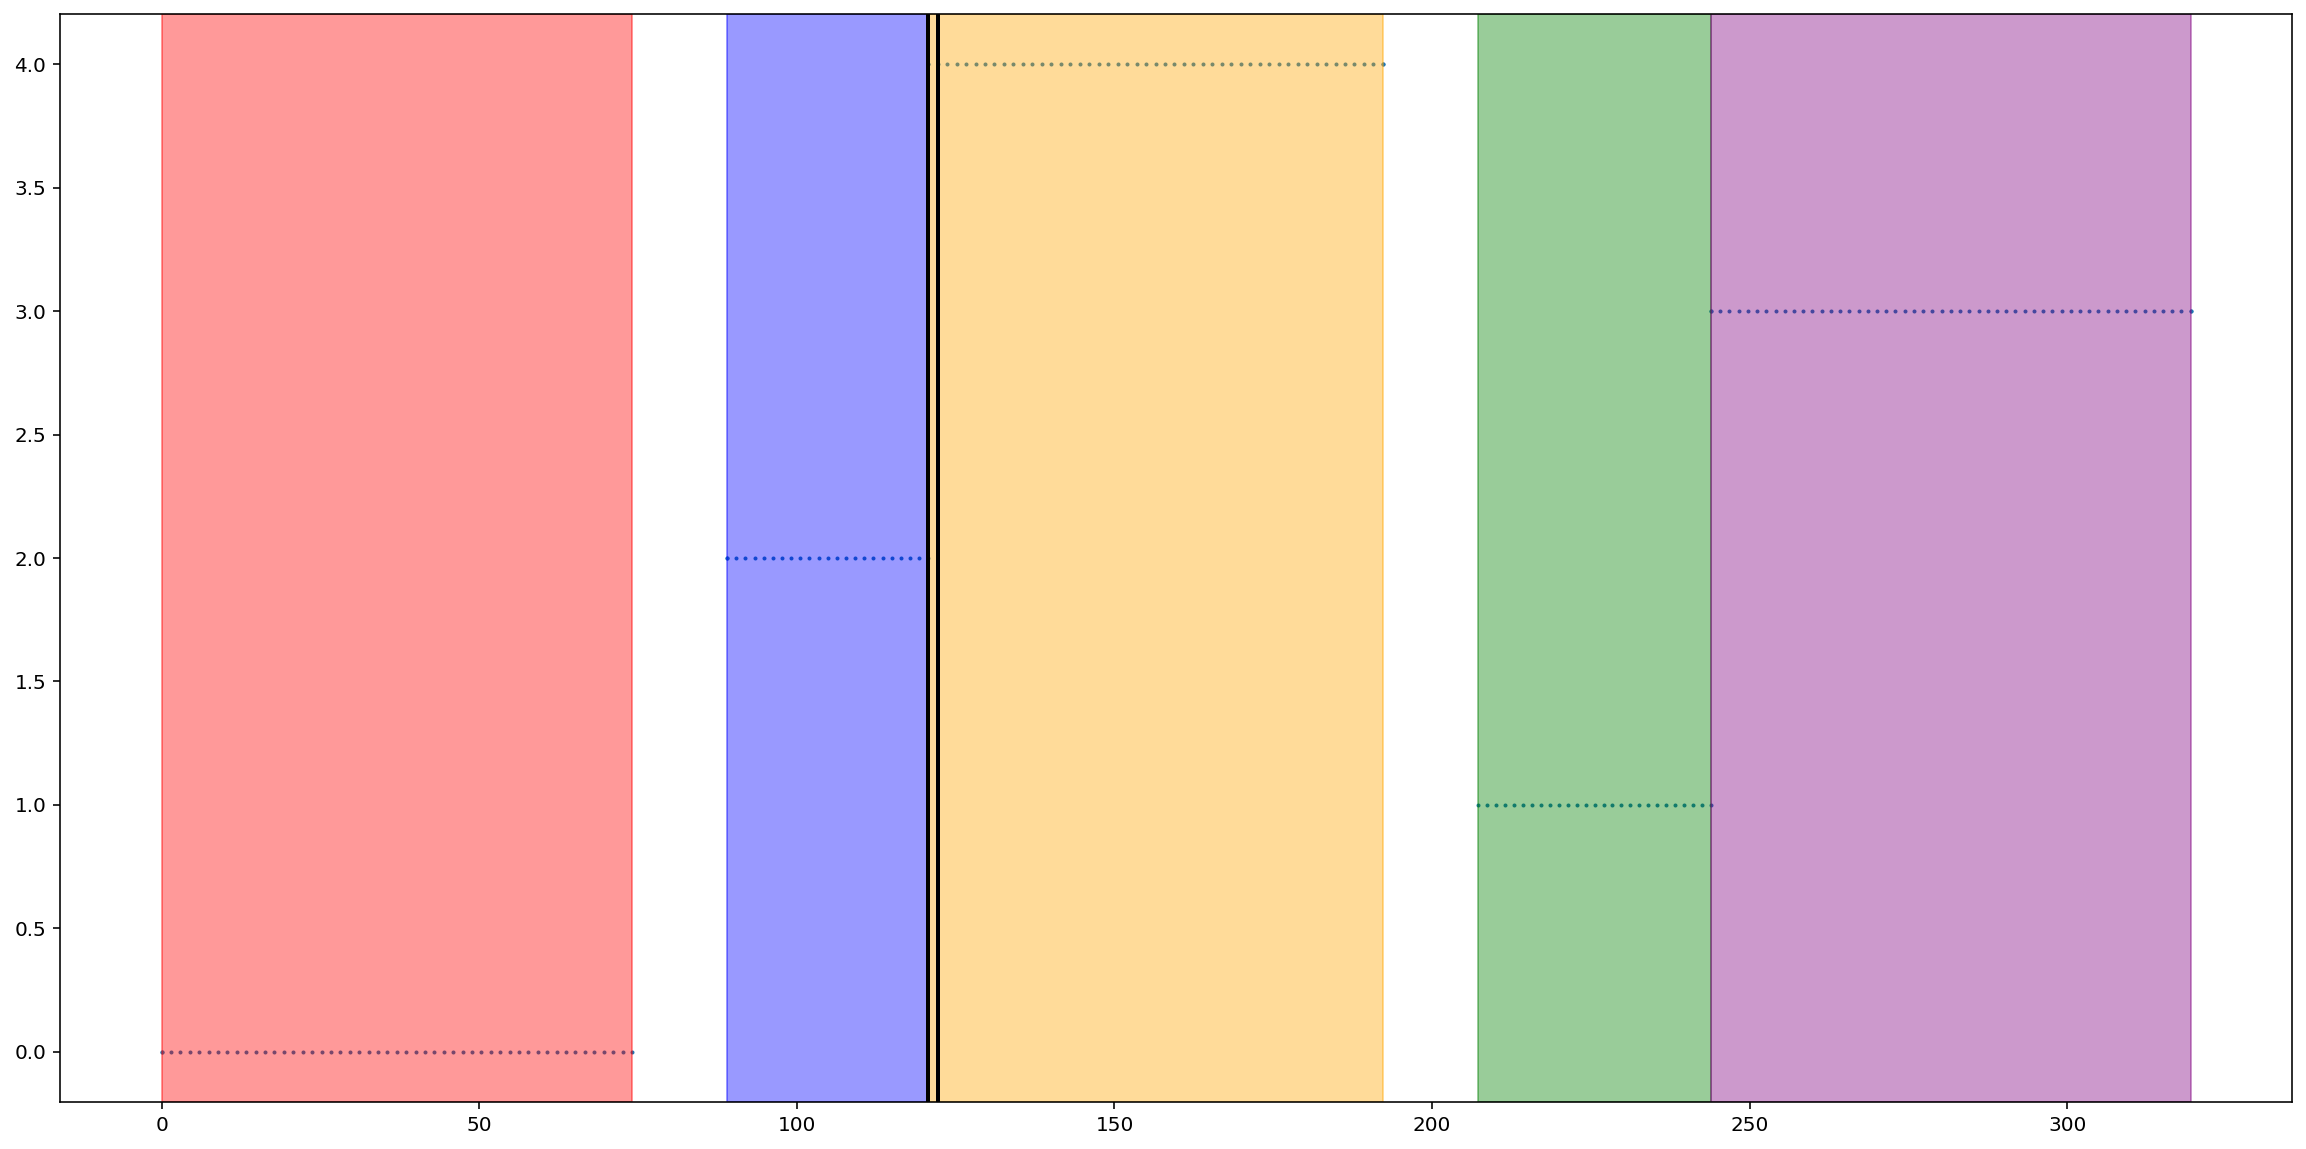

In [437]:
plt.figure(figsize=(20, 10))
plt.scatter(nodes_df.linear_position.values, nodes_df.edge_id.values, s=1)

color = ['red', 'green', 'blue', 'purple', 'orange']

for (_, df), c in zip(nodes_df.groupby('edge_id'), color):
    plt.axvspan(df.linear_position.min(), df.linear_position.max(), alpha=0.4, color=c)

for e in [nodes_df.linear_position.values[bin_ind-1], x, nodes_df.linear_position.values[bin_ind]]:
    plt.axvline(e, color='black', linewidth=2)

In [578]:
x = data['position_info'].linear_position.values
bin_ind = np.searchsorted(nodes_df.linear_position.values, x)
is_same_edge = (nodes_df.iloc[bin_ind - 1].edge_id.values == nodes_df.iloc[bin_ind].edge_id.values)

left_node_ind = bin_ind - 1
right_node_ind = bin_ind

right_node_ind[~is_same_edge] = left_node_ind[~is_same_edge] = np.argmin(
    np.abs(x[~is_same_edge, np.newaxis] - nodes_df.linear_position.values), axis=1)

In [579]:
np.abs(nodes_df.iloc[left_node_ind].linear_position - x).max()

1.491297604033008

In [580]:
np.abs(nodes_df.iloc[right_node_ind].linear_position - x).max()

1.4912976040386354

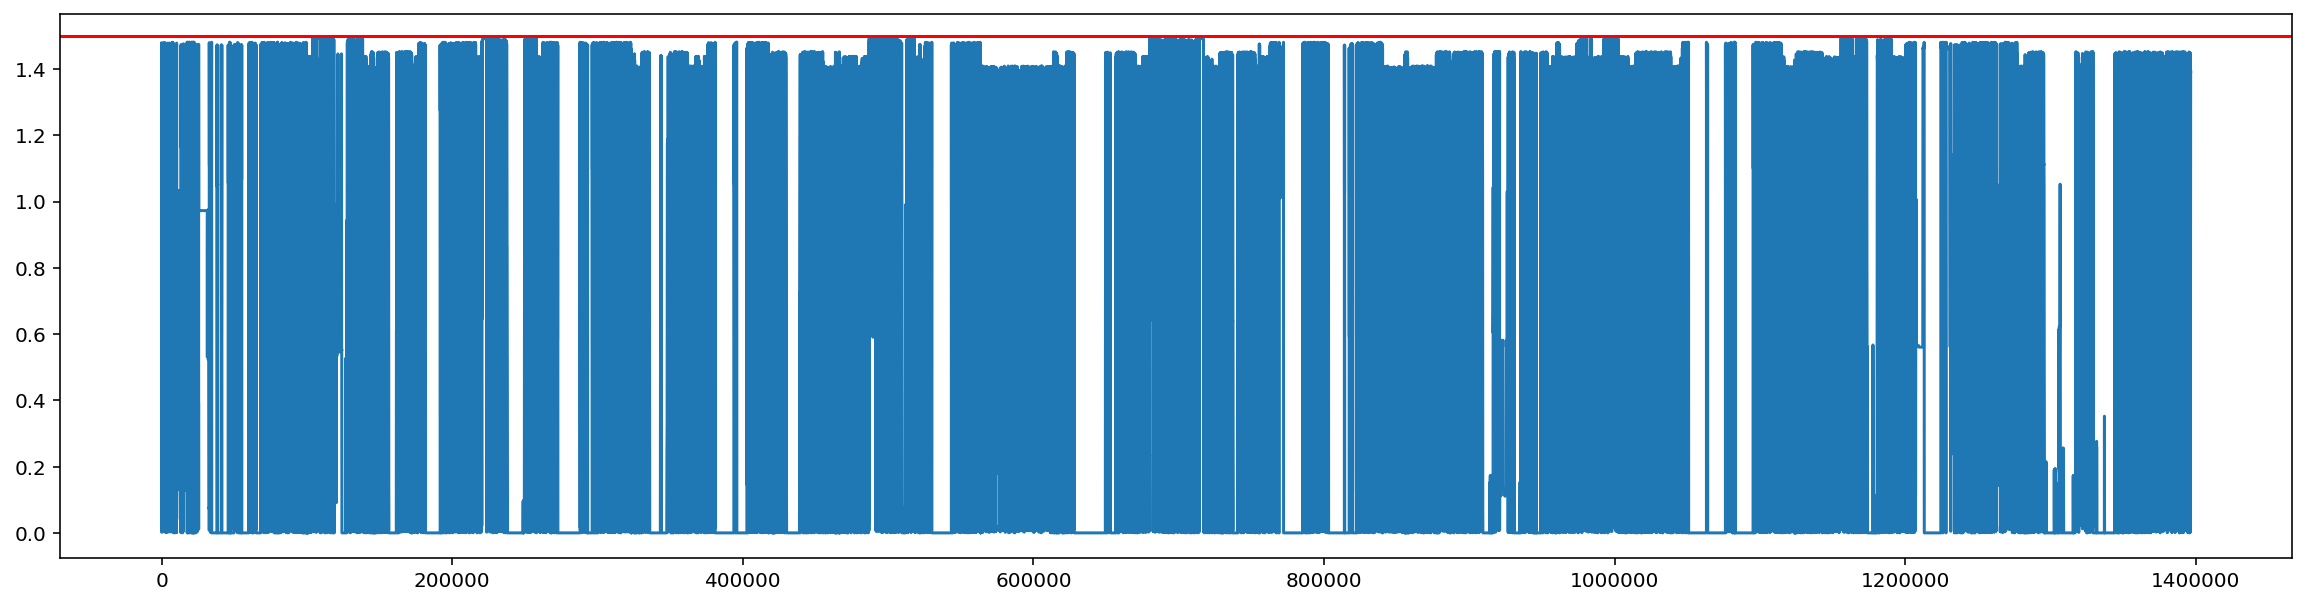

In [584]:
plt.figure(figsize=(20, 5))
plt.plot(np.abs(nodes_df.linear_position.values[right_node_ind] - data['position_info'].linear_position.values))
plt.axhline(detector.place_bin_size / 2, color='red')

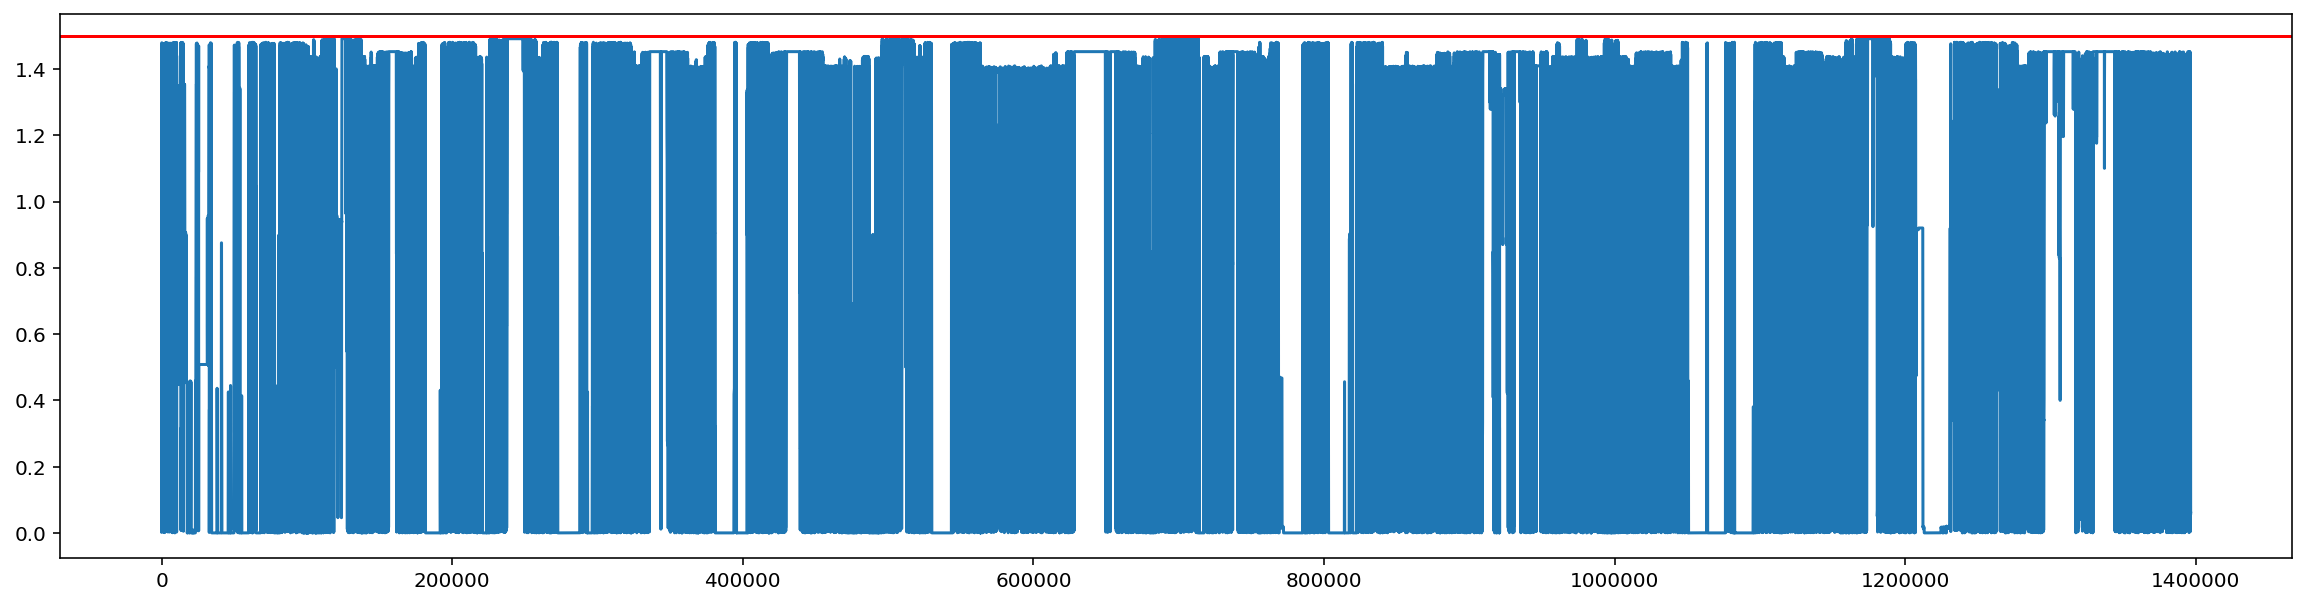

In [583]:
plt.figure(figsize=(20, 5))
plt.plot(np.abs(nodes_df.linear_position.values[left_node_ind] - data['position_info'].linear_position.values))
plt.axhline(detector.place_bin_size / 2, color='red')

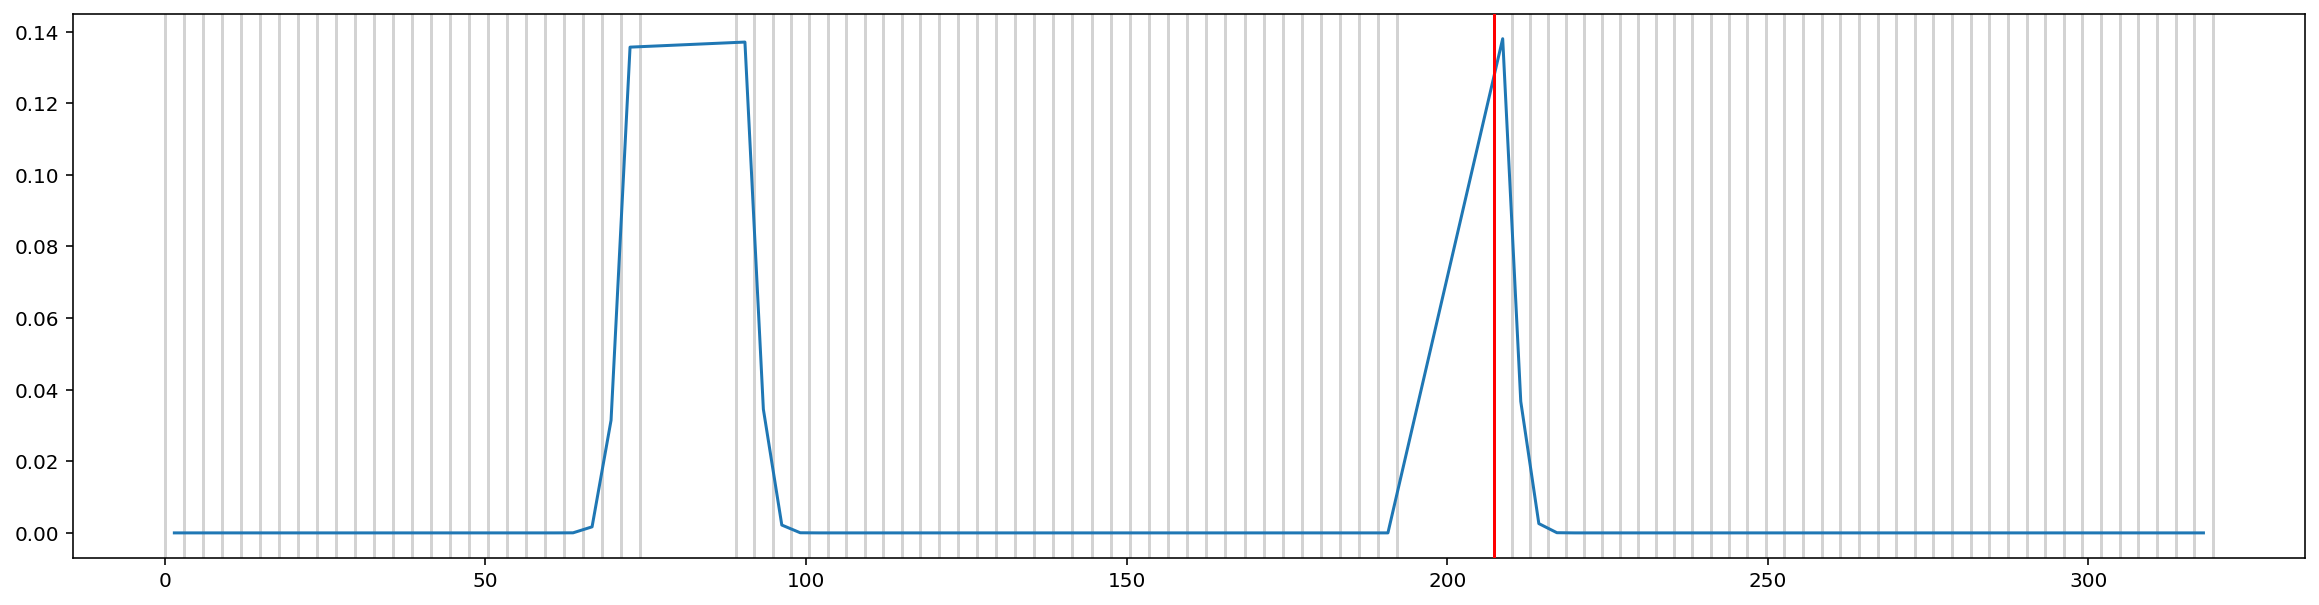

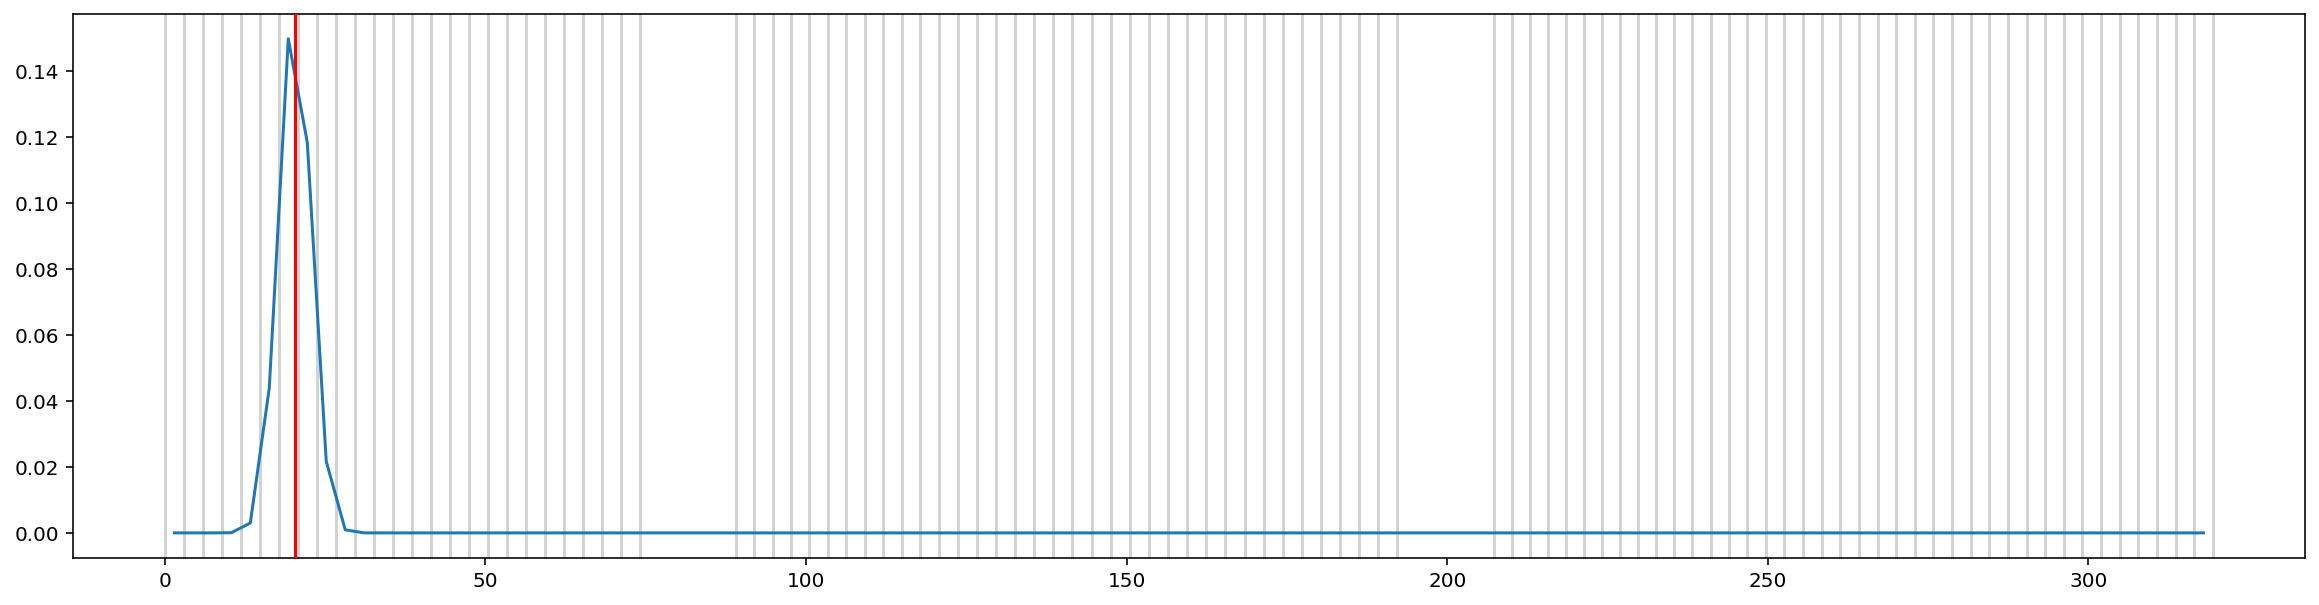

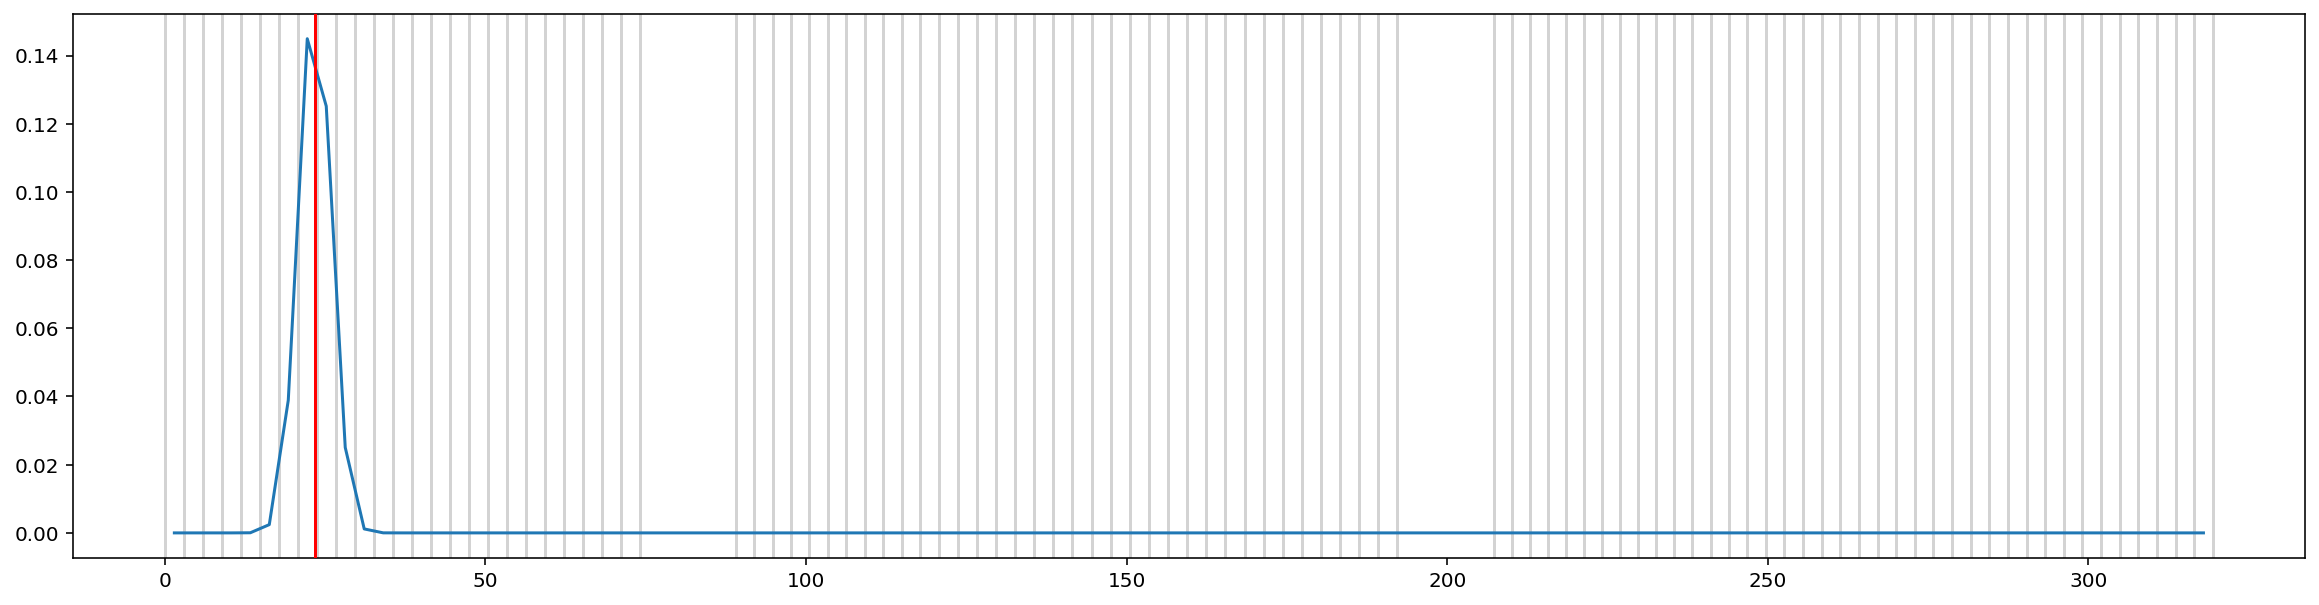

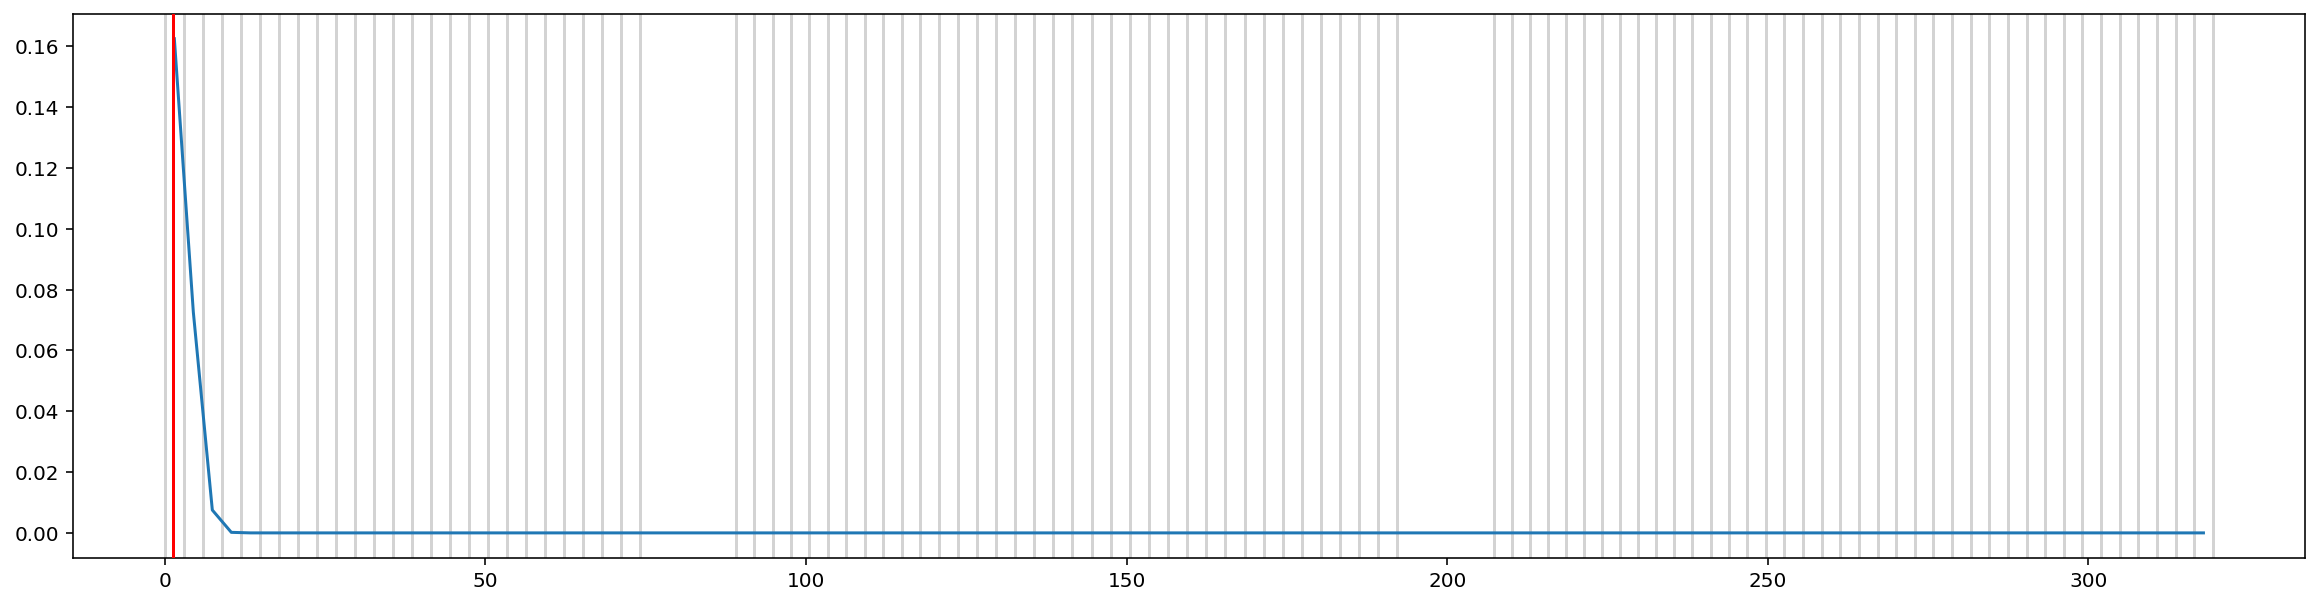

In [755]:
from scipy.stats import multivariate_normal

track_graph1 = detector.track_graph_.copy()

i = 100000

place_bin_center_to_node_id = nodes_df.loc[~nodes_df.is_bin_edge].sort_values(by=['linear_position']).node_ids.values

for i in [100000, 0, 1000, 50000]:
    left_node_id = nodes_df.iloc[left_node_ind[i]].node_ids
    right_node_id = nodes_df.iloc[right_node_ind[i]].node_ids
    left_dist = np.abs(nodes_df.iloc[left_node_ind[i]].linear_position - x[i])
    right_dist = np.abs(nodes_df.iloc[right_node_ind[i]].linear_position - x[i])

    nx.add_path(track_graph1, [left_node_id, 'a'], distance=left_dist)
    nx.add_path(track_graph1, ['a', right_node_id], distance=right_dist)
    dist = nx.single_source_dijkstra_path_length(track_graph1, source='a', weight="distance")
    track_graph1.remove_node('a')
    r = np.array([dist[id] for id in place_bin_center_to_node_id])


    variance = 6
    g = multivariate_normal(mean=0, cov=variance).pdf(r)

    plt.figure(figsize=(20, 5))
    plt.plot(detector.place_bin_centers_[is_track_interior], g, zorder=100)

    for e in detector.place_bin_edges_:
        plt.axvline(e, color='lightgrey')

    plt.axvline(x[i], color='red', zorder=1000)

In [756]:
from tqdm.autonotebook import tqdm

def get_distance(x, track_graph, left_node_ind, right_node_ind, node_ids, node_linear_position,
                 place_bin_center_to_node_id):
    left_node_id = node_ids[left_node_ind]
    right_node_id = node_ids[right_node_ind]
    left_dist = np.abs(node_linear_position[left_node_ind] - x)
    right_dist = np.abs(node_linear_position[right_node_ind] - x)

    nx.add_path(track_graph, [left_node_id, 'a'], distance=left_dist)
    nx.add_path(track_graph, ['a', right_node_id], distance=right_dist)
    dist = nx.single_source_dijkstra_path_length(track_graph, source='a', weight="distance")
    track_graph.remove_node('a')
    r = np.array([dist[id] for id in place_bin_center_to_node_id])

    return r


copy_graph = detector.track_graph_.copy()
blah = [get_distance(x[i], copy_graph, left_node_ind[i], right_node_ind[i],
                     nodes_df.node_ids.values, nodes_df.linear_position.values,
                     place_bin_center_to_node_id)
        for i in tqdm(range(x.size))]

In [759]:
blah = np.stack(blah, axis=0)

In [763]:
g = multivariate_normal(mean=0, cov=variance).pdf(blah.ravel()).reshape(blah.shape)

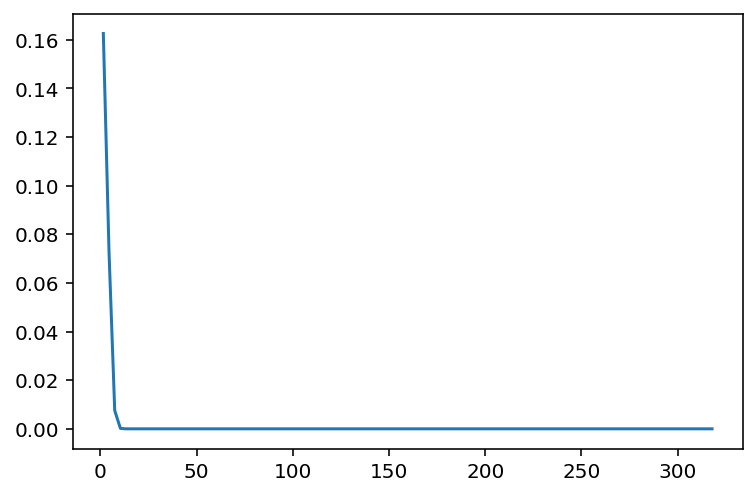

In [767]:
plt.plot(detector.place_bin_centers_[is_track_interior], g[50000])

In [781]:
%%snakeviz
i = 0
get_distance(x[i], copy_graph, left_node_ind[i], right_node_ind[i],
              nodes_df.node_ids.values, nodes_df.linear_position.values, place_bin_center_to_node_id)

 
*** Profile stats marshalled to file '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/tmphkjibpy5'. 
Embedding SnakeViz in this document...


In [28]:
import networkx as nx
from replay_identification.core import get_track_grid, convert_linear_distance_to_linear_position

(
        place_bin_centers,
        place_bin_edges,
        is_track_interior,
        distance_between_nodes,
        place_bin_center_ind_to_node,
        place_bin_center_2D_position,
        place_bin_edges_2D_position,
        centers_shape,
        edges,
        track_graph1,
        place_bin_center_ind_to_edge_id,
    )= get_track_grid(
        track_graph, center_well_id, edge_order, edge_spacing, place_bin_size)

distance_between_nodes = dict(
    nx.single_source_dijkstra_path_length(track_graph1, source=center_well_id, weight="distance")
)

node_ids, linear_distance = list(
    zip(*distance_between_nodes.items())
)
linear_distance = np.array(linear_distance)

edge_ids = nx.get_node_attributes(track_graph1, "edge_id")
edge_id = np.array([edge_ids[node_id] for node_id in node_ids])

is_bin_edges = nx.get_node_attributes(track_graph1, "is_bin_edge")
is_bin_edge = np.array([is_bin_edges[node_id] for node_id in node_ids])

node_linear_position = convert_linear_distance_to_linear_position(
    linear_distance, edge_id, edge_order, edge_spacing
)

nodes_df = pd.DataFrame(
    dict(node_ids=node_ids, edge_id=edge_id, is_bin_edge=is_bin_edge,
         linear_position=node_linear_position)).sort_values(by=['linear_position', 'edge_id'], axis='rows')


x = data['position_info'].linear_position.values
bin_ind = np.searchsorted(nodes_df.linear_position.values, x)
is_same_edge = (nodes_df.iloc[bin_ind - 1].edge_id.values == nodes_df.iloc[bin_ind].edge_id.values)

left_node_ind = bin_ind - 1
right_node_ind = bin_ind

right_node_ind[~is_same_edge] = left_node_ind[~is_same_edge] = np.argmin(
    np.abs(x[~is_same_edge, np.newaxis] - nodes_df.linear_position.values), axis=1)

place_bin_center_to_node_id = nodes_df.loc[~nodes_df.is_bin_edge].sort_values(by=['linear_position']).node_ids.values

In [29]:
left_node_id = nodes_df.node_ids.values[left_node_ind]
right_node_id = nodes_df.node_ids.values[right_node_ind]
left_dist = np.abs(nodes_df.linear_position.values[left_node_ind] - x)
right_dist = np.abs(nodes_df.linear_position.values[left_node_ind] - x)

In [30]:
def get_distance2(track_graph, left_node_id, right_node_id, left_dist, right_dist,
                 place_bin_center_to_node_id):
    nx.add_path(track_graph, [left_node_id, 'a'], distance=left_dist)
    nx.add_path(track_graph, ['a', right_node_id], distance=right_dist)
    dist = nx.single_source_dijkstra_path_length(track_graph, source='a', weight="distance")
    track_graph.remove_node('a')
    r = np.array([dist[id] for id in place_bin_center_to_node_id])

    return r

In [31]:
i = 0
copy_graph = track_graph1.copy()
get_distance2(copy_graph, left_node_id[i], right_node_id[i],
                      left_dist[i], right_dist[i],
                      place_bin_center_to_node_id)

array([ 21.44315767,  18.4816968 ,  15.52023592,  12.55877504,
         9.59731417,   6.63585329,   3.67439241,   0.71293154,
         2.19366197,   5.15512285,   8.11658373,  11.0780446 ,
        14.03950548,  17.00096636,  19.96242723,  22.92388811,
        25.88534899,  28.84680986,  31.80827074,  34.76973162,
        37.73119249,  40.69265337,  43.65411425,  46.61557512,
        49.577036  ,  52.49580938,  55.37189527,  58.24798116,
        61.12406705,  64.00015294,  66.87623883,  69.75232472,
        72.62841061,  75.5044965 ,  78.38058239,  81.25666828,
        84.18600883,  87.16860404,  90.15119924,  93.13379445,
        96.11638966,  99.09898487, 102.08158008, 105.06417528,
       108.04677049, 111.0293657 , 114.01196091, 116.99455612,
       119.97715133, 122.95974653, 125.94234174, 128.92493695,
       131.90753216, 134.89012737, 137.87272257, 140.85531778,
       143.83791299, 146.8205082 , 149.80310341, 152.78569861,
        52.46709971,  55.28576625,  58.1044328 ,  60.92

In [790]:
copy_graph = detector.track_graph_.copy()

left_node_id = nodes_df.node_ids.values[left_node_ind]
right_node_id = nodes_df.node_ids.values[right_node_ind]
left_dist = np.abs(nodes_df.linear_position.values[left_node_ind] - x)
right_dist = np.abs(nodes_df.linear_position.values[left_node_ind] - x)

blah = [get_distance2(copy_graph, left_node_id[i], right_node_id[i],
                      left_dist[i], right_dist[i],
                      place_bin_center_to_node_id)
        for i in tqdm(range(x.size))]

In [42]:
from dask.distributed import Client

client = Client(n_workers=2)
client

<Client: 'tcp://127.0.0.1:52697' processes=2 threads=4, memory=17.18 GB>

In [31]:
n_time = data['position_info'].shape[0]
np.array(range(0, n_time, 100000)), n_time

(array([      0,  100000,  200000,  300000,  400000,  500000,  600000,
         700000,  800000,  900000, 1000000, 1100000, 1200000, 1300000]),
 1396490)

In [41]:
import dask

def batch(n_samples, batch_size=1):
    for ind in range(0, n_samples, batch_size):
        yield range(ind, min(ind + batch_size, n_samples))

for x in batch(n_time, batch_size=100_000):
    print(x)

range(0, 100000)
range(100000, 200000)
range(200000, 300000)
range(300000, 400000)
range(400000, 500000)
range(500000, 600000)
range(600000, 700000)
range(700000, 800000)
range(800000, 900000)
range(900000, 1000000)
range(1000000, 1100000)
range(1100000, 1200000)
range(1200000, 1300000)
range(1300000, 1396490)


In [50]:
def batch_distance(track_graph, left_node_id, right_node_id,
                   left_dist, right_dist, place_bin_center_to_node_id):
    copy_graph = track_graph.copy()

    return np.stack([get_distance2(copy_graph, l_id, r_id, l_d, r_d,
                          place_bin_center_to_node_id)
                     for l_id, r_id, l_d, r_d in zip(left_node_id, right_node_id,
                                                     left_dist, right_dist)], axis=0)

In [51]:
%%time

batch_distance(track_graph1, left_node_id[x], right_node_id[x],
               left_dist[x], right_dist[x], place_bin_center_to_node_id);

CPU times: user 43.1 s, sys: 822 ms, total: 43.9 s
Wall time: 52 s


array([[184.71618496, 181.75472409, 178.79326321, ...,   7.26132004,
          4.35679202,   1.45226401],
       [184.71618496, 181.75472409, 178.79326321, ...,   7.26132004,
          4.35679202,   1.45226401],
       [184.71618496, 181.75472409, 178.79326321, ...,   7.26132004,
          4.35679202,   1.45226401],
       ...,
       [116.51935797, 113.55789709, 110.59643622, ...,  59.60240571,
         62.50693373,  65.41146174],
       [116.51935797, 113.55789709, 110.59643622, ...,  59.60240571,
         62.50693373,  65.41146174],
       [116.51935797, 113.55789709, 110.59643622, ...,  59.60240571,
         62.50693373,  65.41146174]])

In [55]:
%%time

import dask

blah = []
for x in batch(n_time, batch_size=10_000):
    blah.append(dask.delayed(batch_distance)(track_graph1, left_node_id[x], right_node_id[x],
                                 left_dist[x], right_dist[x], place_bin_center_to_node_id))
    
r = np.concatenate(dask.compute(*blah), axis=0)

CPU times: user 19.8 s, sys: 4.05 s, total: 23.8 s
Wall time: 7min


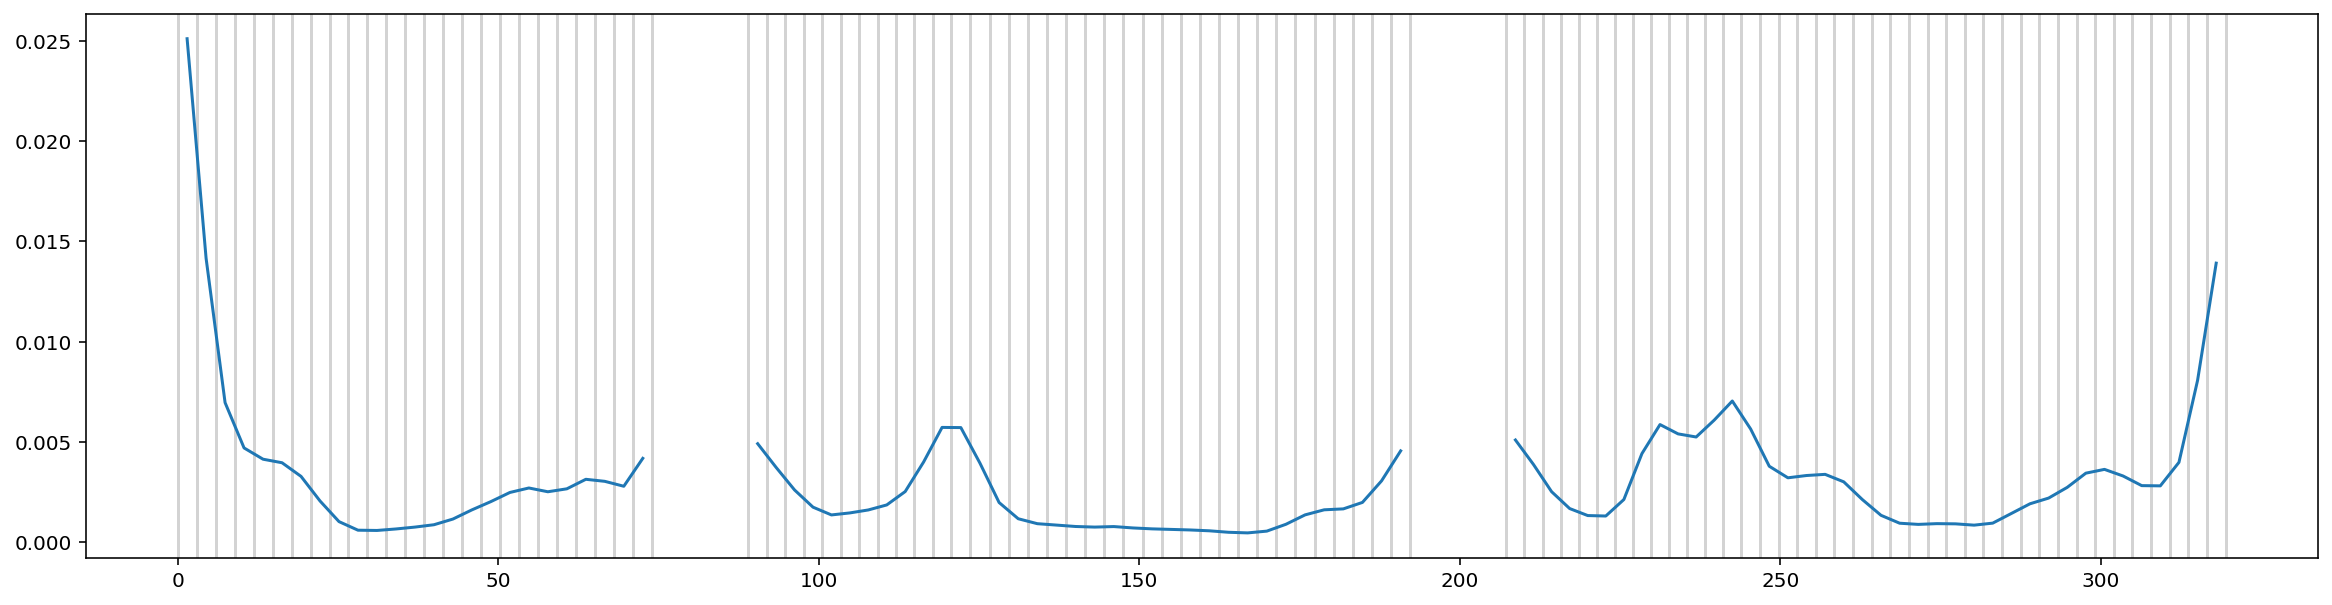

In [64]:
from scipy.stats import multivariate_normal

g = np.full_like(place_bin_centers.squeeze(), np.nan)
g[is_track_interior] = multivariate_normal(mean=0, cov=8).pdf(r.ravel()).reshape(r.shape).mean(axis=0)

plt.figure(figsize=(20, 5))
plt.plot(place_bin_centers, g, zorder=100)

for e in place_bin_edges:
    plt.axvline(e, color='lightgrey')

In [65]:
%%time

import dask

blah = []
for x in batch(n_time, batch_size=1_000):
    blah.append(dask.delayed(batch_distance)(track_graph1, left_node_id[x], right_node_id[x],
                                 left_dist[x], right_dist[x], place_bin_center_to_node_id))
    
r = np.concatenate(dask.compute(*blah), axis=0)

CPU times: user 39.4 s, sys: 5.48 s, total: 44.9 s
Wall time: 7min 42s


In [78]:
from sklearn.neighbors import KDTree


m = data['multiunit'].isel(tetrodes=0).dropna('time').values
is_spike = np.any(~np.isnan(data['multiunit'].isel(tetrodes=0)), axis=1)

In [71]:
tree = KDTree(m)

In [92]:
t = tree.query_radius(m, 20)
m.shape

(14856, 4)

In [111]:
import numba

SQRT_2PI = np.float64(np.sqrt(2.0 * np.pi))


@numba.njit()
def numba_product(eval_point, samples, bandwidths):
    n_samples, n_bandwidths = samples.shape
    product_kernel = np.ones((n_samples,))

    for j in range(n_samples):
        for k in range(n_bandwidths):
            bandwidth = bandwidths[k]
            sample = samples[j, k]
            product_kernel[j] *= (np.exp(
                -0.5 * ((eval_point[k] - sample) / bandwidth)**2) /
                (bandwidth * SQRT_2PI)) / bandwidth

    return product_kernel

In [97]:
np.concatenate([numba_kde(m[0][np.newaxis], m[inds], np.array([20.0, 20.0, 20.0, 20.0]))
                for i, inds in enumerate(t)])

array([7.07610120e-13, 2.39439472e-14, 5.81515765e-14, ...,
       1.12325074e-13, 1.04006476e-13, 6.71046459e-15])

In [108]:
m[0].shape, m[t[0]].shape

((4,), (496, 4))

In [130]:
is_spike = is_spike.values
is_spike

array([False, False, False, ..., False, False, False])

In [131]:
%%snakeviz

bandwidths = np.array([20.0, 20.0, 20.0, 20.0])
k = np.zeros((len(m), place_bin_centers.size))

for ind in range(len(m)):
    k[ind, is_track_interior] = (numba_product(m[ind], m[t[ind]], bandwidths) @ r[is_spike][t[ind]])

 
*** Profile stats marshalled to file '/var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/tmpmkiapuct'. 
Embedding SnakeViz in this document...


In [124]:
k.shape

(14856, 101)

<xarray.DataArray (time: 1396490)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) timedelta64[ns] 01:02:09.025700 ... 01:17:40.018366

In [135]:
from loren_frank_data_processing import get_trial_time

t = get_trial_time(epoch_key, animals) / np.timedelta64(1, 's')
np.diff(t)

array([0.00066667, 0.00066667, 0.00066667, ..., 0.00066667, 0.00066667,
       0.00066667])

In [136]:
t

Float64Index([     3728.9837, 3728.984366666, 3728.985033333,      3728.9857,
              3728.986366666, 3728.987033333,      3728.9877, 3728.988366666,
              3728.989033333,      3728.9897,
              ...
              4660.012366667, 4660.013033333,      4660.0137, 4660.014366667,
              4660.015033333,      4660.0157, 4660.016366667, 4660.017033333,
                   4660.0177, 4660.018366667],
             dtype='float64', name='time', length=1396553)

In [137]:
get_trial_time(epoch_key, animals) 

TimedeltaIndex(['01:02:08.983700', '01:02:08.984366', '01:02:08.985033',
                '01:02:08.985700', '01:02:08.986366', '01:02:08.987033',
                '01:02:08.987700', '01:02:08.988366', '01:02:08.989033',
                '01:02:08.989700',
                ...
                '01:17:40.012366', '01:17:40.013033', '01:17:40.013700',
                '01:17:40.014366', '01:17:40.015033', '01:17:40.015700',
                '01:17:40.016366', '01:17:40.017033', '01:17:40.017700',
                '01:17:40.018366'],
               dtype='timedelta64[ns]', name='time', length=1396553, freq=None)

In [140]:
from loren_frank_data_processing.tetrodes import get_LFP_dataframe, get_LFP_filename
from scipy.io import loadmat


In [142]:
tetrode_info = make_tetrode_dataframe(animals, epoch_key)
tetrode_keys = tetrode_info.index

In [145]:
lfp_file = loadmat(get_LFP_filename(tetrode_keys[0], animals))

In [148]:
lfp_data = lfp_file['eeg'][0, -1][0, -1][0, -1]

In [149]:
start = lfp_data['starttime'][0, 0].item()
n_samples = lfp_data['data'][0, 0].size
sampling_freq = float(lfp_data['samprate'][0, 0].squeeze())

In [150]:
start

3728.9837

In [151]:
lfp_data['starttime'][0, 0]

array([[3728.9837]])

In [152]:
n_samples

1396553

In [153]:
lfp_data['data'][0, 0]

array([[-135],
       [-108],
       [ -71],
       ...,
       [-254],
       [-218],
       [-181]], dtype=int16)